# Описание проекта

Фермер - владелец молочного хозяйства, хочет купить бурёнок, чтобы расширить поголовье стада коров. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям.

Разработана модель машинного обучения, которая поможет фермеру управлять рисками и принимать объективное решение о покупке. Созданы две прогнозные модели для отбора бурёнок в поголовье:

1. Первая будет прогнозировать возможный удой коровы;
2. Вторая — рассчитывать вероятность получить вкусное молоко от коровы.

С помощью модели нужно отобрать коров по двум критериям:

- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

# Цель исследования

1. Разработать модель машинного обучения для отбора коров.
2. Проанализировать предоставленные данные.
3. Дать рекомендации по приобретению.

# Ход исследования

1. Загрузка и изучение данных.
2. Обработка данных.
3. Исследовательский анализ данных.
4. Корреляционный анализ данных.
5. Обучение трех моделей линейной регрессии и выбор лучшей.
6. Прогноз удоя по лучшей модели линейной регрессии.
7. Обучение модели логистической регрессии и ее анализ.
8. Прогноз вкуса молока.
9. Общий прогноз по двум критериям.

---
## Загрузка и изучение данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    root_mean_squared_error,
    accuracy_score,
    confusion_matrix,
    recall_score,
    precision_score   
)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
print(sklearn.__version__)

1.6.1


### <font color="darkgreen">Функции</font>

In [3]:
# функция для постройки гистограммы и ящика с усами
def quantity_func(data, x, bins=30, title='', xlabel='', ylabel=''):
    '''Постройка гистограммы и ящика с усами
    
    Аргументы:
        data: Датафрейм.
        'x': Признак, по которому строится гистограмма.
        bins=30: Количество корзин (по умолчанию 30).
        title='': Название гистограммы.
        xlabel='': Подпись оси Х.
        ylabel='': Подпись оси Y.
        
    Вывод:
        Гистограмма и боксплот с числовыми значениями ключевых характеристик.
    '''
    plt.figure(figsize=(17, 4))
    sns.histplot(data=data, x=x, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(17, 2))
    sns.boxplot(data=data, x=x)
    plt.xlabel(xlabel)
    plt.ylabel(title)
    plt.tight_layout()
    plt.show();
    q1 = data[x].quantile(0.25)
    q3 = data[x].quantile(0.75)
    iqr = q3 - q1
    left = q1 - 1.5 * iqr
    right = q3 + 1.5 * iqr
    print(f'Минимальное значение: {data[x].min():.3f}')
    print(f'Левый ус ящика: {left:.3f}')
    print(f'Первый квантиль Q1: {q1:.3f}')
    print(f'Медианное значение: {data[x].mean():.3f}')
    print(f'Третий квантиль Q3: {q3:.3f}')
    print(f'Правый ус ящика: {right:.3f}')
    print(f'Максимальное значение: {data[x].max():.3f}')

In [4]:
# функция для постройки пирога
def category_func(data, index, title):
    data.pivot_table(
        index=index,
        values='id',
        aggfunc='count'
    ).plot(
        kind='pie',
        y='id',
        title=title,
        ylabel='',
        figsize=(6, 6))
    plt.show();
    print(data[index].value_counts())

In [5]:
# функция для постройки диаграмм рассеяния
def scatter_func(data, x, y, title='', xlabel='', ylabel=''):
    plt.figure(figsize=(17, 15))
    
    plt.subplot(3, 2, 1)
    sns.scatterplot(data=data, x=x, y=y, hue='breed')
    plt.grid(True)
    plt.title(title+' с учетом породы коровы')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.subplot(3, 2, 2)
    sns.scatterplot(data=data, x=x, y=y, hue='pasture_type')
    plt.grid(True)
    plt.title(title+' с учетом типа пастбища')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.subplot(3, 2, 3)
    sns.scatterplot(data=data, x=x, y=y, hue='dad_breed')
    plt.grid(True)
    plt.title(title+' с учетом породы папы коровы')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)    
    
    plt.subplot(3, 2, 4)
    sns.scatterplot(data=data, x=x, y=y, hue='milk_flavor')
    plt.grid(True)
    plt.title(title+' с учетом вкуса молока')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.subplot(3, 2, 5)
    sns.scatterplot(data=data, x=x, y=y, hue='age')
    plt.grid(True)
    plt.title(title+' с учетом возраста коровы')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show();

### <font color="darkgreen">Загрузка данных</font>

In [6]:
# загрузим данные в датафреймы, разделить точка с запятой
ferma_main = pd.read_csv('ferma_main.csv', sep=';', decimal=',')
ferma_dad = pd.read_csv('ferma_dad.csv', sep=';')
cow_buy = pd.read_csv('cow_buy.csv', sep=';', decimal=',')

### <font color="darkgreen">Изучение данных</font>

#### <font color="braun">Изучение `ferma_main`</font>

In [7]:
# выведем первые строчки датафрейма
ferma_main.head()

id  Удой, кг  ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                   14.2              1743   
1   2      5529                                   12.8              2138   
2   3      5810                                   14.0              1854   
3   4      5895                                   12.4              2012   
4   5      5302                                   12.8              1675   

   СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0.890   Вис Бик Айдиал    Равнинное   
1                                 0.890   Вис Бик Айдиал    Равнинные   
2                                 0.885  РефлешнСоверинг    Холмистое   
3                                 0.885  РефлешнСоверинг    Холмистое   
4                                 0.885   Вис Бик Айдиал    Равнинные   

  порода папы_быка  Жирность,%  Белок,% Вкус молока      Возраст  
0           Айдиал        3.58    3.076      вкусно  более_2_лет  
1          Соверин        3.54    3.079      вкусно  менее_2_лет  
2          Соверин        3.59    3.074   не вкусно  более_2_лет  
3           Айдиал        3.40    3.075   не вкусно  более_2_лет  
4          Соверин        3.73    3.073      вкусно  менее_2_лет

In [8]:
# заменим названия столбцов
ferma_main.columns = ['id',
                      'yield',
                      'ef_unit',
                      'crude_protein',
                      'sp_ratio',
                      'breed',
                      'pasture_type',
                      'dad_breed',
                      'fat_content',
                      'protein',
                      'milk_flavor',
                      'age'
                     ]
ferma_main.head()

id  yield  ef_unit  crude_protein  sp_ratio            breed pasture_type  \
0   1   5863     14.2           1743     0.890   Вис Бик Айдиал    Равнинное   
1   2   5529     12.8           2138     0.890   Вис Бик Айдиал    Равнинные   
2   3   5810     14.0           1854     0.885  РефлешнСоверинг    Холмистое   
3   4   5895     12.4           2012     0.885  РефлешнСоверинг    Холмистое   
4   5   5302     12.8           1675     0.885   Вис Бик Айдиал    Равнинные   

  dad_breed  fat_content  protein milk_flavor          age  
0    Айдиал         3.58    3.076      вкусно  более_2_лет  
1   Соверин         3.54    3.079      вкусно  менее_2_лет  
2   Соверин         3.59    3.074   не вкусно  более_2_лет  
3    Айдиал         3.40    3.075   не вкусно  более_2_лет  
4   Соверин         3.73    3.073      вкусно  менее_2_лет

#### <font color="braun">Изучение `ferma_dad`</font>

In [9]:
# выведем первые строчки датафрейма
ferma_dad.head()

id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин

In [10]:
# заменим названия столбцов
ferma_dad.columns = ['id', 'dad_name']
ferma_dad.head()

id  dad_name
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин

#### <font color="braun">Изучение `cow_buy`</font>

In [11]:
# выведем первые строчки датафрейма
cow_buy.head()

Порода Тип пастбища порода папы_быка  Имя_папы  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный   
2  РефлешнСоверинг    равнинное          Соверин     Барин   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный   

   Текущая_жирность,%  Текущий_уровень_белок,%      Возраст  
0                3.58                    3.076  более_2_лет  
1                3.54                    3.081  менее_2_лет  
2                3.59                    3.074  более_2_лет  
3                3.40                    3.061  более_2_лет  
4                3.64                    3.074  более_2_лет

In [12]:
# заменим названия столбцов
cow_buy.columns = ['breed',
                   'pasture_type',
                   'dad_breed',
                   'dad_name',
                   'fat_content',
                   'protein',
                   'age'
                  ]
cow_buy.head()

breed pasture_type dad_breed  dad_name  fat_content  protein  \
0   Вис Бик Айдиал    холмистое    Айдиал  Геркулес         3.58    3.076   
1   Вис Бик Айдиал    равнинное   Соверин    Буйный         3.54    3.081   
2  РефлешнСоверинг    равнинное   Соверин     Барин         3.59    3.074   
3  РефлешнСоверинг    холмистое    Айдиал    Буйный         3.40    3.061   
4  РефлешнСоверинг    равнинное    Айдиал    Буйный         3.64    3.074   

           age  
0  более_2_лет  
1  менее_2_лет  
2  более_2_лет  
3  более_2_лет  
4  более_2_лет

### <font color="darkred">Вывод по разделу</font>

В данном разделе мы провели первичное изучение данных. Во всех трех датафреймах заменили названия столбцов. По первичному обзору можно выделить несколько моментов, которые мы подробней рассмотрим в следующем разделе:

`ferma_main:`
- названия пород встречаются как с пробелами, так и насписанные слитно, здесь могут скрываться дубликаты;
- типы пастбищ есть в единственном и множественном числах, их следует привести к единому написанию;
- возраст написан с использованием нижнего подчеркивания вместо пробелов между словами, следует исправить.

`ferma_dad:`

- явных проблем в данных не обнаружено.

`cow_buy:`

- названия пород встречаются как с пробелами, так и насписанные слитно, здесь могут скрываться дубликаты;
- типы пастбищ написаны с прописной буквы, отлично от `ferma_main`, следует привести к единому написанию;
- возраст написан с использованием нижнего подчеркивания вместо пробелов между словами, следует исправить.

---
##  <font color="darkblue">Предобработка данных</font>

В данном разделе проведем проверку данных на наличие пропусков, дубликатов, скорректируем типы данных в каждом датафрейме.

### <font color="darkgreen">Предобработка `ferma_main`</font>

#### <font color="braun">Проверка на наличие пропусков</font>

In [13]:
# выведем общую информацию
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             634 non-null    int64  
 1   yield          634 non-null    int64  
 2   ef_unit        634 non-null    float64
 3   crude_protein  634 non-null    int64  
 4   sp_ratio       634 non-null    float64
 5   breed          634 non-null    object 
 6   pasture_type   634 non-null    object 
 7   dad_breed      634 non-null    object 
 8   fat_content    634 non-null    float64
 9   protein        634 non-null    float64
 10  milk_flavor    634 non-null    object 
 11  age            634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


В датафрейме 634 строки и 12 столбцов. Пропущенных значений нет.

#### <font color="braun">Проверка на наличие дубликатов</font>

In [14]:
# выведем датафрейм
ferma_main.head()

id  yield  ef_unit  crude_protein  sp_ratio            breed pasture_type  \
0   1   5863     14.2           1743     0.890   Вис Бик Айдиал    Равнинное   
1   2   5529     12.8           2138     0.890   Вис Бик Айдиал    Равнинные   
2   3   5810     14.0           1854     0.885  РефлешнСоверинг    Холмистое   
3   4   5895     12.4           2012     0.885  РефлешнСоверинг    Холмистое   
4   5   5302     12.8           1675     0.885   Вис Бик Айдиал    Равнинные   

  dad_breed  fat_content  protein milk_flavor          age  
0    Айдиал         3.58    3.076      вкусно  более_2_лет  
1   Соверин         3.54    3.079      вкусно  менее_2_лет  
2   Соверин         3.59    3.074   не вкусно  более_2_лет  
3    Айдиал         3.40    3.075   не вкусно  более_2_лет  
4   Соверин         3.73    3.073      вкусно  менее_2_лет

In [15]:
# выведем уникальные значения
ferma_main['breed'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

Столбец `breed` - порода, содержит два уникальных значения. Поправим только одно из них, удалив пробелы.

In [16]:
# удалим все пробелы
ferma_main['breed'] = ferma_main['breed'].str.replace(' ', '')
# выведем уникальные значения
ferma_main['breed'].unique()

array(['ВисБикАйдиал', 'РефлешнСоверинг'], dtype=object)

In [17]:
# выведем уникальные значения
ferma_main['pasture_type'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

Столбец `pasture_type` - тип пастбища, содержит три уникальных значения, причем одно из них является множественным значением другого. Поправим это.

In [18]:
# заменим множественное значение пастбищ на единственное
ferma_main.loc[ferma_main['pasture_type'] == 'Равнинные', 'pasture_type'] = 'Равнинное'
# сделаем все названия типов пастбищ прописными буквами
ferma_main['pasture_type'] = ferma_main['pasture_type'].str.lower()
# выведем уникальные значения
ferma_main['pasture_type'].unique()

array(['равнинное', 'холмистое'], dtype=object)

In [19]:
# выведем уникальные значения
ferma_main['dad_breed'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

Столбец `dad_breed` - порода папы быка, содержит три уникальных значения, причем одно из них является ошибочным написанием другого. Поправим это.

In [20]:
# заменим имя
ferma_main.loc[ferma_main['dad_breed'] == 'Айдиалл', 'dad_breed'] = 'Айдиал'
# выведем уникальные значения
ferma_main['dad_breed'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [21]:
# выведем уникальные значения
ferma_main['milk_flavor'].unique()

array(['вкусно', 'не вкусно'], dtype=object)

In [22]:
# выведем уникальные значения
ferma_main['age'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

В этих столбцах менять ничего не будем, их уникальные значения отличны друг от друга.

In [23]:
# выведем дубликаты
ferma_main[ferma_main.duplicated()]

id  yield  ef_unit  crude_protein  sp_ratio            breed  \
629  627   5970     14.4           1837      0.88  РефлешнСоверинг   
630  627   5970     14.4           1837      0.88  РефлешнСоверинг   
631  627   5970     14.4           1837      0.88  РефлешнСоверинг   
632  627   5970     14.4           1837      0.88  РефлешнСоверинг   
633  627   5970     14.4           1837      0.88  РефлешнСоверинг   

    pasture_type dad_breed  fat_content  protein milk_flavor          age  
629    холмистое   Соверин         3.64    3.075   не вкусно  более_2_лет  
630    холмистое   Соверин         3.64    3.075   не вкусно  более_2_лет  
631    холмистое   Соверин         3.64    3.075   не вкусно  более_2_лет  
632    холмистое   Соверин         3.64    3.075   не вкусно  более_2_лет  
633    холмистое   Соверин         3.64    3.075   не вкусно  более_2_лет

В датафрейме обнаружены 5 дубликатов, удалим их.

In [24]:
# удалим дубликаты со сбросом индекса
ferma_main = ferma_main.drop_duplicates().reset_index(drop=True)
# выведем количесвто дубликатов
ferma_main.duplicated().sum()

0

Все явные дубликаты удалены, не явных дубликатов нет.

#### <font color="braun">Проверка типов данных</font>

In [25]:
# выведем общую информацию
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             629 non-null    int64  
 1   yield          629 non-null    int64  
 2   ef_unit        629 non-null    float64
 3   crude_protein  629 non-null    int64  
 4   sp_ratio       629 non-null    float64
 5   breed          629 non-null    object 
 6   pasture_type   629 non-null    object 
 7   dad_breed      629 non-null    object 
 8   fat_content    629 non-null    float64
 9   protein        629 non-null    float64
 10  milk_flavor    629 non-null    object 
 11  age            629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.1+ KB


In [26]:
# выведем датафрейм
ferma_main.head()

id  yield  ef_unit  crude_protein  sp_ratio            breed pasture_type  \
0   1   5863     14.2           1743     0.890     ВисБикАйдиал    равнинное   
1   2   5529     12.8           2138     0.890     ВисБикАйдиал    равнинное   
2   3   5810     14.0           1854     0.885  РефлешнСоверинг    холмистое   
3   4   5895     12.4           2012     0.885  РефлешнСоверинг    холмистое   
4   5   5302     12.8           1675     0.885     ВисБикАйдиал    равнинное   

  dad_breed  fat_content  protein milk_flavor          age  
0    Айдиал         3.58    3.076      вкусно  более_2_лет  
1   Соверин         3.54    3.079      вкусно  менее_2_лет  
2   Соверин         3.59    3.074   не вкусно  более_2_лет  
3    Айдиал         3.40    3.075   не вкусно  более_2_лет  
4   Соверин         3.73    3.073      вкусно  менее_2_лет

Добавим два столбца с бинарными значениями на основе столбцов о вкусе молока и возрасте коровы.

In [27]:
# добавим два числовых столбца
ferma_main['milk_flavor_'] = (ferma_main['milk_flavor'] == 'вкусно').astype('int8')
ferma_main['age_'] = (ferma_main['age'] == 'более_2_лет').astype('int8')
# выведем датафрейм
ferma_main.head()

id  yield  ef_unit  crude_protein  sp_ratio            breed pasture_type  \
0   1   5863     14.2           1743     0.890     ВисБикАйдиал    равнинное   
1   2   5529     12.8           2138     0.890     ВисБикАйдиал    равнинное   
2   3   5810     14.0           1854     0.885  РефлешнСоверинг    холмистое   
3   4   5895     12.4           2012     0.885  РефлешнСоверинг    холмистое   
4   5   5302     12.8           1675     0.885     ВисБикАйдиал    равнинное   

  dad_breed  fat_content  protein milk_flavor          age  milk_flavor_  age_  
0    Айдиал         3.58    3.076      вкусно  более_2_лет             1     1  
1   Соверин         3.54    3.079      вкусно  менее_2_лет             1     0  
2   Соверин         3.59    3.074   не вкусно  более_2_лет             0     1  
3    Айдиал         3.40    3.075   не вкусно  более_2_лет             0     1  
4   Соверин         3.73    3.073      вкусно  менее_2_лет             1     0

In [28]:
# выведем числовые характеристики данных
ferma_main.describe().T

count         mean          std       min       25%       50%  \
id             629.0   315.000000   181.720940     1.000   158.000   315.000   
yield          629.0  6188.750397  1644.795489  5204.000  5751.000  6133.000   
ef_unit        629.0    14.543879     1.306408    10.900    13.500    14.700   
crude_protein  629.0  1923.364070   182.956251  1660.000  1771.000  1888.000   
sp_ratio       629.0     0.913116     0.032203     0.840     0.890     0.930   
fat_content    629.0     3.603657     0.168656     2.990     3.590     3.650   
protein        629.0     3.075671     0.002549     3.069     3.074     3.076   
milk_flavor_   629.0     0.589825     0.492257     0.000     0.000     1.000   
age_           629.0     0.825119     0.380167     0.000     1.000     1.000   

                    75%        max  
id              472.000    629.000  
yield          6501.000  45616.000  
ef_unit          15.600     16.800  
crude_protein  2062.000   2349.000  
sp_ratio          0.940      0.960  
fat_content       3.720      3.750  
protein           3.077      3.085  
milk_flavor_      1.000      1.000  
age_              1.000      1.000

Судя по числовым характеристикам, есть подозрительное значение в столбце удоев. Рассмотрим данные в этом столбе подробнее.

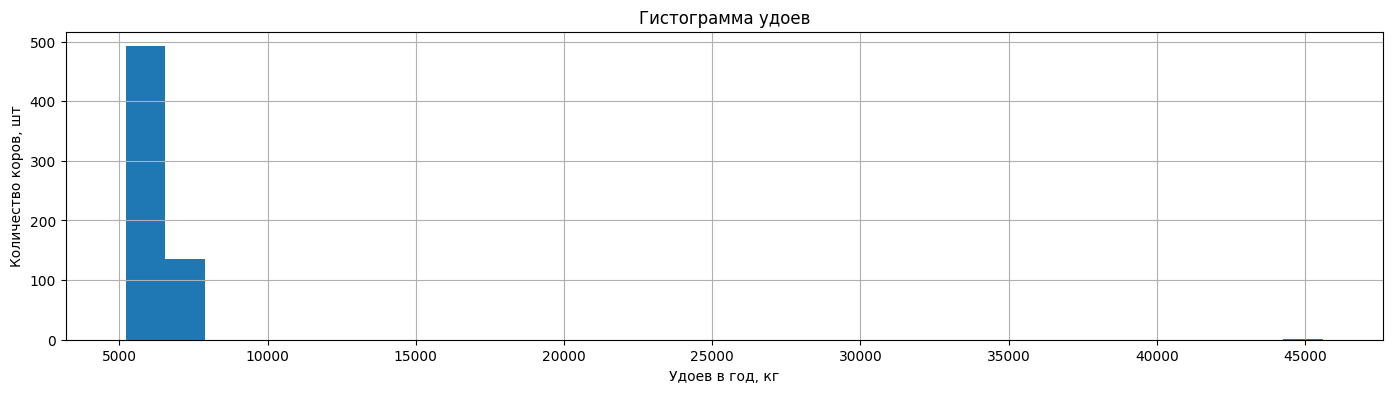

In [29]:
# построим гистограмму удоев
ferma_main['yield'].hist(bins=30, figsize=(17, 4))
plt.title('Гистограмма удоев')
plt.xlabel('Удоев в год, кг')
plt.ylabel('Количество коров, шт');

На гистограмме виден один выброс - максимальное значение в `45616` кг. Удалим строку с этими данными и построим гистограму еще раз.

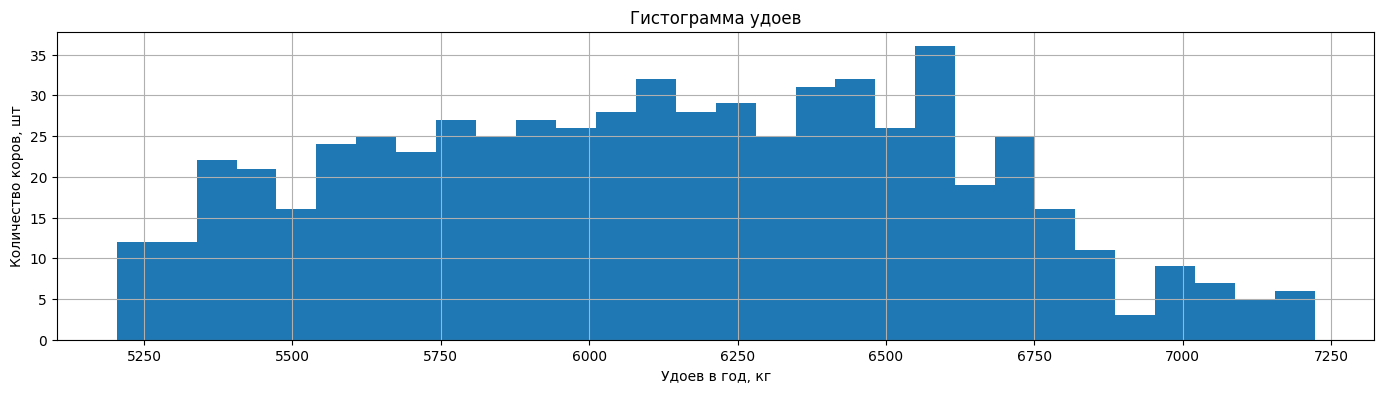

In [30]:
# удалим выброс
ferma_main = ferma_main.loc[ferma_main['yield'] != 45616].reset_index(drop=True)
# построим гистограмму удоев
ferma_main['yield'].hist(bins=30, figsize=(17, 4))
plt.title('Гистограмма удоев')
plt.xlabel('Удоев в год, кг')
plt.ylabel('Количество коров, шт');

In [31]:
# выведем числовые характеристики данных
ferma_main.describe().T

count         mean         std       min       25%       50%  \
id             628.0   315.474522  181.475367     1.000   158.750   315.500   
yield          628.0  6125.968153  475.857053  5204.000  5749.750  6132.500   
ef_unit        628.0    14.548726    1.301777    10.900    13.500    14.700   
crude_protein  628.0  1923.759554  182.832816  1660.000  1771.750  1888.000   
sp_ratio       628.0     0.913089    0.032221     0.840     0.890     0.930   
fat_content    628.0     3.604268    0.168093     2.990     3.590     3.650   
protein        628.0     3.075670    0.002551     3.069     3.074     3.076   
milk_flavor_   628.0     0.589172    0.492376     0.000     0.000     1.000   
age_           628.0     0.824841    0.380406     0.000     1.000     1.000   

                    75%       max  
id              472.250   629.000  
yield          6501.000  7222.000  
ef_unit          15.600    16.800  
crude_protein  2062.250  2349.000  
sp_ratio          0.940     0.960  
fat_content       3.720     3.750  
protein           3.077     3.085  
milk_flavor_      1.000     1.000  
age_              1.000     1.000

Теперь все данные выглядят более правдоподобно.

### <font color="darkgreen">Предобработка `ferma_dad`</font>

#### <font color="braun">Проверка на наличие пропусков, проверка типа данных</font>

In [32]:
# выведем общую информацию
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   dad_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


В датафрейме 629 строк и 2 столбца. Пропущенных значений нет. Типы данных соответствуют.

#### <font color="braun">Проверка на наличие дубликатов</font>

In [33]:
# выведем датафрейм
ferma_dad.head()

id  dad_name
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин

In [34]:
# выведем уникальные значения
ferma_dad['dad_name'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

In [35]:
# выведем количество дубликатов
ferma_dad.duplicated().sum()

0

В датафрейме явных и неявных дубликатов не обнаружено.

### <font color="darkgreen">Предобработка `cow_buy`</font>

#### <font color="braun">Проверка на наличие пропусков</font>

In [36]:
# выведем общую информацию
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   breed         20 non-null     object 
 1   pasture_type  20 non-null     object 
 2   dad_breed     20 non-null     object 
 3   dad_name      20 non-null     object 
 4   fat_content   20 non-null     float64
 5   protein       20 non-null     float64
 6   age           20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


В датафрейме 20 строк и 7 столбцов. Пропущенных значений нет.

#### <font color="braun">Проверка на наличие дубликатов</font>

In [37]:
# выведем датафрейм
cow_buy.head()

breed pasture_type dad_breed  dad_name  fat_content  protein  \
0   Вис Бик Айдиал    холмистое    Айдиал  Геркулес         3.58    3.076   
1   Вис Бик Айдиал    равнинное   Соверин    Буйный         3.54    3.081   
2  РефлешнСоверинг    равнинное   Соверин     Барин         3.59    3.074   
3  РефлешнСоверинг    холмистое    Айдиал    Буйный         3.40    3.061   
4  РефлешнСоверинг    равнинное    Айдиал    Буйный         3.64    3.074   

           age  
0  более_2_лет  
1  менее_2_лет  
2  более_2_лет  
3  более_2_лет  
4  более_2_лет

In [38]:
# выведем уникальные значения
cow_buy['breed'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

Столбец `breed` - порода, содержит два уникальных значения. Поправим только одно из них, удалив пробелы.

In [39]:
# удалим все пробелы
cow_buy['breed'] = cow_buy['breed'].str.replace(' ', '')
# выведем уникальные значения
cow_buy['breed'].unique()

array(['ВисБикАйдиал', 'РефлешнСоверинг'], dtype=object)

In [40]:
# выведем уникальные значения
cow_buy['pasture_type'].unique()

array(['холмистое', 'равнинное'], dtype=object)

Столбец `pasture_type` - тип пастбища, содержит те же два уникальных значения, что и датафрейм `ferma_main`.

In [41]:
# выведем уникальные значения
cow_buy['dad_breed'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

Столбец `dad_breed` - порода папы быка, содержит те же два уникальных значения, что и датафрейм `ferma_main`.

In [42]:
# выведем уникальные значения
cow_buy['age'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

Столбец `age` - возраст, содержит те же два уникальных значения, что и датафрейм `ferma_main`.

In [43]:
# выведем дубликаты
cow_buy[cow_buy.duplicated()]

breed pasture_type dad_breed  dad_name  fat_content  protein  \
6      ВисБикАйдиал    холмистое    Айдиал  Геркулес         3.58    3.076   
8   РефлешнСоверинг    равнинное   Соверин     Барин         3.59    3.074   
14  РефлешнСоверинг    равнинное   Соверин     Барин         3.59    3.074   
19  РефлешнСоверинг    равнинное    Айдиал    Буйный         3.64    3.074   

            age  
6   более_2_лет  
8   более_2_лет  
14  более_2_лет  
19  более_2_лет

В датафрейме обнаружены 4 дубликата, удалим их.

In [44]:
# удалим дубликаты со сбросом индекса
cow_buy = cow_buy.drop_duplicates().reset_index(drop=True)
# выведем количесвто дубликатов
cow_buy.duplicated().sum()

0

Все явные дубликаты удалены, не явных дубликатов нет.

#### <font color="braun">Проверка типов данных</font>

In [45]:
# выведем общую информацию
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   breed         16 non-null     object 
 1   pasture_type  16 non-null     object 
 2   dad_breed     16 non-null     object 
 3   dad_name      16 non-null     object 
 4   fat_content   16 non-null     float64
 5   protein       16 non-null     float64
 6   age           16 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.0+ KB


In [46]:
# выведем датафрейм
cow_buy.head()

breed pasture_type dad_breed  dad_name  fat_content  protein  \
0     ВисБикАйдиал    холмистое    Айдиал  Геркулес         3.58    3.076   
1     ВисБикАйдиал    равнинное   Соверин    Буйный         3.54    3.081   
2  РефлешнСоверинг    равнинное   Соверин     Барин         3.59    3.074   
3  РефлешнСоверинг    холмистое    Айдиал    Буйный         3.40    3.061   
4  РефлешнСоверинг    равнинное    Айдиал    Буйный         3.64    3.074   

           age  
0  более_2_лет  
1  менее_2_лет  
2  более_2_лет  
3  более_2_лет  
4  более_2_лет

Добавим столбец с бинарными значениями на основе столбца о возрасте коровы.

In [47]:
# добавим столбец
cow_buy['age_'] = (cow_buy['age'] == 'более_2_лет').astype('int8')
# выведем датафрейм
cow_buy.head()

breed pasture_type dad_breed  dad_name  fat_content  protein  \
0     ВисБикАйдиал    холмистое    Айдиал  Геркулес         3.58    3.076   
1     ВисБикАйдиал    равнинное   Соверин    Буйный         3.54    3.081   
2  РефлешнСоверинг    равнинное   Соверин     Барин         3.59    3.074   
3  РефлешнСоверинг    холмистое    Айдиал    Буйный         3.40    3.061   
4  РефлешнСоверинг    равнинное    Айдиал    Буйный         3.64    3.074   

           age  age_  
0  более_2_лет     1  
1  менее_2_лет     0  
2  более_2_лет     1  
3  более_2_лет     1  
4  более_2_лет     1

In [48]:
# выведем общую информацию
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   breed         16 non-null     object 
 1   pasture_type  16 non-null     object 
 2   dad_breed     16 non-null     object 
 3   dad_name      16 non-null     object 
 4   fat_content   16 non-null     float64
 5   protein       16 non-null     float64
 6   age           16 non-null     object 
 7   age_          16 non-null     int8   
dtypes: float64(2), int8(1), object(5)
memory usage: 1.0+ KB


In [49]:
# выведем числовые характеристики данных
cow_buy.describe().T

count      mean       std    min     25%     50%      75%    max
fat_content   16.0  3.571875  0.141620  3.340  3.4150  3.5850  3.69250  3.770
protein       16.0  3.068250  0.011264  3.046  3.0595  3.0735  3.07675  3.081
age_          16.0  0.687500  0.478714  0.000  0.0000  1.0000  1.00000  1.000

Судя по числовым характеристкам, теперь все данные выглядят правдоподобно.

### <font color="darkred">Вывод по разделу</font>

В данном разделе была проведена предобработка датафреймов `ferma_main`, `ferma_dad`, `cow_buy`. Были удалены пробелы в данных у некоторых столбцов, исправлены неявные дубли в названиях типов холмов, исправлены ошибочные написания пород быков, удалены явные дубликаты в количестве 9 штук и удален 1 выброс.

Так же в два датафрейма, на основе их столбцов, были добавлены столбцы с бинарными значениями по вкусу молока и возрасту коровы.

---
## <font color="darkblue">Исследовательский анализ данных</font>

### <font color="darkgreen">Статистический анализ всех признаков</font>

Признаки в датасете `ferma_main.csv` разделим на группы.

**Количественные характеристики:**
- Характеристики корма:
    - `ЭКЕ (Энергетическая кормовая единица) - ef_unit`,
    - `Сырой протеин, г - crude_protein`,
    - `СПО (Сахаро-протеиновое соотношение) - sp_ratio`.
- Характеристики молока:
    - `Удой, кг - yield`,
    - `Жирность, % - fat_content`,
    - `Белок, % - protein`.

**Категориальные:**
- Характеристики коровы:
    - `id`,
    - `Порода - breed`,
    - `порода папы_быка - dad_breed`,
    - `Возраст - age`.
- Характеристики молока:
    - `Вкус молока - milk_flavor`.
- Характеристика пастбища:
    - `Тип пастбища - pasture_type`.

Такое разделение поможет понять, как взаимосвязаны признаки в датасете.

### <font color="darkgreen">Построение графиков и анализ признаков</font>

#### <font color="braun">Количественные признаки</font>

Проведем анализ всех количественных признаков.

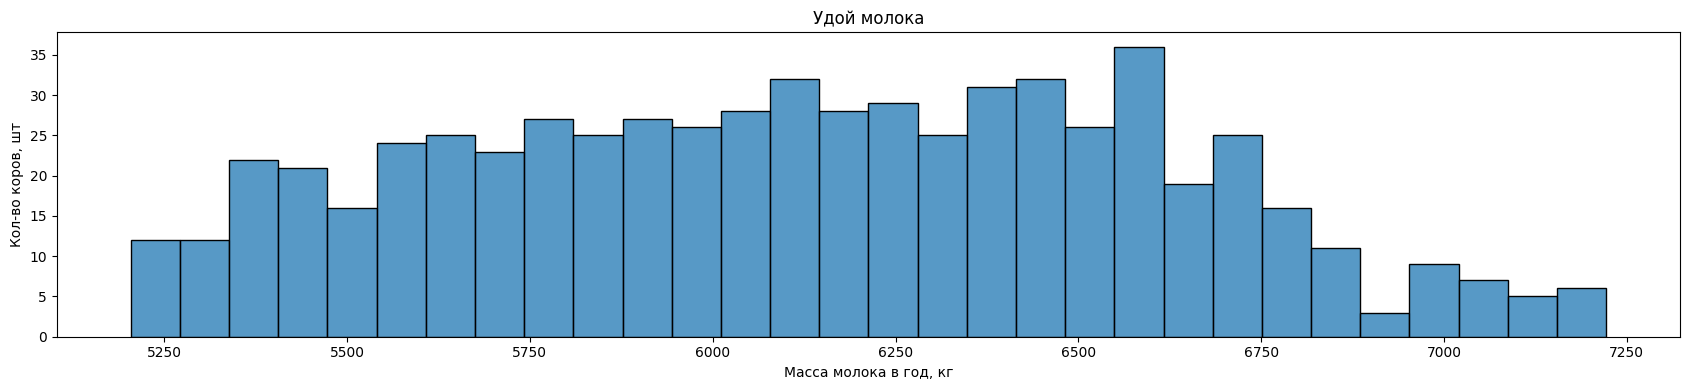

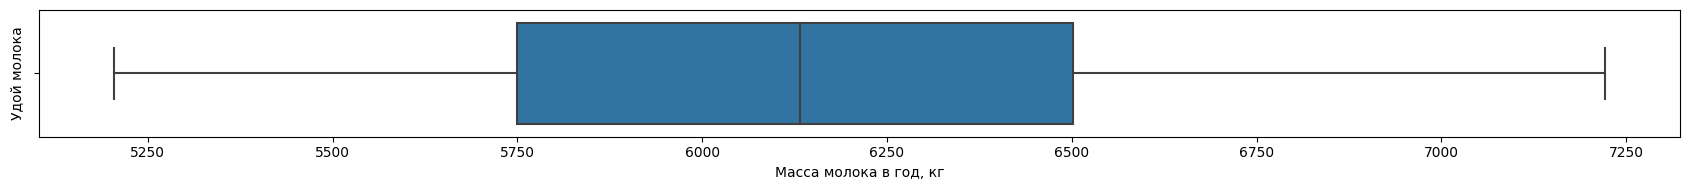

Минимальное значение: 5204.000
Левый ус ящика: 4622.875
Первый квантиль Q1: 5749.750
Медианное значение: 6125.968
Третий квантиль Q3: 6501.000
Правый ус ящика: 7627.875
Максимальное значение: 7222.000


In [50]:
# анализ удоя коров
quantity_func(ferma_main,
              'yield',
              title='Удой молока',
              xlabel='Масса молока в год, кг',
              ylabel='Кол-во коров, шт')

Распределение удоя молока без выбросов, приблизительно похоже на нормальное.

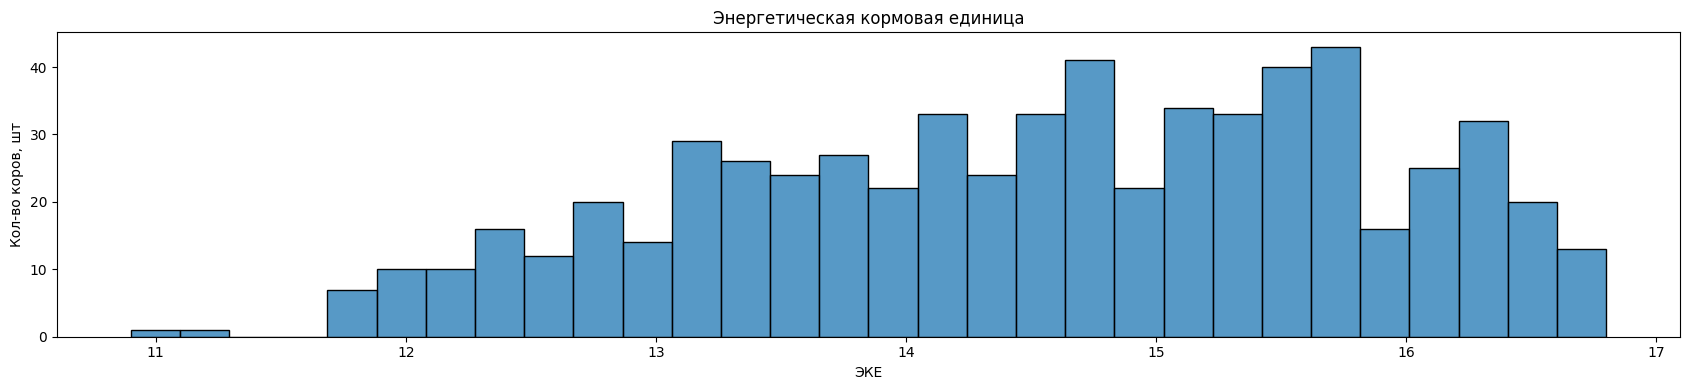

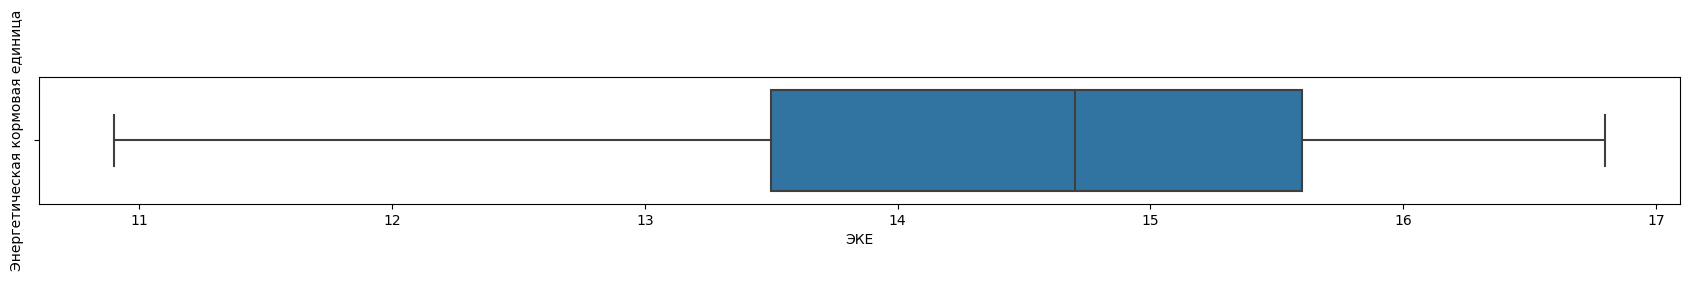

Минимальное значение: 10.900
Левый ус ящика: 10.350
Первый квантиль Q1: 13.500
Медианное значение: 14.549
Третий квантиль Q3: 15.600
Правый ус ящика: 18.750
Максимальное значение: 16.800


In [51]:
# анализ эке корма
quantity_func(ferma_main,
              'ef_unit',
              title='Энергетическая кормовая единица',
              xlabel='ЭКЕ',
              ylabel='Кол-во коров, шт')

Распределение ЭКЕ похоже на нормальное со смещением вправо. Есть в начале гистограммы значения, расположенные в отрыве от основной массы, но они не выходят за левый ус и выбросами их считать нельзя.

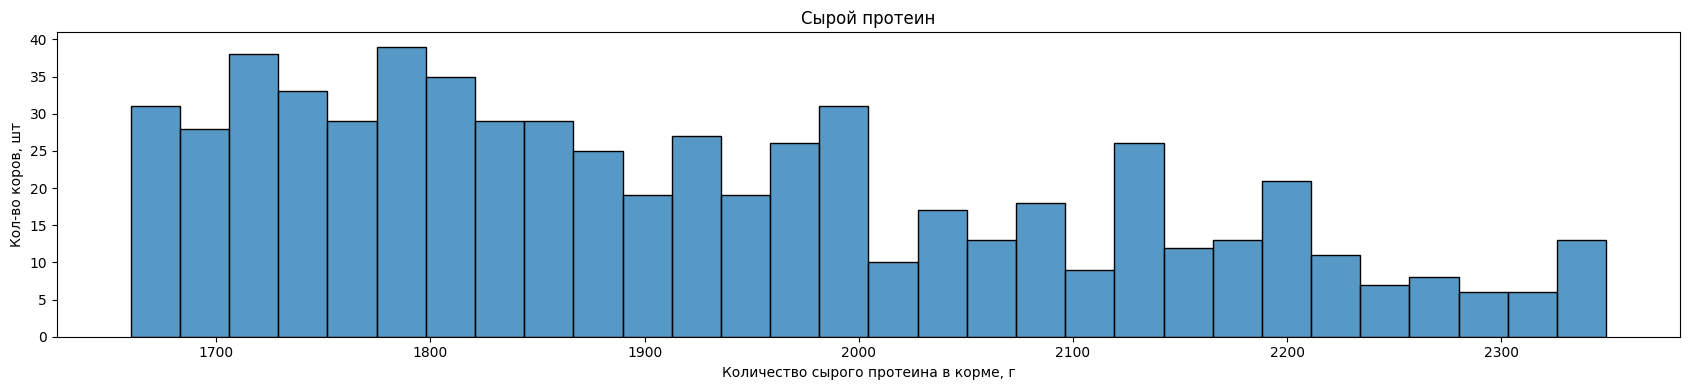

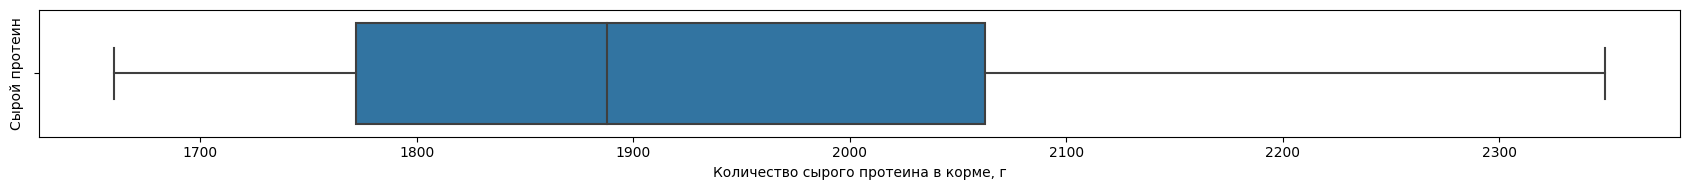

Минимальное значение: 1660.000
Левый ус ящика: 1336.000
Первый квантиль Q1: 1771.750
Медианное значение: 1923.760
Третий квантиль Q3: 2062.250
Правый ус ящика: 2498.000
Максимальное значение: 2349.000


In [52]:
# анализ сырого протеина в корме
quantity_func(ferma_main,
              'crude_protein',
              title='Сырой протеин',
              xlabel='Количество сырого протеина в корме, г',
              ylabel='Кол-во коров, шт')

Распределение сырого протеина похоже на нормальное со смещеним влево. Выбросов нет.

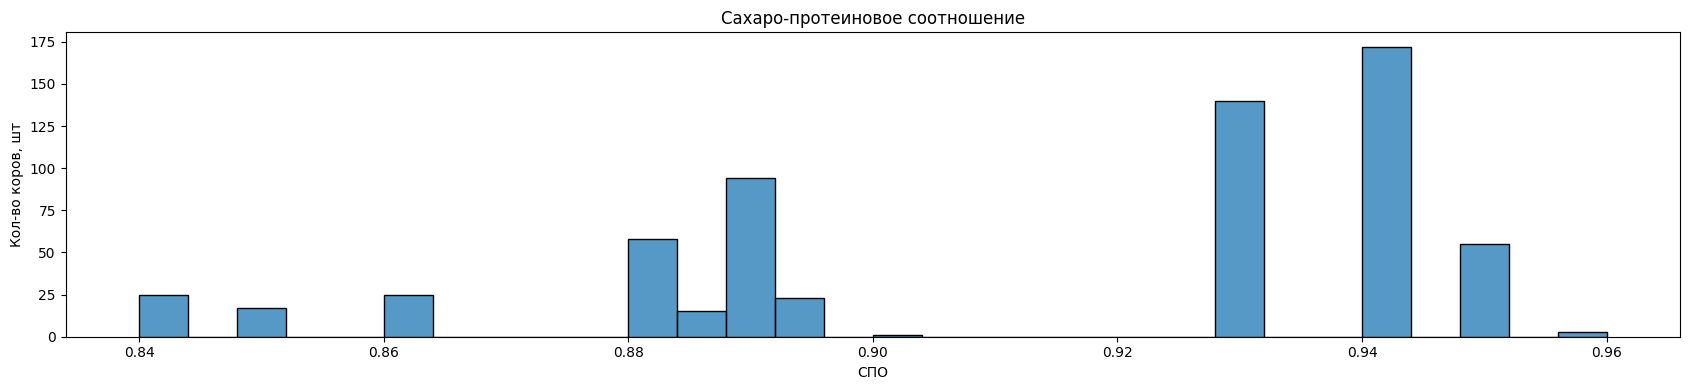

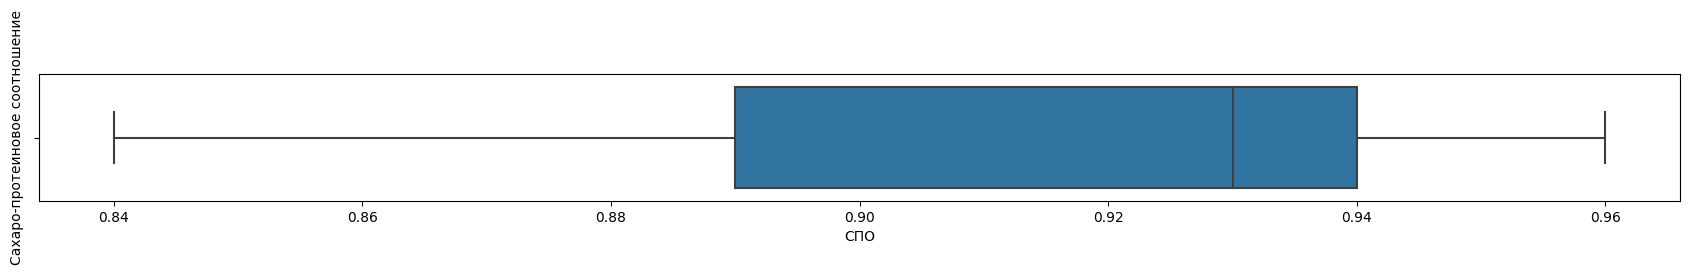

Минимальное значение: 0.840
Левый ус ящика: 0.815
Первый квантиль Q1: 0.890
Медианное значение: 0.913
Третий квантиль Q3: 0.940
Правый ус ящика: 1.015
Максимальное значение: 0.960


In [53]:
# анализ сахаро-протеинового соотношения в корме
quantity_func(ferma_main,
              'sp_ratio',
              title='Сахаро-протеиновое соотношение',
              xlabel='СПО',
              ylabel='Кол-во коров, шт')

Распределение СПО разделено на две или три группы. Возможно так выделяются разные сорта кормов. Выбросов нет, но вторая группа более масштабна, что дополнительно подтверждается и медианным значением.

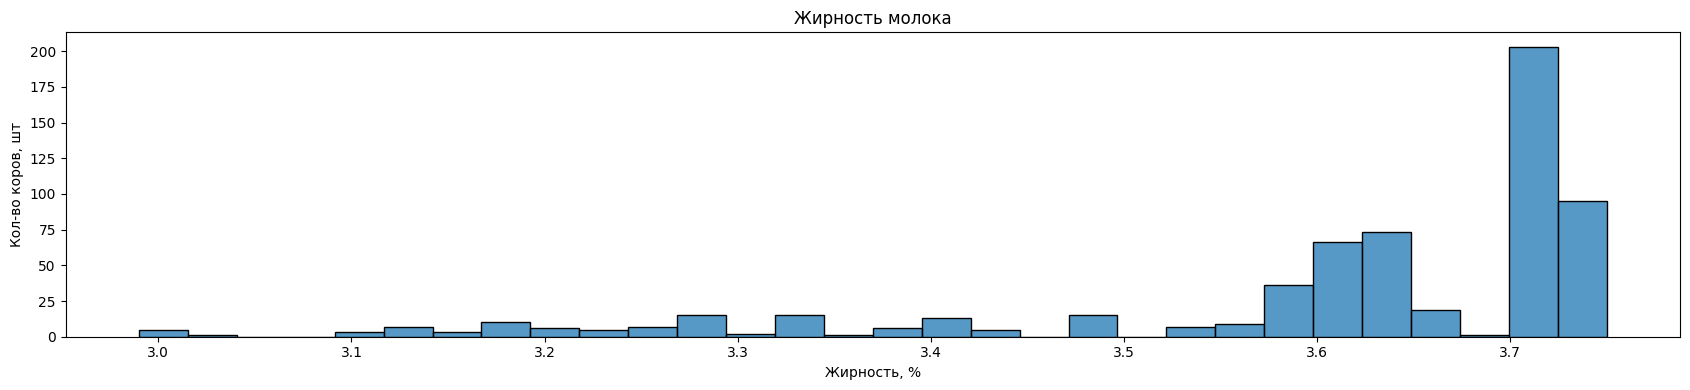

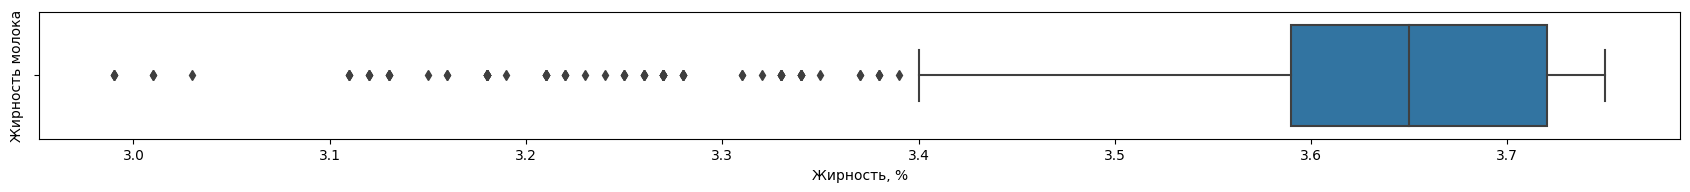

Минимальное значение: 2.990
Левый ус ящика: 3.395
Первый квантиль Q1: 3.590
Медианное значение: 3.604
Третий квантиль Q3: 3.720
Правый ус ящика: 3.915
Максимальное значение: 3.750


In [54]:
# анализ жирности молока
quantity_func(ferma_main,
              'fat_content',
              title='Жирность молока',
              xlabel='Жирность, %',
              ylabel='Кол-во коров, шт')

Распределение жирности делится на две группы. Первая группа с жирностью в районе чуть больше 3.6 %, вторая в районе чуть больше 3.7 %. Судя по медиане, их общее количество примерно равно. Так же видно, что присутствует много выбросов слева.

Коровы начинают давать молоко примерно с 2 летнего возраста и в начале оно у них низкой жирности. Возможно, выбросы слева - это коровы, возраст которых меньше 2 лет. Проверим это.

In [55]:
# посчитаем количество коров возрастом до и более 2 лет
print(ferma_main['age_'].value_counts())
# посчитаем количество коров возрастом до и более 2 лет для выброса слева
print(ferma_main.loc[ferma_main['fat_content'] <= 3.395, 'age_'].value_counts())

1    518
0    110
Name: age_, dtype: int64
0    52
1    34
Name: age_, dtype: int64


52 коровы из 110 (т.е. почти 50 %), возраст которых менее 2 лет, находятся в выбросе слева. Остальные коровы в выбросе могут быть там по какому-либо другому признаку. Такой объем данных удалять не стоит.

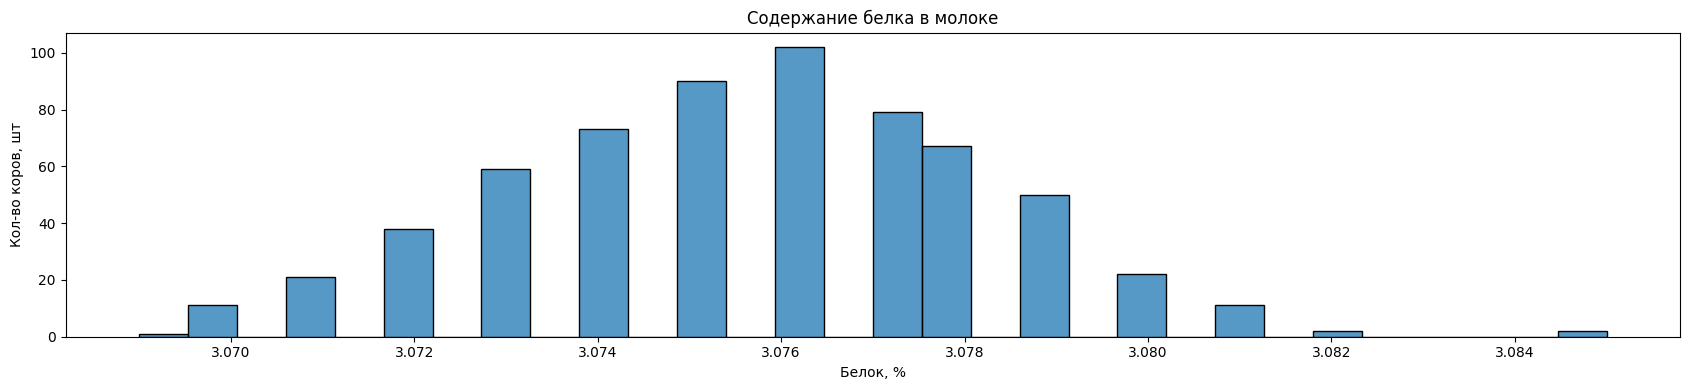

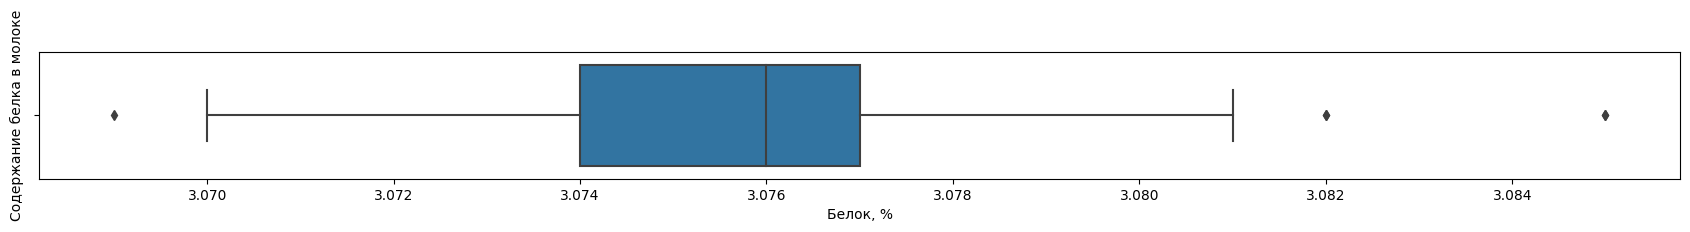

Минимальное значение: 3.069
Левый ус ящика: 3.069
Первый квантиль Q1: 3.074
Медианное значение: 3.076
Третий квантиль Q3: 3.077
Правый ус ящика: 3.082
Максимальное значение: 3.085


In [56]:
# анализ содержания белка в молоке
quantity_func(ferma_main,
              'protein',
              title='Содержание белка в молоке',
              xlabel='Белок, %',
              ylabel='Кол-во коров, шт')

Распределение содержания белка в молоке имеет форму нормального распределения. Есть несколько выбросов слева и справа. Выбросы слева - это молоко с низким, по сравнению с другими, количеством белка. Выбросы справа - наоборот.

#### <font color="braun">Категориальные признаки</font>

Проведем анализ всех категориальных признаков.

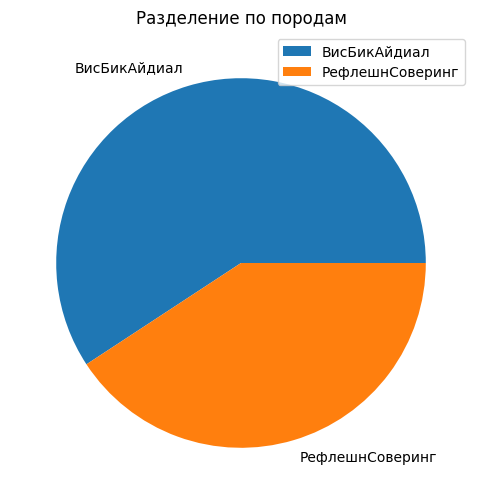

ВисБикАйдиал       372
РефлешнСоверинг    256
Name: breed, dtype: int64


In [57]:
category_func(ferma_main, 'breed', 'Разделение по породам')

Круговая диаграмма пород, укаывает что больше половины имеющихся коров относится к породе ВисБикАйдиал.

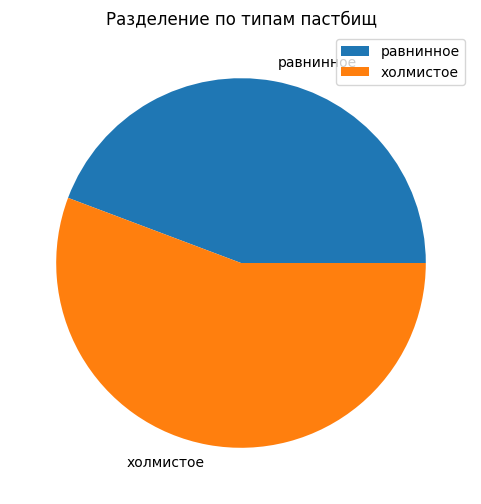

холмистое    350
равнинное    278
Name: pasture_type, dtype: int64


In [58]:
category_func(ferma_main, 'pasture_type', 'Разделение по типам пастбищ')

Круговая диаграмма пастбищ укаывает что больше половины имеющихся коров пасется на холмистых пастбищах, т.е. испытывает бОльшие физические нагрузки.

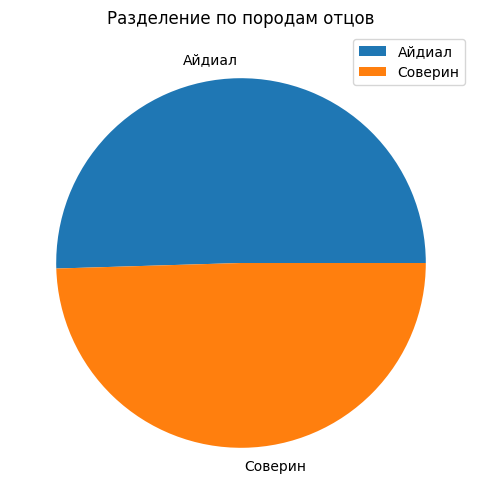

Айдиал     317
Соверин    311
Name: dad_breed, dtype: int64


In [59]:
category_func(ferma_main, 'dad_breed', 'Разделение по породам отцов')

Круговая диаграмма пород отцов укаывает что их примерно поровну на все стадо.

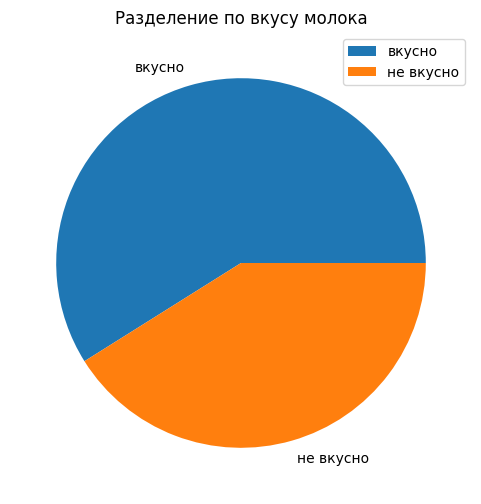

вкусно       370
не вкусно    258
Name: milk_flavor, dtype: int64


In [60]:
category_func(ferma_main, 'milk_flavor', 'Разделение по вкусу молока')

Круговая диаграмма вкуса молока указывает что у больше половины коров молоко вкусное.

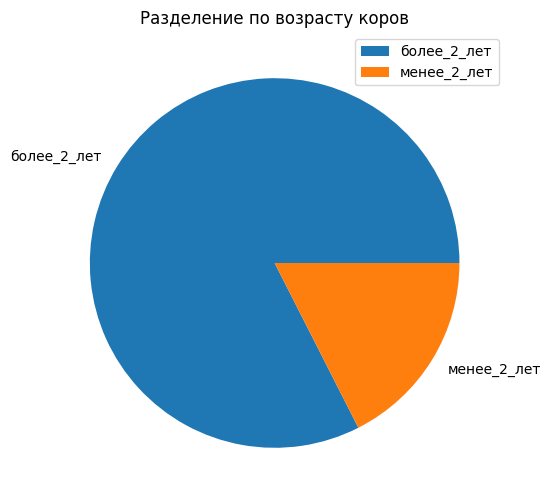

более_2_лет    518
менее_2_лет    110
Name: age, dtype: int64


In [61]:
category_func(ferma_main, 'age', 'Разделение по возрасту коров')

Круговая диаграмма возраста укаывает что более чем три четверти коров имеют возраст старше двух лет.

### <font color="darkred">Вывод по разделу</font>

В данном разделе был проведен исследовательский анализ данных. Исходя из построенных графиков, можно сказать следующее:
- Распределение СПО разделено на две или три группы. Возможно так выделяются разные сорта кормов. Выбросов нет, но вторая группа более масштабна, что дополнительно подтверждается и медианным значением.
- Распределение жирности делится на две группы. Первая группа с жирностью в районе чуть больше 3.6 %, вторая в районе чуть больше 3.7 %. Их общее количество примерно равно. Так же выяснено, что есть много выбросов слева. Как минимум 52 коровы из 110 возрастом менее 2 лет находятся в этом выбросе.
- Распределение содержания белка в молоке имеет выбросы слева и справа. Одна корова с низким показателем (выброс слева) удалена из датафрейма.

---
## <font color="darkblue">Корреляционный анализ</font>

### <font color="darkgreen">Взаимосвязи признаков</font>

Для оценки взаимосвязи между различными признаками, построим матрицу корреляции.

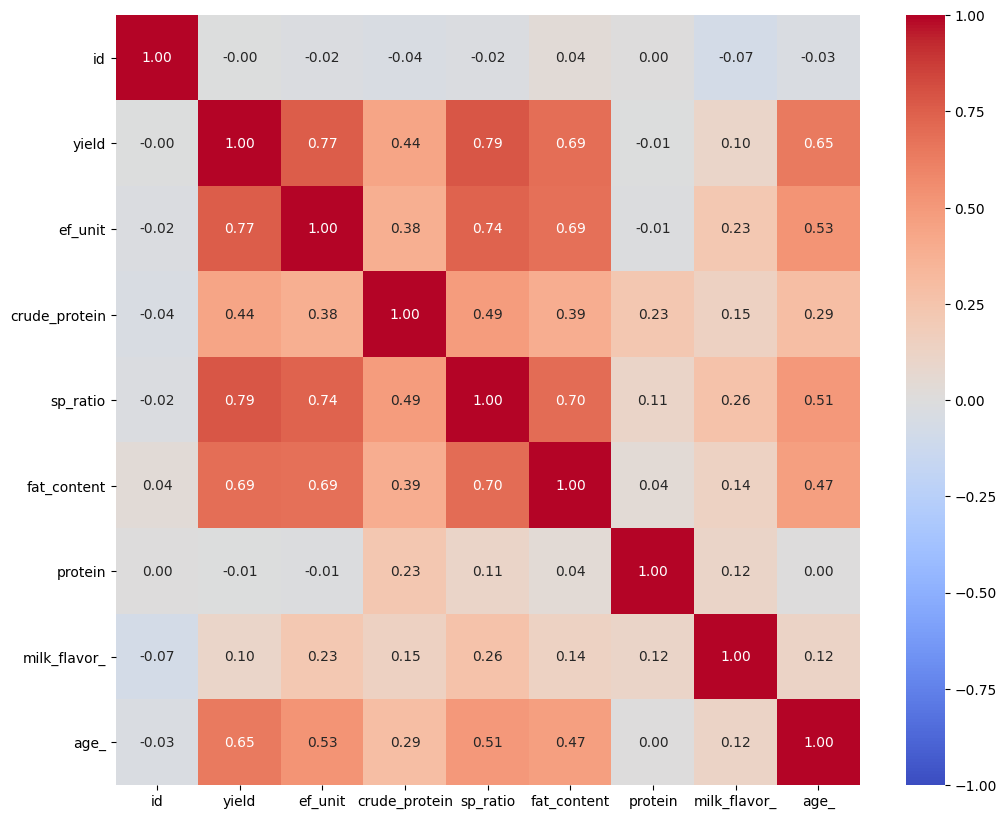

In [62]:
# построим матрицу корреляции Спирмена
plt.figure(figsize=(12, 10))
sns.heatmap(ferma_main.corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1);

Целевой признак `yield`:
- сильная корреляция с `sp_ratio` - 0.79;
- сильная корреляция с `ef_unit` - 0.77;
- умеренная корреляция с `fat_content` - 0.69;
- умеренная корреляция с `age_` - 0.65;
- слабая корреляция с `crude_protein` - 0.44;
- практически отсутствует корреляция с `milk_flavor` - 0.10;
- отсутствует корреляция с `protein` - -0.01.

Корреляция между входными признаками:
- `ef_unit` и `sp_ratio` - 0.74;
- `ef_unit` и `fat_content` - 0.69;
- `sp_ratio` и `fat_content` - 0.70.

Мультиколлинеарность (0.9 и более) между входными признаками отсутствует.

### <font color="darkgreen">Диаграммы рассеяния</font>

Построим диаграммы рассеяния целевого признака `Удой` со всеми количественными признаками по убыванию корреляции, выявленной в предыдущем разделе.

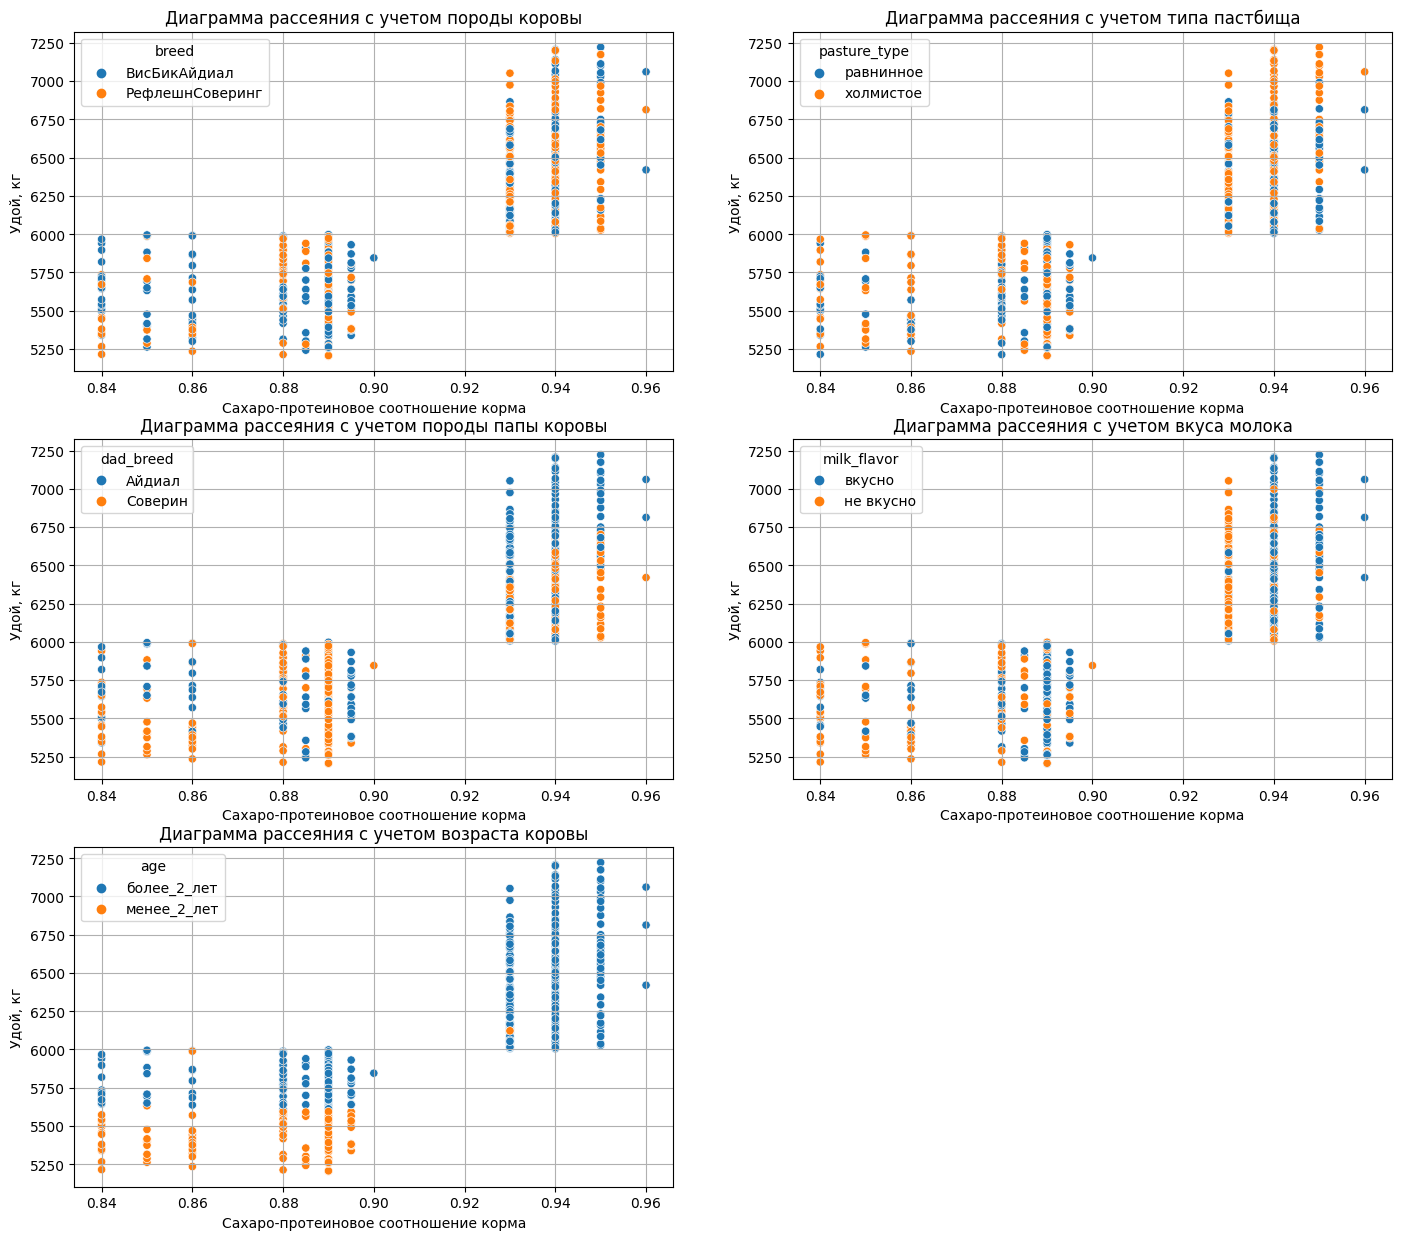

In [63]:
# диаграммы рассеяния для sp_ratio
scatter_func(ferma_main,
             'sp_ratio',
             'yield',
             'Диаграмма рассеяния',
             'Сахаро-протеиновое соотношение корма',
             'Удой, кг')

Среди данных диаграмм можно заметить нелинейную зависимость. Данные разделяются на две области и судя по последней диаграмме, можно предположить что это разные типы кормов. Для молодых коров используется только условно 1 корм (СПО 0.84-0.89), а основная масса коров старше 2 лет употребляет корм 2 (СПО 0.93-0.95).

Дополнительно можно выделить следующие моменты:
- порода папы коровы Айдиал дает больший удой при использвании корма 2;
- молоко вкунее при использовании корма 2;
- как уже отмечалось, молодых коров кормят корммом 1.

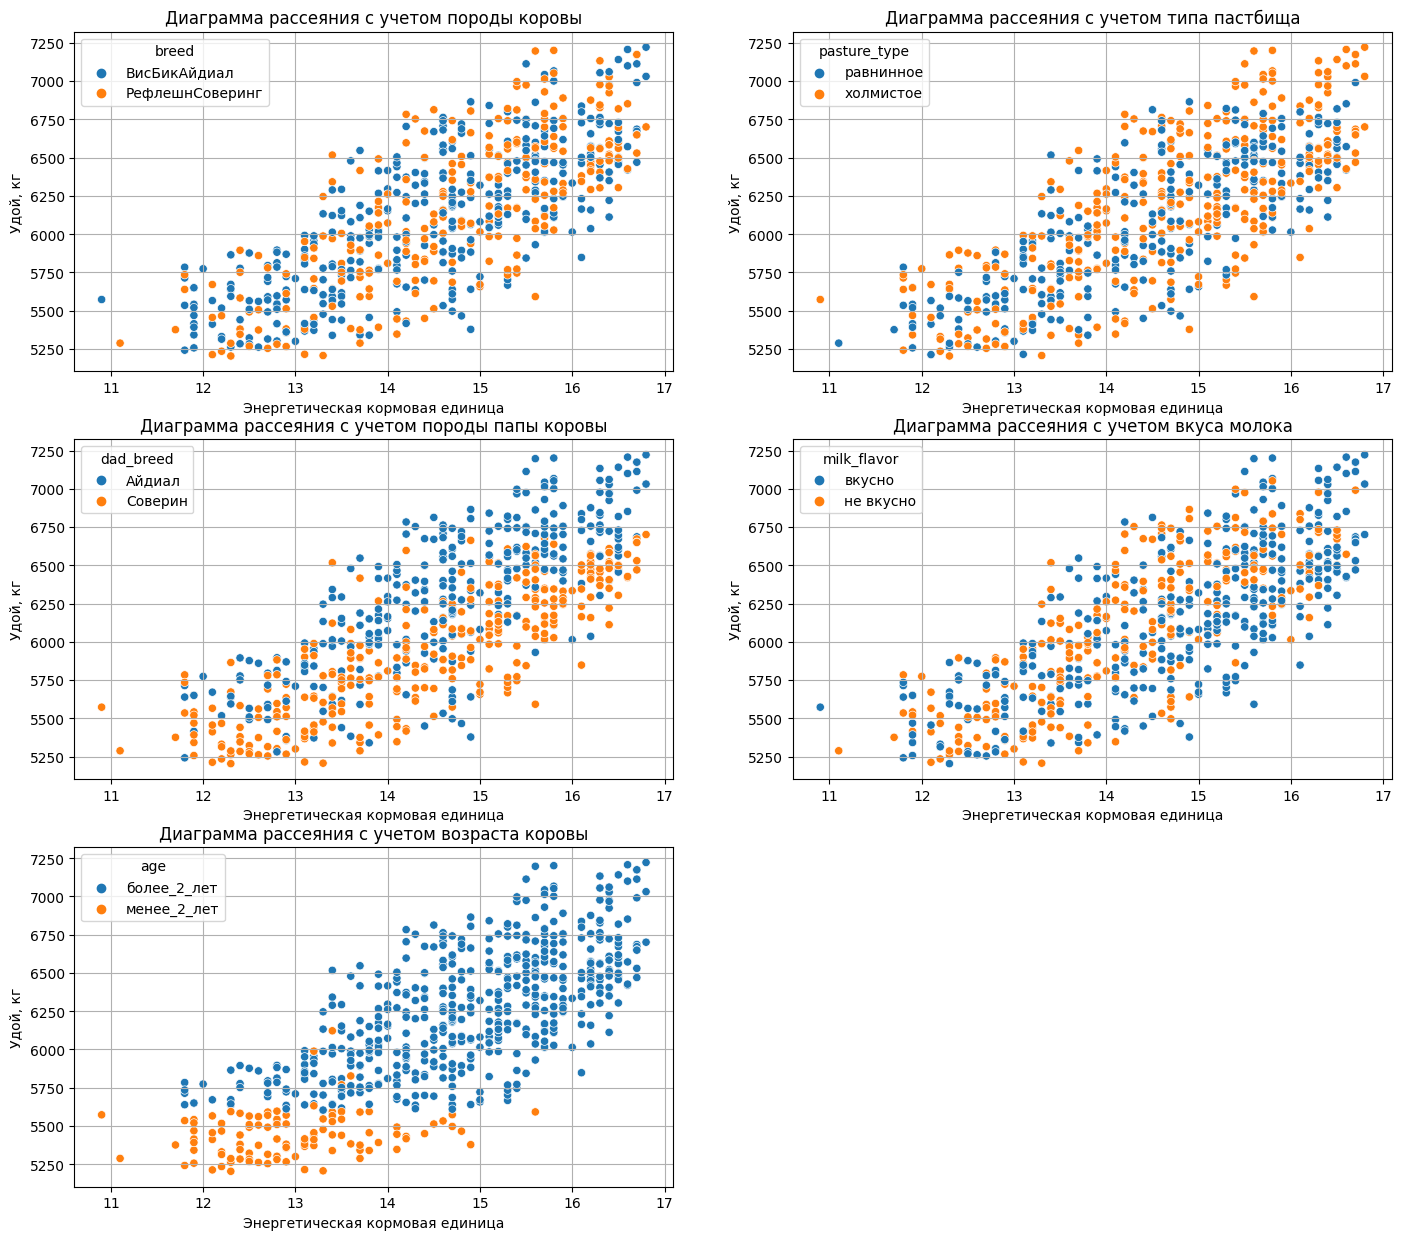

In [64]:
# диаграммы рассеяния для ef_unit
scatter_func(ferma_main,
             'ef_unit',
             'yield',
             'Диаграмма рассеяния',
             'Энергетическая кормовая единица',
             'Удой, кг')

По данным диаграммам, видна положительная нелинейная зависимость удоя от ЭКЕ с небольшим изгибом. Четче всего она выделяется на диаграмме породы папы коров, там Айдиал дает больший удой и концентрация более плотная. На диаграмме возрастов, у коров с возрастом менее 2 лет корреляции удоя с ЭКЕ нет. На остальных диаграммах корреляция заметна, но она сильно рассеяна.

In [65]:
# диаграммы рассеяния для age
#scatter_func(ferma_main,
#             'age',
#             'yield',
#             'Диаграмма рассеяния',
#             'Возраст коровы',
#             'Удой, кг')

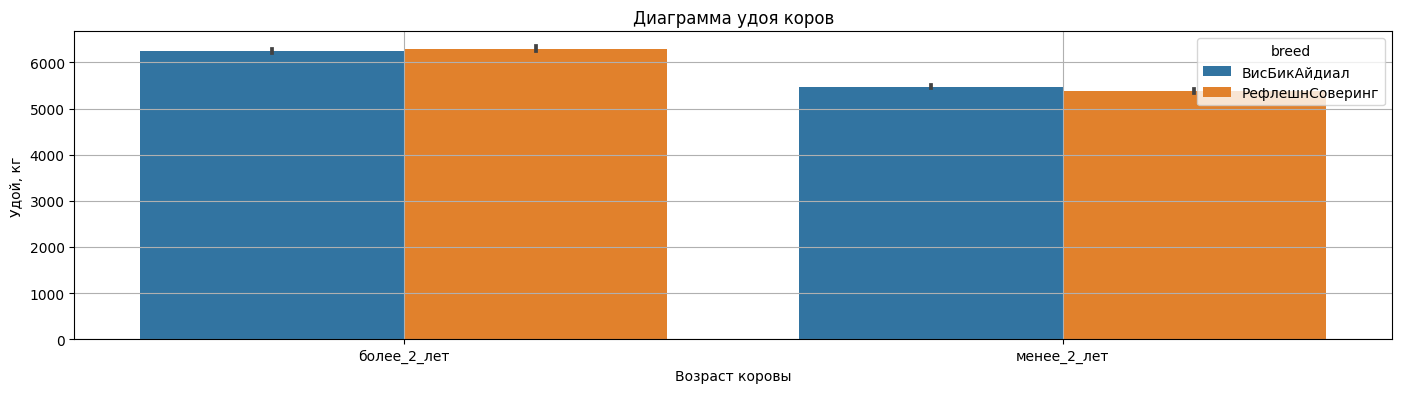

In [66]:
# построим диаграмму удоя коров в зависимости от породы
plt.figure(figsize=(17, 4))
sns.barplot(data=ferma_main, x='age', y='yield', hue='breed')
plt.grid(True)
plt.title('Диаграмма удоя коров')
plt.xlabel('Возраст коровы')
plt.ylabel('Удой, кг');

На диаграмме видим следующее:
- с возрастом, коровы дают больше молока, независимо от породы, но в данном случае в приоритете порода РефлешнСоверинг.

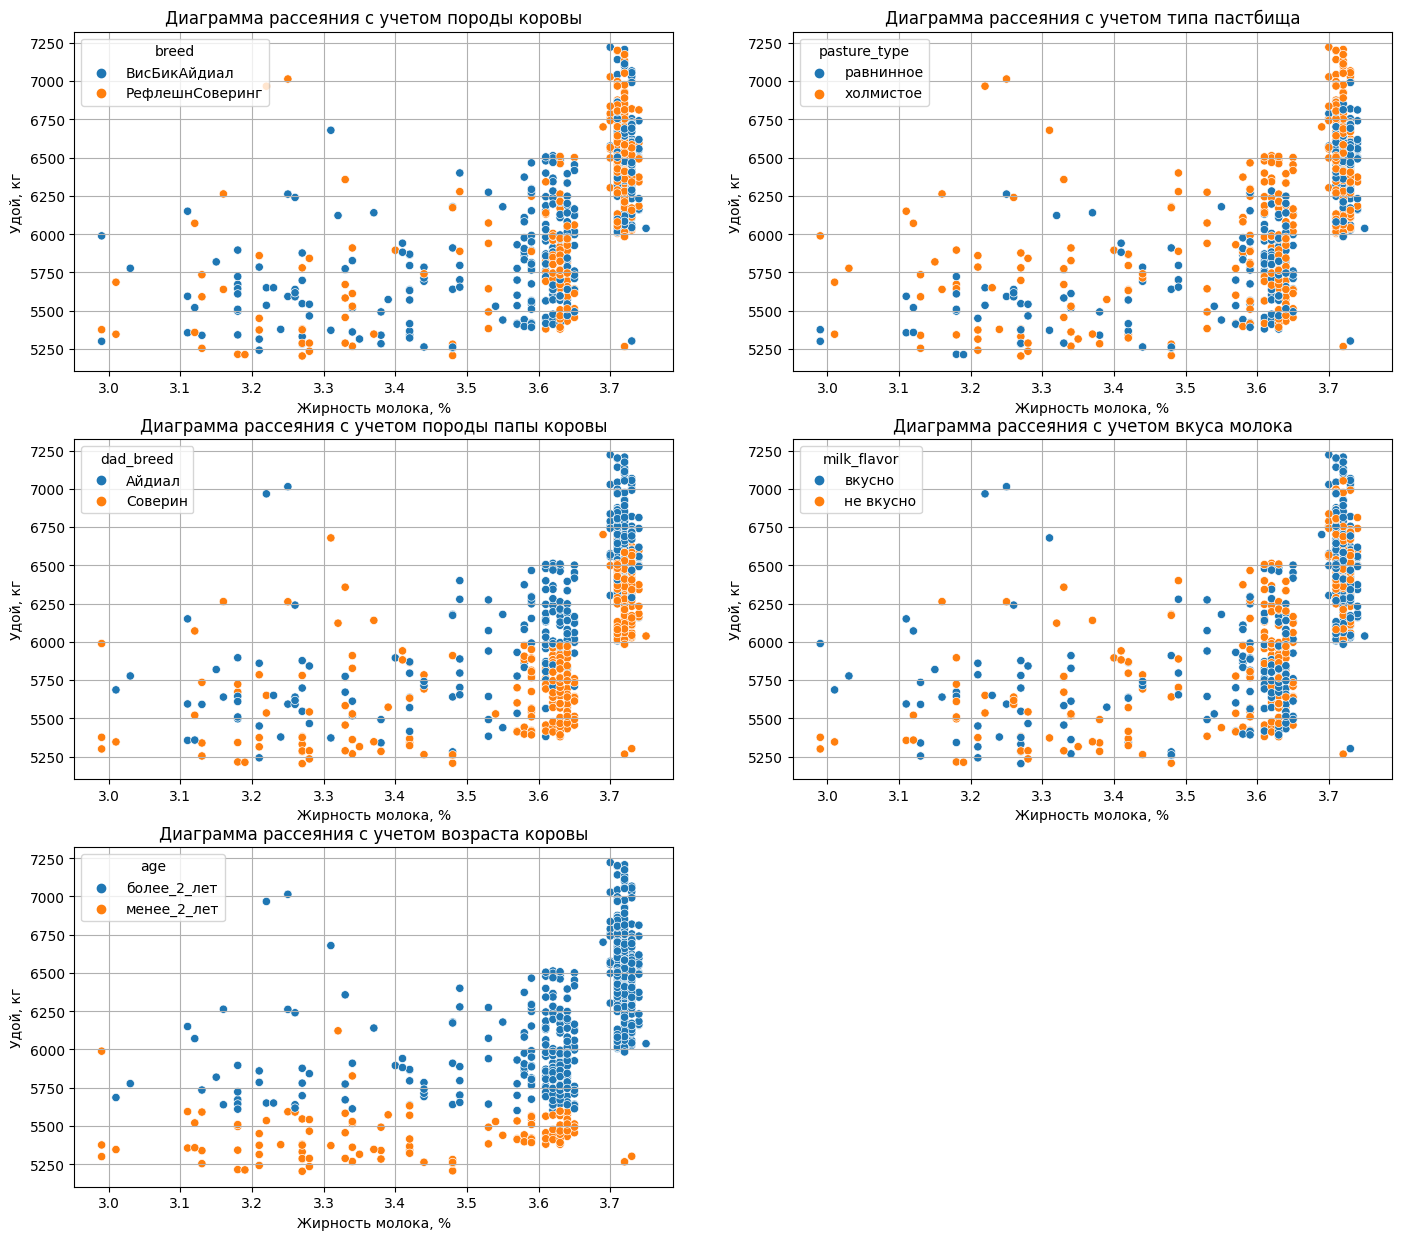

In [67]:
# диаграммы рассеяния для fat_content
scatter_func(ferma_main,
             'fat_content',
             'yield',
             'Диаграмма рассеяния',
             'Жирность молока, %',
             'Удой, кг')

Диаграмма зависимости удоя от жирности показывает прямую положительную зависимость для жирности от 3.6 % и более. С меньшей жирностью зависимость отсутствует:
- больший удой у коров с породой папы Айдиал независимо от жирности;
- больший удой у коров старше 2 лет независимо от жирности.

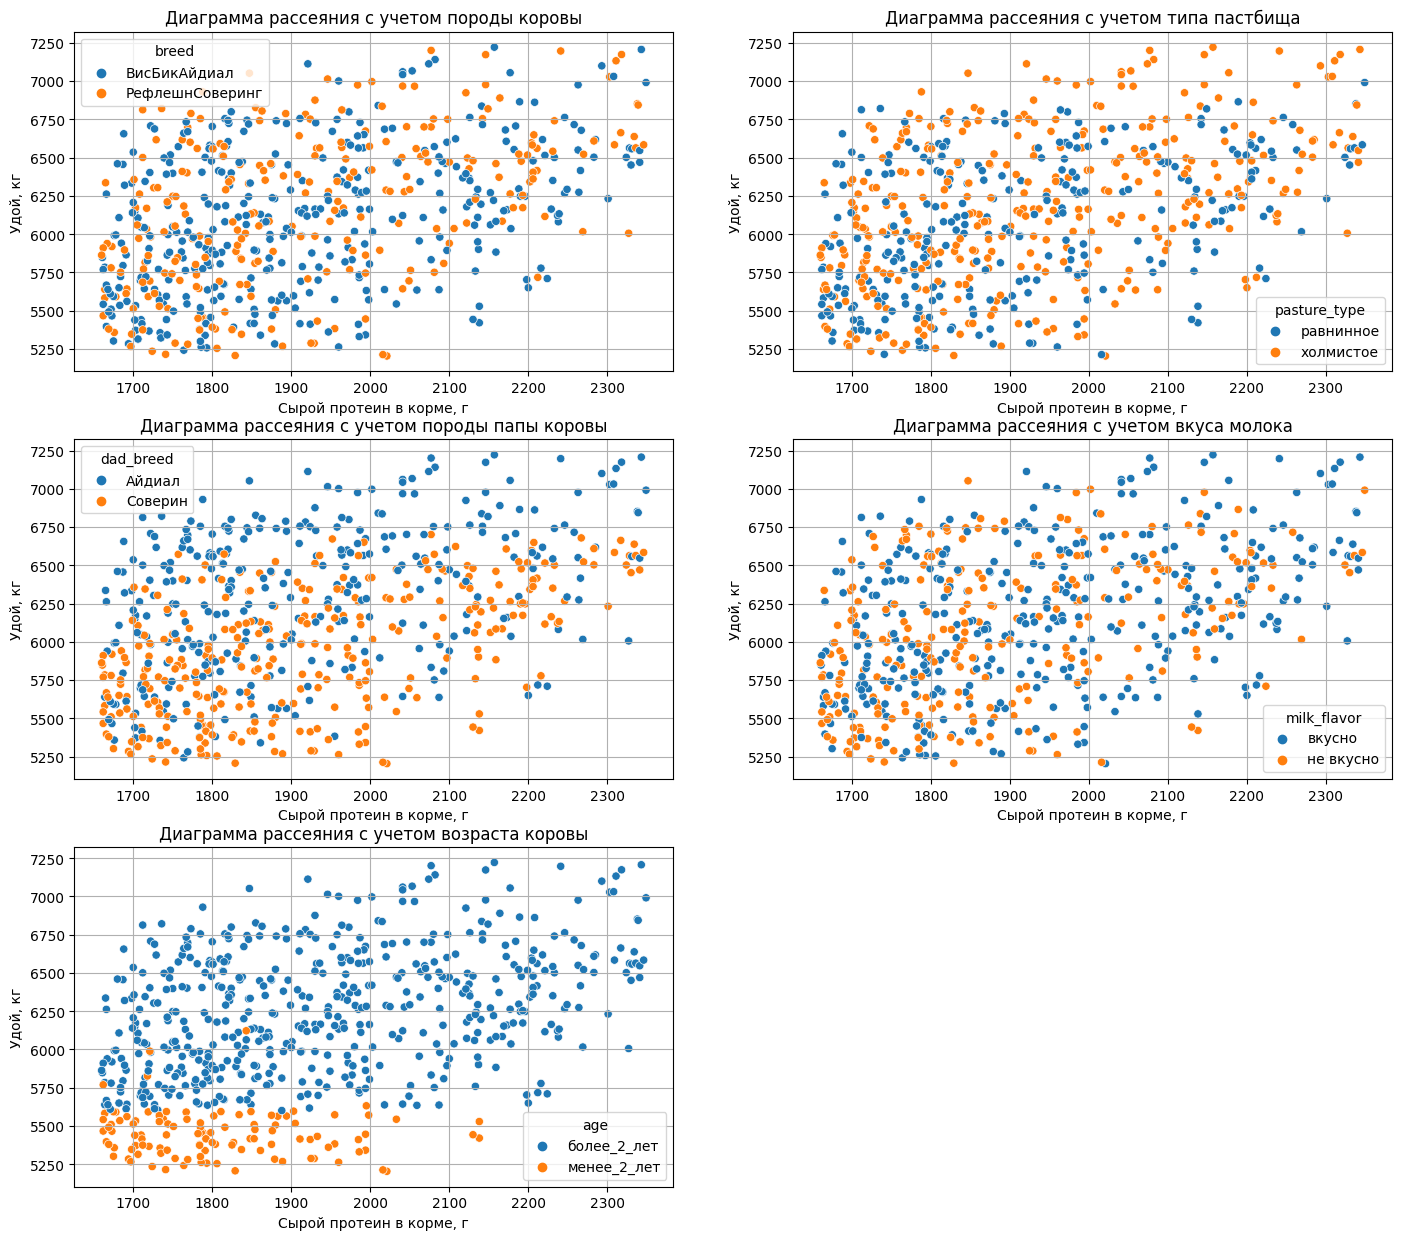

In [68]:
# диаграммы рассеяния для crude_protein
scatter_func(ferma_main,
             'crude_protein',
             'yield',
             'Диаграмма рассеяния',
             'Сырой протеин в корме, г',
             'Удой, кг')

Диаграммы зависимости удоя от сырого протеина в корме:
- больший удой у коров старше 2 лет, но зависимость слабая, диаграмма с сильным рассеянием;
- остальные диаграммы с сильным рассеянием, явная зависимость не наблюдается.

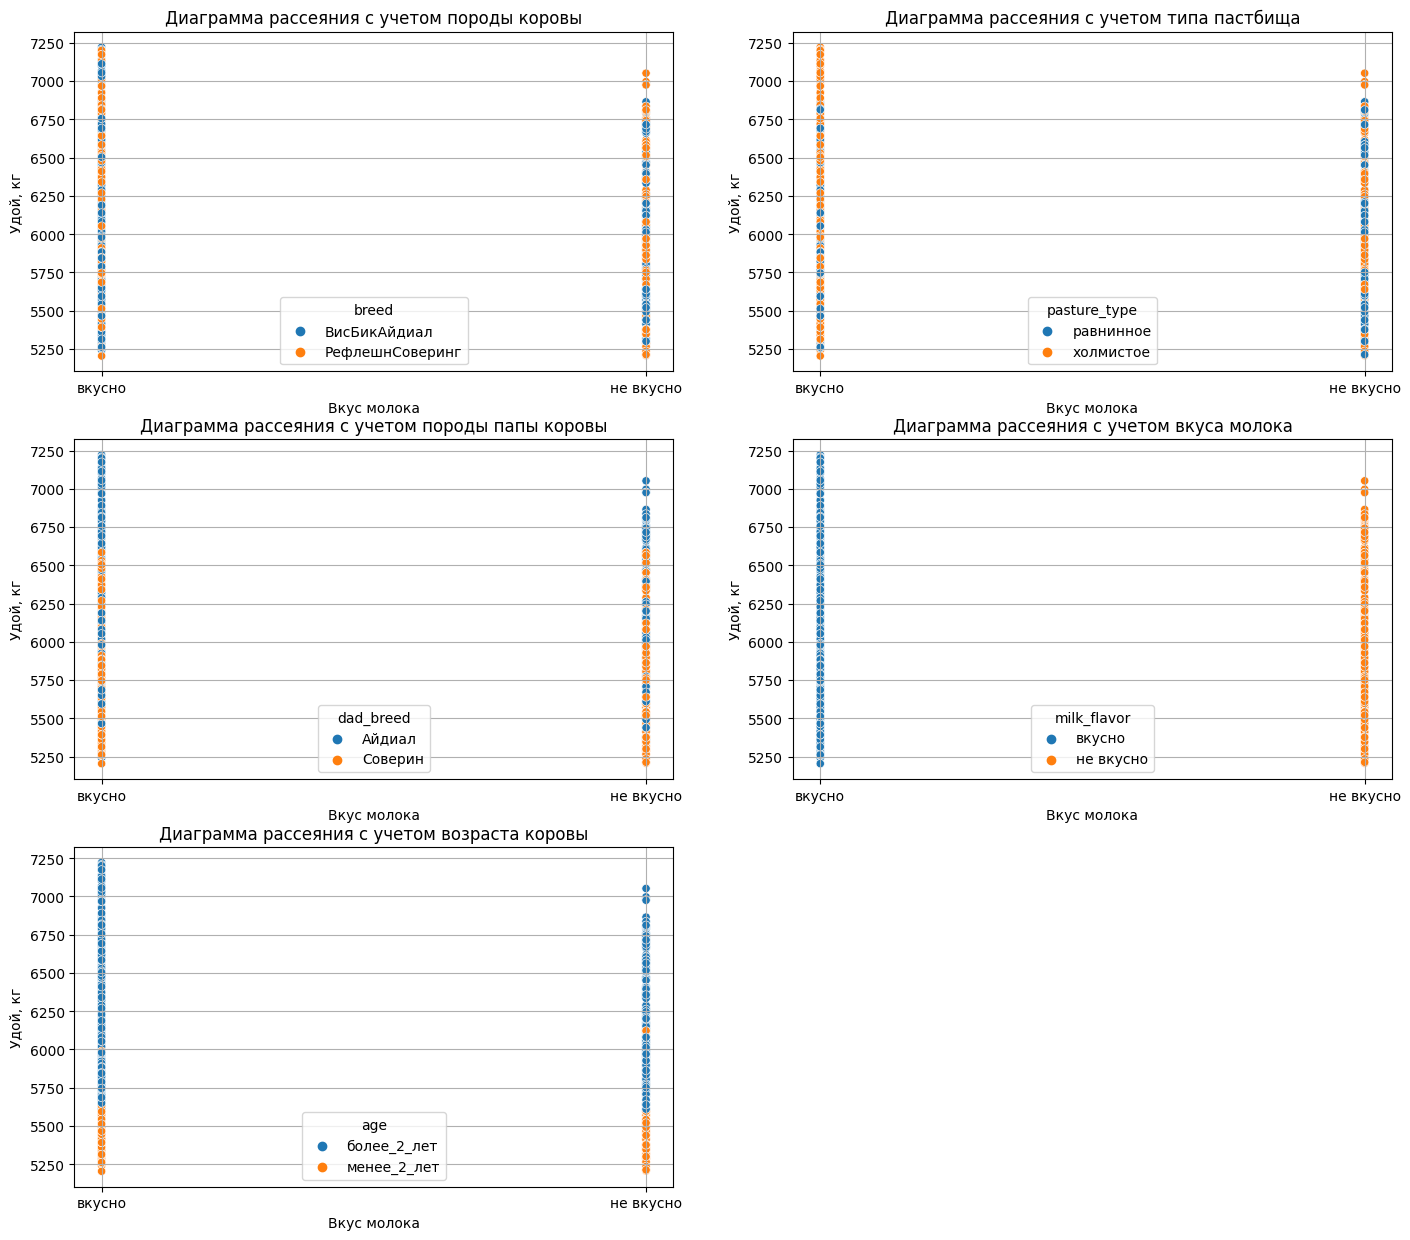

In [69]:
# диаграммы рассеяния для milk_flavor
scatter_func(ferma_main,
             'milk_flavor',
             'yield',
             'Диаграмма рассеяния',
             'Вкус молока',
             'Удой, кг')

Диаграммы зависимости удоя от вкуса молока показывают отсутствие зависимости по каким-либо признакам.

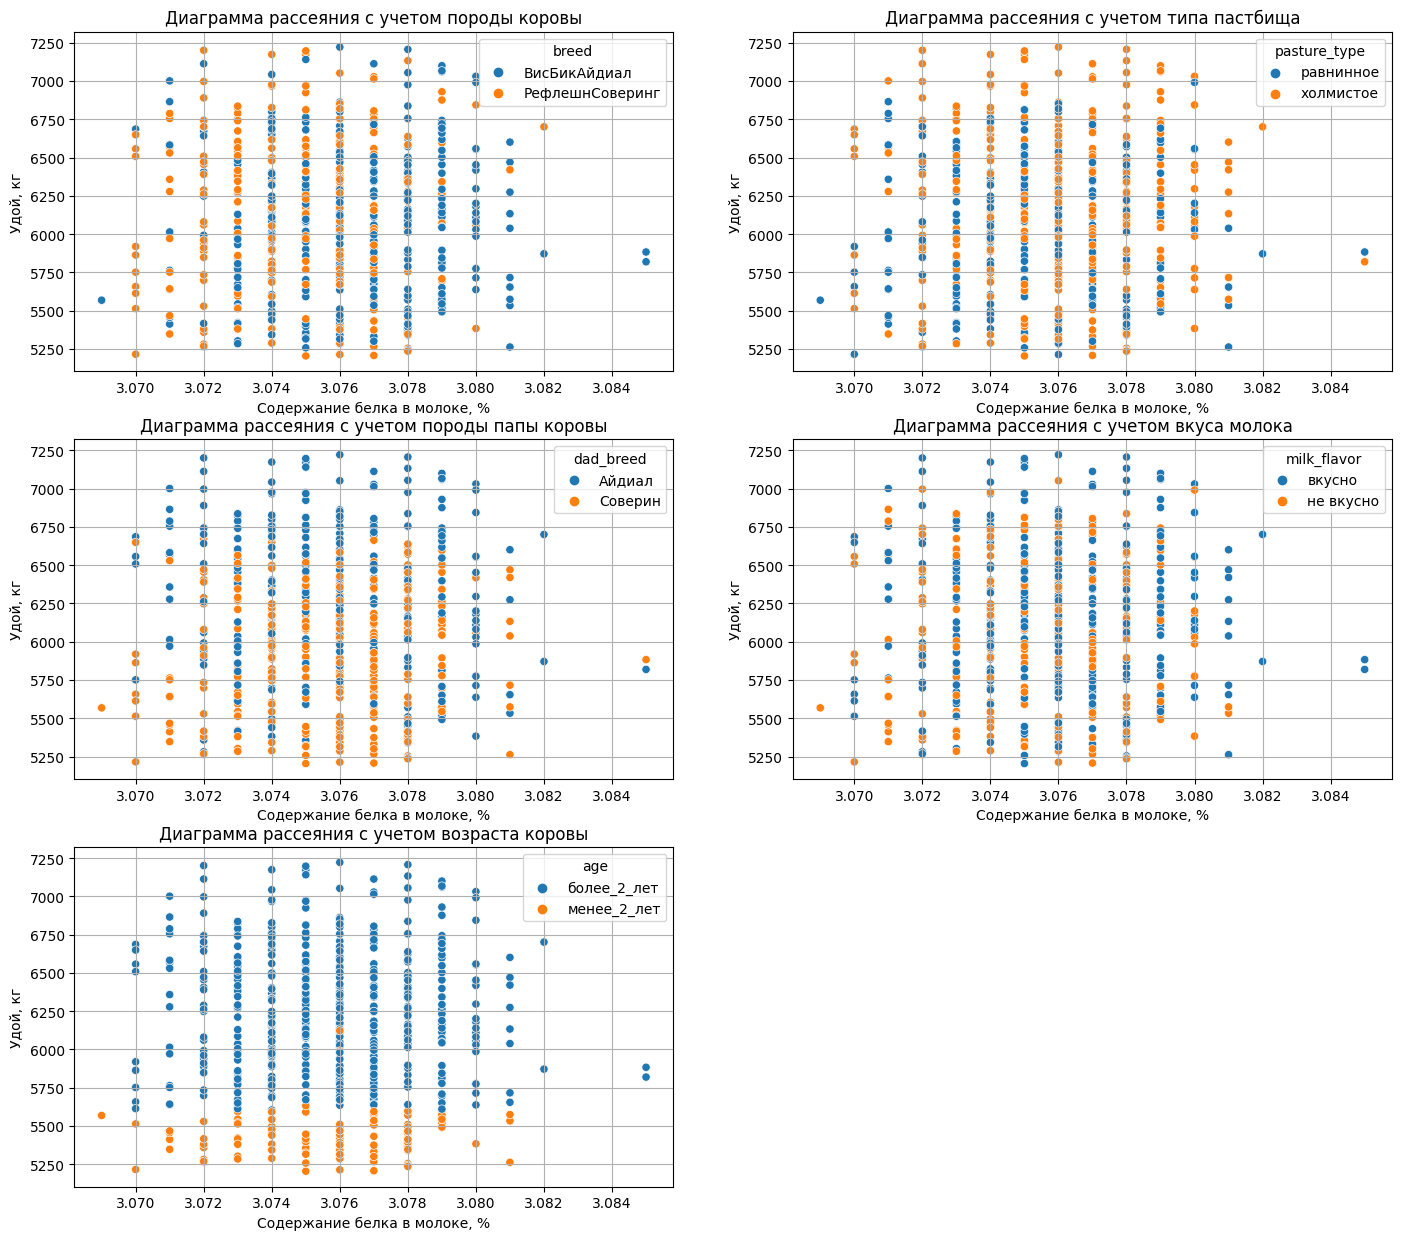

In [70]:
# диаграммы рассеяния для protein
scatter_func(ferma_main,
             'protein',
             'yield',
             'Диаграмма рассеяния',
             'Содержание белка в молоке, %',
             'Удой, кг')

Диаграммы зависимости удоя от содержания белка в молоке практически не имеют зависимости:
- у коров породы ВисБикАйдиал содержание белка, как правило, выше;
- порода папы быка Айдиал, как правило, имеет высокий удой независимо от содержания белка.

In [71]:
# выведем строчку датафрейма
ferma_main.head(1)

id  yield  ef_unit  crude_protein  sp_ratio         breed pasture_type  \
0   1   5863     14.2           1743      0.89  ВисБикАйдиал    равнинное   

  dad_breed  fat_content  protein milk_flavor          age  milk_flavor_  age_  
0    Айдиал         3.58    3.076      вкусно  более_2_лет             1     1

In [72]:
# добавим константы для перехвата только для количественных внешних признаков
XX = add_constant(ferma_main.drop([
    'yield',
    'breed',
    'pasture_type',
    'dad_breed',
    'milk_flavor',
    'age',
    'milk_flavor_',
    'age_'], axis=1))

# расчет VIF для каждого предиктора
VIFs = pd.DataFrame()
VIFs['variable'] = XX.columns
VIFs['VIF'] = [variance_inflation_factor(XX.values, i) for i in range(XX.shape[1])]
VIFs

variable           VIF
0          const  1.566376e+06
1             id  1.010531e+00
2        ef_unit  2.570463e+00
3  crude_protein  1.343398e+00
4       sp_ratio  2.662499e+00
5    fat_content  1.885406e+00
6        protein  1.079672e+00

Изучив результаты VIF для каждой переменной и учитывая что значения меньше 5, можем еще раз подтвердить, что мультиколлинеарность у внешних признаков отсутствует.

### <font color="darkred">Вывод по разделу</font>

В данном разделе проведен корреляционный анализ данных. Построена матрица корреляции, из которой выявили следующие основные корреляции к целевому признаку `yield`:
- сильная корреляция с `sp_ratio` - 0.79;
- сильная корреляция с `ef_unit` - 0.77;
- умеренная корреляция с `fat_content` - 0.69;
- умеренная корреляция с `age_` - 0.65;
- слабая корреляция с `crude_protein` - 0.44.

Корреляция между входными признаками:
- `ef_unit` и `sp_ratio` - 0.74;
- `ef_unit` и `fat_content` - 0.69;
- `sp_ratio` и `fat_content` - 0.70.

Мультиколлинеарность (0.9 и более) между входными признаками отсутствует.

По диаграмме СПО видим, что зависимость нелинейная, данные разделены на две группы. Предполагается разделение по типам кормов: для коров возрастом менее 2 лет используется корм с СПО 0.84-0.89, для коров возрастом более 2 лет корм с СПО 0.93-0.95.

Дополнительно выделили следующие моменты:
- порода папы коровы Айдиал дает больший удой при использвании корма 2;
- молоко вкунее при использовании корма 2.

Выявлена нелинейная зависимость удоя от ЭКЕ с небольшим изгибом. У коров с возрастом менее 2 лет корреляции удоя с ЭКЕ нет.

На диаграммах зависимости удоя от возраста коров, видим следующее:
- порода коровы РефлешнСоверинг с возрастом дает больший удой;
- холмистые пастбища дают больший удой для коров старше 2 лет (хотя это скорее всего по причине того, что молодых коров не выпускают на холмистые пастбища);
- у коров с возрастом более 2 лет молоко вкуснее.

Удой от жирности напрямую зависит для жирности от 3.6 % и более:
- больший удой у коров с породой папы Айдиал;
- больший удой у коров старше 2 лет.

Зависимость удоя от сырого протеина в корме:
- больший удой у коров старше 2 лет, но зависимость слабая, диаграмма с сильным рассеянием.

Диаграммы зависимости удоя от содержания белка в молоке практически не имеют зависимости:
- у коров породы ВисБикАйдиал содержание белка, как правило, выше;
- порода папы быка Айдиал, как правило, имеет высокий удой независимо от содержания белка.

---

## <font color="darkblue">Обучение модели линейной регрессии</font>

Целевой признак `yield` - удой, кг.

Исходя из матрицы корреляции, удой коров в большей степени зависит от корма и его характеристик, а так же от возраста коровы и ее генетики. Так же зависит от того, на каких пастбищах корова проводит время. Жирность молока, его вкус и содержание белка - это уже производные от корма. Поэтому отберем следующие признаки.
- sp_ratio - характеристика корма;
- ef_unit - характеристика корма;
- fat_content - характеристика корма;
- crude_protein - характеристика корма;
- age - характеристика коровы;
- breed - характеристика коровы;
- dad_breed - характеристика коровы;
- pasture_type - характеристика пастбищ.

### <font color="darkgreen">Первая модель `LinearRegression`</font>

Проведем обучение первой модели линейной регрессии.

#### <font color="braun">Отбор признаков</font>

Отберем признаки: удалим ненужные, сохраним целевой и входные признаки в переменных.

In [73]:
ferma_main.head(1)

id  yield  ef_unit  crude_protein  sp_ratio         breed pasture_type  \
0   1   5863     14.2           1743      0.89  ВисБикАйдиал    равнинное   

  dad_breed  fat_content  protein milk_flavor          age  milk_flavor_  age_  
0    Айдиал         3.58    3.076      вкусно  более_2_лет             1     1

In [74]:
# удалим ненужные столбцы
ferma_main_1 = ferma_main.drop(['id', 'protein', 'milk_flavor', 'milk_flavor_', 'age_', 'fat_content'], axis=1)
# сохранение входных признаков
X = ferma_main_1.drop('yield', axis=1)
# сохранение целевого признака
y = ferma_main_1['yield']

In [75]:
ferma_main_1.head(1)

yield  ef_unit  crude_protein  sp_ratio         breed pasture_type  \
0   5863     14.2           1743      0.89  ВисБикАйдиал    равнинное   

  dad_breed          age  
0    Айдиал  более_2_лет

#### <font color="braun">Разбиение данных</font>

Разобьем данные на тренировочные и тестовые.

In [76]:
# создание константы
RANDOM_STATE = 42

# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

#### <font color="braun">Кодирование</font>

Выполним подготовку категориальных признаков используя метод кодирования `OneHotEncoding`.

In [77]:
# выбор метода кодирования, его инициализация
encoder = OneHotEncoder(drop='first', sparse_output=False)
# список всех категориальных признаков из тренировочной выборки
cat_col_names = ['breed', 'pasture_type', 'dad_breed', 'age']
# обучение и преобразование категориальных признаков из тренировочной выборки
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
# преобразование категориальных признаков из тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names])
# сохранение в переменной новых столбцов
encoder_col_names = encoder.get_feature_names_out()
# создание датафреймов из закодированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

# проверим кодированные данные
X_train_ohe.head(3)

breed_РефлешнСоверинг  pasture_type_холмистое  dad_breed_Соверин  \
0                    1.0                     1.0                1.0   
1                    1.0                     1.0                1.0   
2                    0.0                     0.0                0.0   

   age_менее_2_лет  
0              0.0  
1              1.0  
2              0.0

#### <font color="braun">Масштабирование</font>

Выполним масштабирование количественных признаков, используя `стандартизацию` (когда стандартное отклонение признаков равно единице, а среднее значение равно нулю).

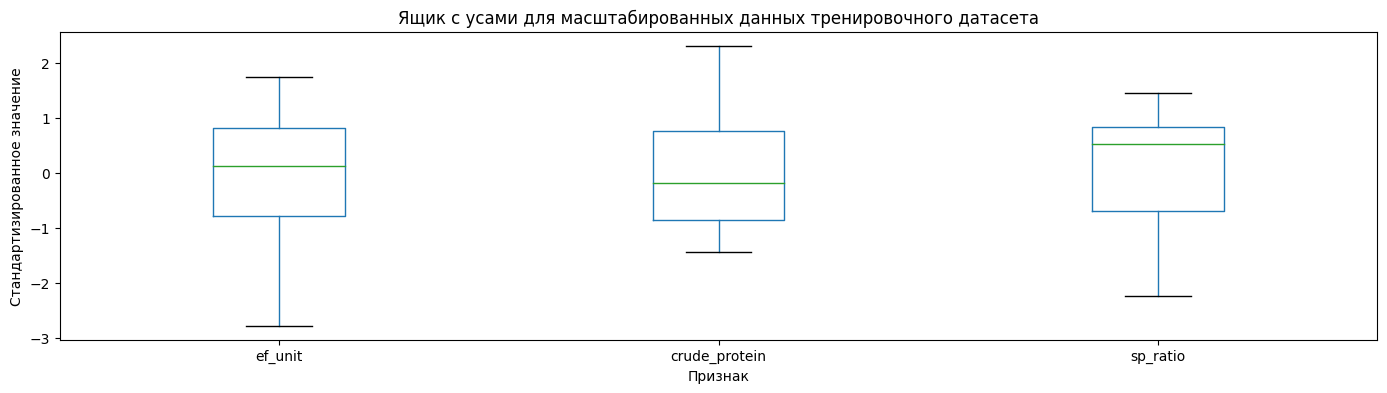

In [78]:
# определяем метод масштабирования
scaler = StandardScaler()
# список всех количественных признаков из тренировочной выборки
quant_col_names = ['ef_unit', 'crude_protein', 'sp_ratio']
# обучение и масштабирование количественных признаков тренировочной выборки
X_train_scaler = scaler.fit_transform(X_train[quant_col_names])
# масштабирование количественных признаков тестовой выборки
X_test_scaler = scaler.transform(X_test[quant_col_names])
# создание датафреймов из масштабированных данных
X_train_scaler = pd.DataFrame(X_train_scaler, columns=quant_col_names)
X_test_scaler = pd.DataFrame(X_test_scaler, columns=quant_col_names)

#  проверим масштабированные данные
X_train_scaler[quant_col_names].plot(kind='box', figsize=(17, 4))
plt.title('Ящик с усами для масштабированных данных тренировочного датасета')
plt.xlabel('Признак')
plt.ylabel('Стандартизированное значение')
plt.show;

#### <font color="braun">Обучение модели</font>

Соберем все преобразованные данные в датафреймы.

In [79]:
# создание датафреймов из масштабировнных и кодированных данных
X_train = pd.concat([X_train_scaler, X_train_ohe], axis=1)
X_test = pd.concat([X_test_scaler, X_test_ohe], axis=1)

In [80]:
# инициализация и обучение модели
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
# предсказанное значение для X_test
predictions_1 = model_lr.predict(X_test)

print(f'Настоящий удой 1 объекта: {y_test.reset_index(drop=True)[1]:.2f}')
print(f'Предсказанный удой 1 объекта: {predictions_1[1]:.2f}')
print(f'Ошибка для 1 объекта: {y_test.reset_index(drop=True)[1] - predictions_1[1]:.2f}')

Настоящий удой 1 объекта: 6512.00
Предсказанный удой 1 объекта: 6433.10
Ошибка для 1 объекта: 78.90


#### <font color="braun">Оценка качества модели</font>

Оценим качество модели на тестовой выборке.

In [81]:
# расчет значения r2
r2_1 = r2_score(y_test, predictions_1)
# расчет других метрик
mse_1 = mean_squared_error(y_test, predictions_1)
mae_1 = mean_absolute_error(y_test, predictions_1)
rmse_1 = root_mean_squared_error(y_test, predictions_1) 

print(f'Коэффициент детерминации R2: {r2_1:.4f}')

Коэффициент детерминации R2: 0.7844


Значение коэффициента близко к единице, модель дает верные предсказания в `78.44 %` случаев.

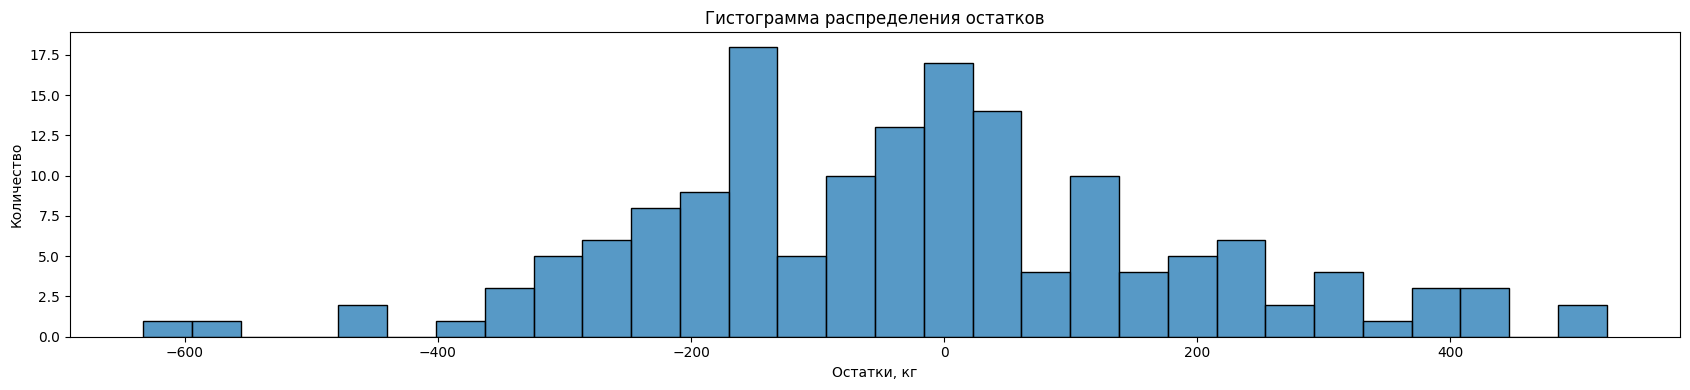

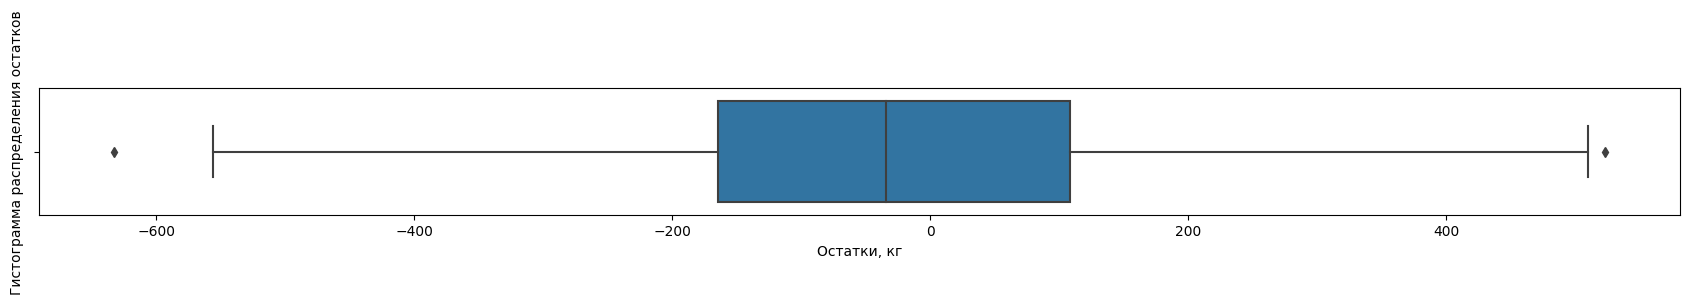

Минимальное значение: -632.814
Левый ус ящика: -573.410
Первый квантиль Q1: -164.146
Медианное значение: -25.373
Третий квантиль Q3: 108.697
Правый ус ящика: 517.960
Максимальное значение: 523.552


In [82]:
# рассчитаем остатки
residuals_1 = y_test - predictions_1
#создадим датафрейм из остатков
residuals_df_1 = pd.DataFrame(residuals_1)
# вызовем созданную ранее функцию
quantity_func(residuals_df_1,
              'yield',
              title='Гистограмма распределения остатков',
              xlabel='Остатки, кг',
              ylabel='Количество')

Распределение близко к нормальному с небольшим смещением влево. Есть выбросы с обоих сторон.

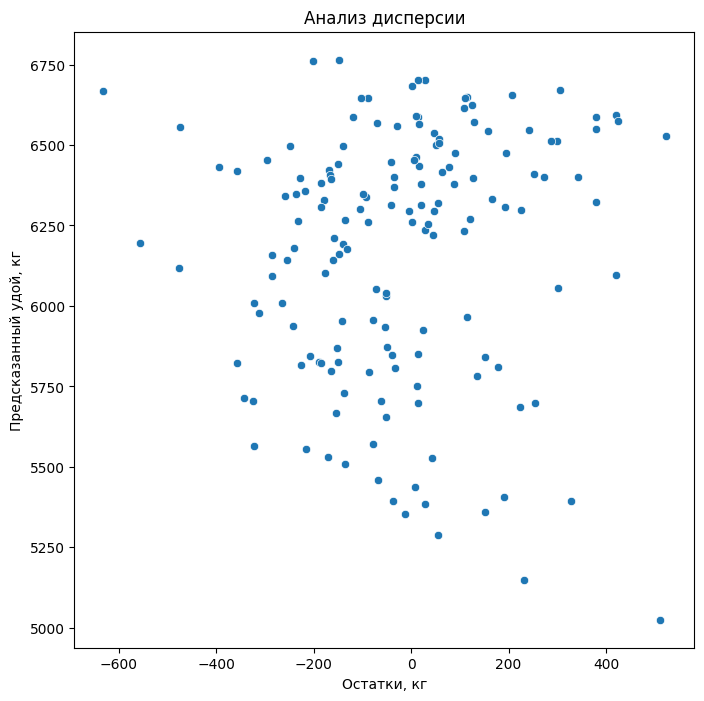

In [83]:
# построим диаграмму рассеяния
plt.figure(figsize=(8, 8))
sns.scatterplot(x=residuals_1, y=predictions_1)
plt.title('Анализ дисперсии')
plt.xlabel('Остатки, кг')
plt.ylabel('Предсказанный удой, кг')
plt.show;

По диаграмме рассеяния можно сказать, что полученная модель при предсказании больших удоев (то что необходимо фермеру), дает больший процент ошибок. Для улучшения модели необходимы дополнительные данные.

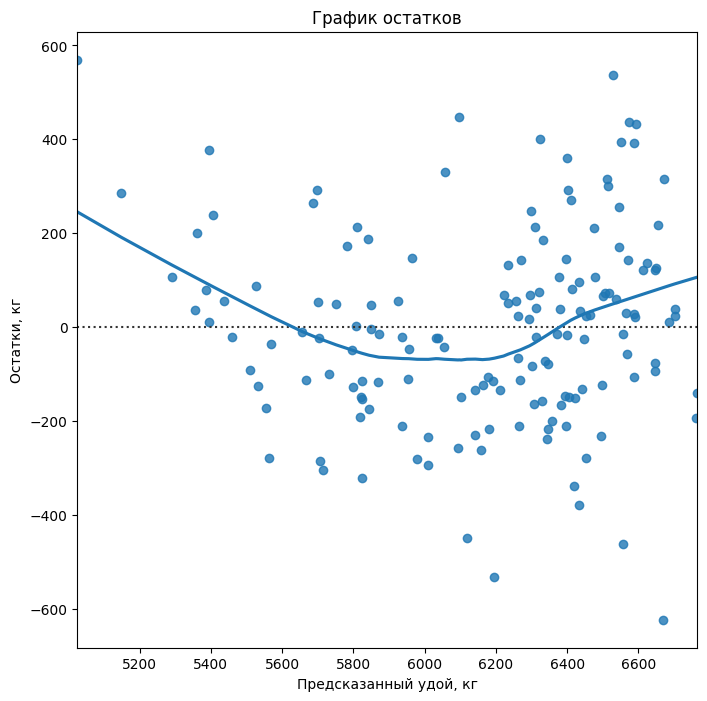

In [84]:
# визуализируем остатки
plt.figure(figsize=(8, 8))
sns.residplot(x=predictions_1,
              y=residuals_1,
              lowess=True
             )
plt.title('График остатков')
plt.xlabel('Предсказанный удой, кг')
plt.ylabel('Остатки, кг')
plt.show;

#### <font color="darkred">Вывод по подразделу</font>

Отобрали необходимые признаки. Разбили данные, провели кодирование и масштабирование. Обучили модель, сделали предсказание и вычислили ошибку - `78.90` кг. Оценили качество модели по коэффициенту детерминации - `0.7844`. Построили гистограмму распределения остатков и провели анализ дисперсии. Полученная модель дает больший процент ошибок при предсказании больших удоев.

---


### <font color="darkgreen">Вторая модель `LinearRegression`</font>

Проведем обучение второй модели линейной регрессии.

#### <font color="braun">Анализ диаграмм рассеяния</font>

Проведем анализ диаграмм рассеяния.

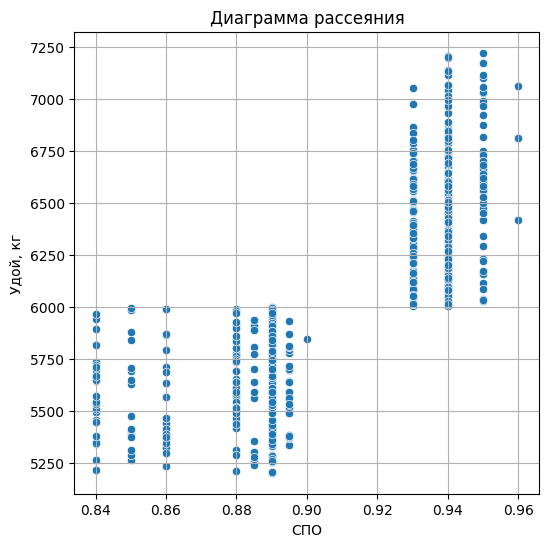

In [85]:
# сделаем копию датафрейма и построим диаграмму рассеяния
ferma_main_2 = ferma_main.copy()
plt.figure(figsize=(6, 6))
sns.scatterplot(data=ferma_main_2, x='sp_ratio', y='yield')
plt.grid(True)
plt.title('Диаграмма рассеяния')
plt.xlabel('СПО')
plt.ylabel('Удой, кг')
plt.show;

Исходя из диаграммы, есть четкая граница по которой можно провести разделение на две группы = 0.92. Создадим дополнительный бинарный категорийный признак.

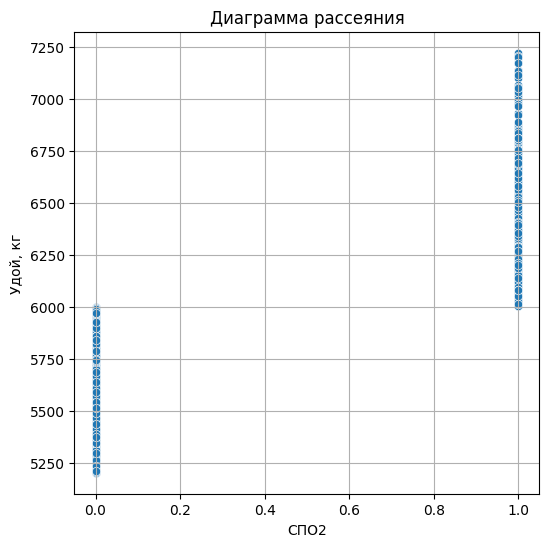

In [86]:
# создадим дополнительный признак и построим диаграмму еще раз
ferma_main_2['sp_ratio_'] = (ferma_main_2['sp_ratio'] >= 0.92).astype('int8')
plt.figure(figsize=(6, 6))
sns.scatterplot(data=ferma_main_2, x='sp_ratio_', y='yield')
plt.grid(True)
plt.title('Диаграмма рассеяния')
plt.xlabel('СПО2')
plt.ylabel('Удой, кг')
plt.show;

СПО разделено на две группы.

Построим распределение между ЭКЕ и Удоем.

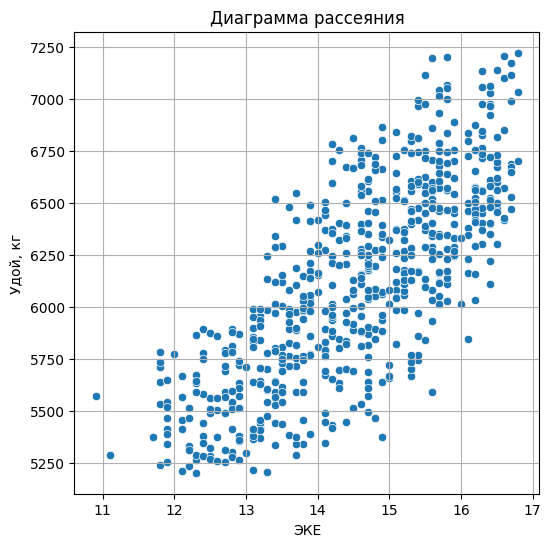

In [87]:
# построим диаграмму
plt.figure(figsize=(6, 6))
sns.scatterplot(data=ferma_main_2, x='ef_unit', y='yield')
plt.grid(True)
plt.title('Диаграмма рассеяния')
plt.xlabel('ЭКЕ')
plt.ylabel('Удой, кг')
plt.show;

Видна нелинейная зависимость, попробуем устранить нелинейность, возведя ЭКЕ в квадрат.

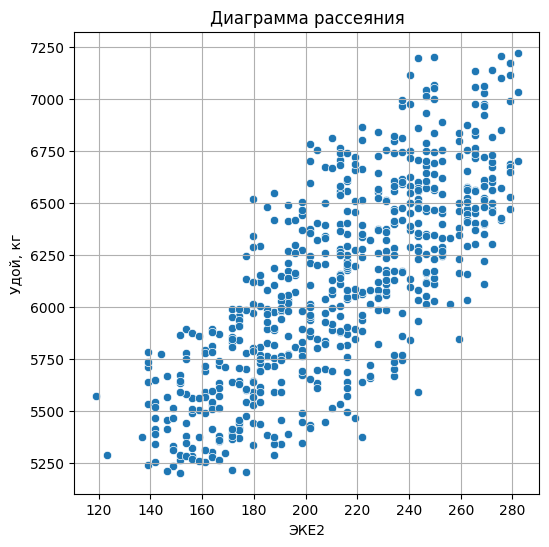

In [88]:
# создадим новый признак
ferma_main_2['ef_unit_'] = ferma_main_2['ef_unit'] ** 2
plt.figure(figsize=(6, 6))
sns.scatterplot(data=ferma_main_2, x='ef_unit_', y='yield')
plt.grid(True)
plt.title('Диаграмма рассеяния')
plt.xlabel('ЭКЕ2')
plt.ylabel('Удой, кг')
plt.show;

С этим признаком лучше видна линейная зависимость.

#### <font color="braun">Отбор признаков</font>

Отберем признаки: удалим ненужные, сохраним целевой и входные признаки в переменных.

In [89]:
# удалим ненужные столбцы
ferma_main_2 = ferma_main_2.drop(['id', 'ef_unit', 'sp_ratio', 'fat_content', 'protein', 'milk_flavor', 'milk_flavor_', 'age_'], axis=1)

# сохранение входных признаков
X = ferma_main_2.drop('yield', axis=1)

# сохранение целевого признака
y = ferma_main_2['yield']

#### <font color="braun">Разбиение данных</font>

Разобьем данные на тренировочные и тестовые.

In [90]:
# создание константы
RANDOM_STATE = 42

# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

#### <font color="braun">Кодирование</font>

Выполним подготовку категориальных признаков используя метод кодирования `OneHotEncoding`.

In [91]:
# выбор метода кодирования, его инициализация
encoder = OneHotEncoder(drop='first', sparse_output=False)
# список всех категориальных признаков из тренировочной выборки
cat_col_names = ['breed', 'pasture_type', 'dad_breed', 'age', 'sp_ratio_']
# обучение и преобразование категориальных признаков из тренировочной выборки
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
# преобразование категориальных признаков из тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names])
# сохранение в переменной новых столбцов
encoder_col_names = encoder.get_feature_names_out()
# создание датафреймов из закодированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
# проверим кодированные данные
X_train_ohe.head(3)

breed_РефлешнСоверинг  pasture_type_холмистое  dad_breed_Соверин  \
0                    1.0                     1.0                1.0   
1                    1.0                     1.0                1.0   
2                    0.0                     0.0                0.0   

   age_менее_2_лет  sp_ratio__1  
0              0.0          1.0  
1              1.0          0.0  
2              0.0          0.0

#### <font color="braun">Масштабирование</font>

Выполним масштабирование количественных признаков, используя `стандартизацию` (когда стандартное отклонение признаков равно единице, а среднее значение равно нулю).

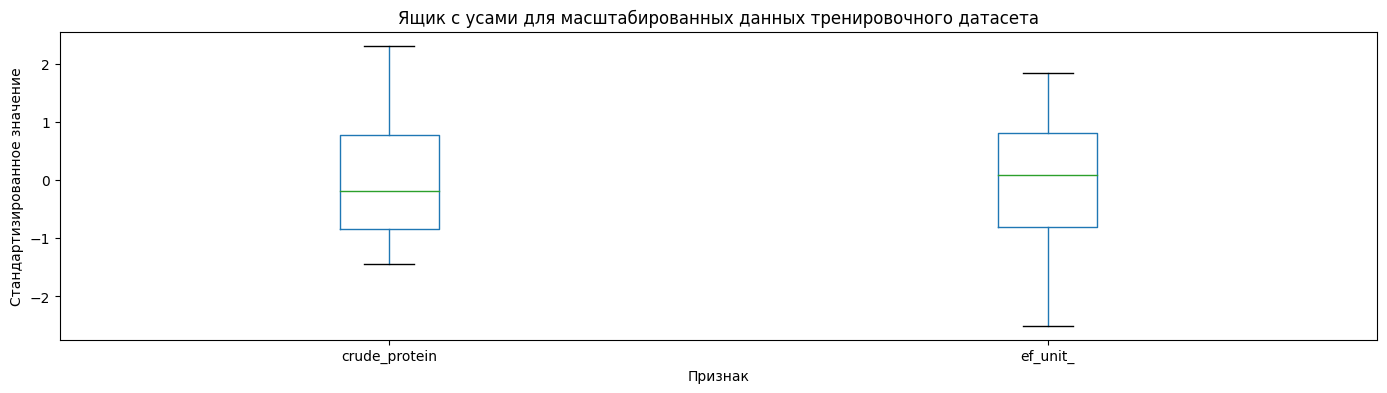

In [92]:
# определяем метод масштабирования
scaler = StandardScaler()
# список всех колиественных признаков из тренировочной выборки
quant_col_names = ['crude_protein', 'ef_unit_']
# обучение и масштабирование количественных признаков тренировочной выборки
X_train_scaler = scaler.fit_transform(X_train[quant_col_names])
# масштабирование количественных признаков тестовой выборки
X_test_scaler = scaler.transform(X_test[quant_col_names])
# создание датафреймов из масштабированных данных
X_train_scaler = pd.DataFrame(X_train_scaler, columns=quant_col_names)
X_test_scaler = pd.DataFrame(X_test_scaler, columns=quant_col_names)
#  проверим масштабированные данные
X_train_scaler[quant_col_names].plot(kind='box', figsize=(17, 4))
plt.title('Ящик с усами для масштабированных данных тренировочного датасета')
plt.xlabel('Признак')
plt.ylabel('Стандартизированное значение')
plt.show;

#### <font color="braun">Обучение модели</font>

Соберем все преобразованные данные в датафреймы.

In [93]:
# создание датафреймов из масштабировнных и кодированных данных
X_train = pd.concat([X_train_scaler, X_train_ohe], axis=1)
X_test = pd.concat([X_test_scaler, X_test_ohe], axis=1)

In [94]:
# инициализация и обучение модели
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
# предсказанное значение для X_test
predictions_2 = model_lr.predict(X_test)
print(f'Настоящий удой 1 объекта: {y_test.reset_index(drop=True)[1]:.2f}')
print(f'Предсказанный удой 1 объекта: {predictions_2[1]:.2f}')
print(f'Ошибка для 1 объекта: {y_test.reset_index(drop=True)[1] - predictions_2[1]:.2f}')

Настоящий удой 1 объекта: 6512.00
Предсказанный удой 1 объекта: 6466.66
Ошибка для 1 объекта: 45.34


Ошибка для первого объекта, по сравнению с первой моделью, уменьшилась почти в два раза.

#### <font color="braun">Оценка качества модели</font>

Оценим качество модели на тестовой выборке.

In [95]:
# расчет значения r2
r2_2 = r2_score(y_test, predictions_2)
# расчет других метрик
mse_2 = mean_squared_error(y_test, predictions_2)
mae_2 = mean_absolute_error(y_test, predictions_2)
rmse_2 = root_mean_squared_error(y_test, predictions_2)
print(f'Коэффициент детерминации R2: {r2_2:.4f}')

Коэффициент детерминации R2: 0.8181


Значение коэффициента близко к единице, модель дает верные предсказания в `81.81 %` случаев.

Построим гистограмму распределения остатков.

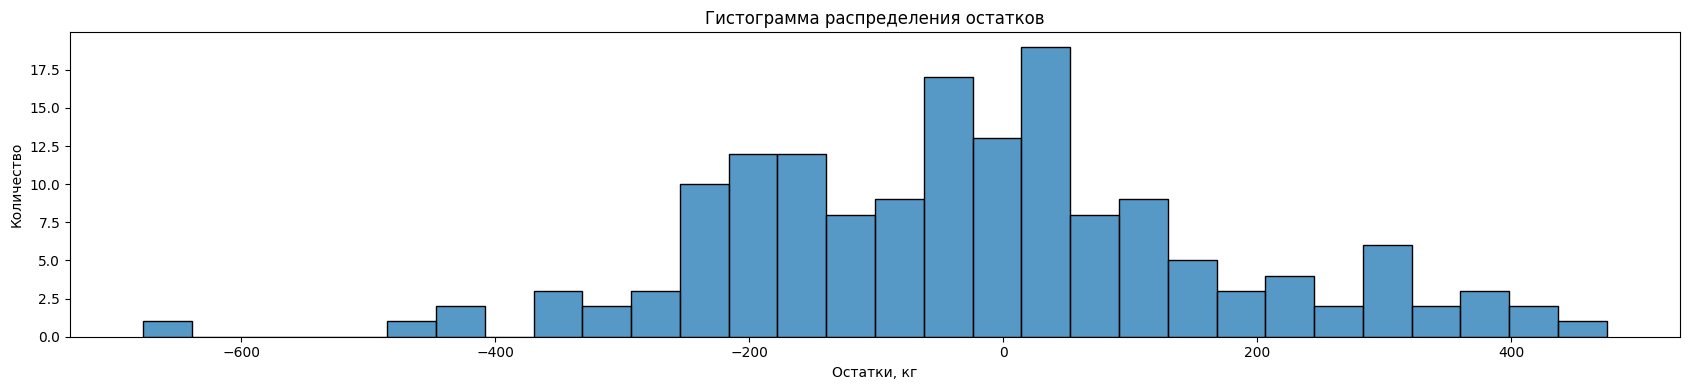

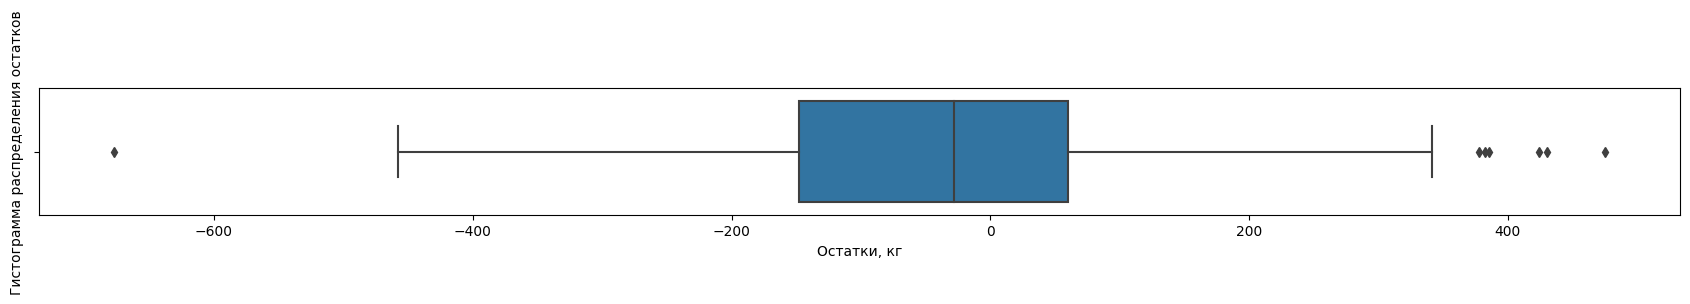

Минимальное значение: -677.412
Левый ус ящика: -460.182
Первый квантиль Q1: -147.958
Медианное значение: -24.373
Третий квантиль Q3: 60.192
Правый ус ящика: 372.416
Максимальное значение: 475.458


In [96]:
# рассчитаем остатки
residuals_2 = y_test - predictions_2
#создадим датафрейм из остатков
residuals_df_2 = pd.DataFrame(residuals_2)
# вызовем созданную ранее функцию
quantity_func(residuals_df_2,
              'yield',
              title='Гистограмма распределения остатков',
              xlabel='Остатки, кг',
              ylabel='Количество')

Распределение близко к нормальному с небольшим смещением влево. Есть несколько выбросов с обеих сторон.

Построим диаграмму рассеяния.

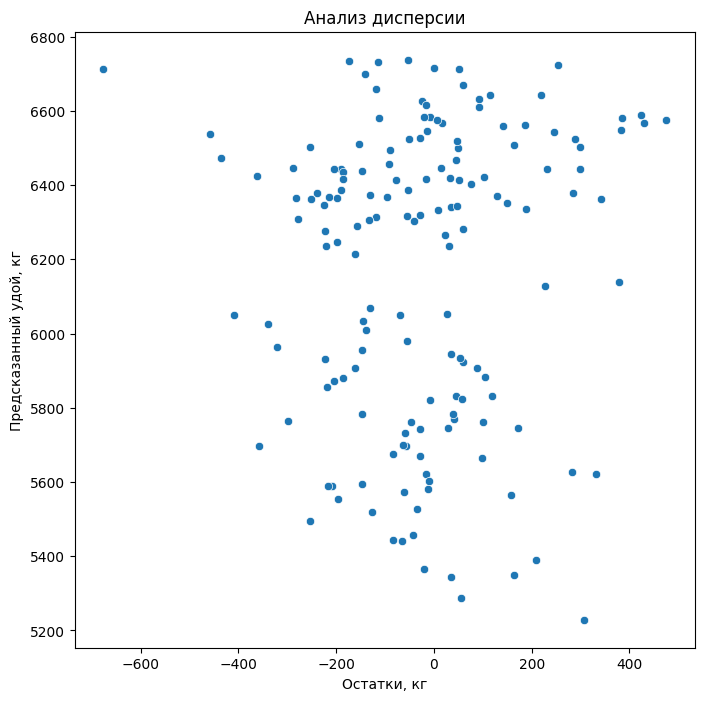

In [97]:
# построим диаграмму рассеяния
plt.figure(figsize=(8, 8))
sns.scatterplot(x=residuals_2, y=predictions_2)
plt.title('Анализ дисперсии')
plt.xlabel('Остатки, кг')
plt.ylabel('Предсказанный удой, кг')
plt.show;

#### <font color="darkred">Вывод по подразделу</font>

Добавили два новых признака:
- создали категорийный бинарный признак из СПО;
- создали признак из квадрата ЭКЕ.

Отобрали необходимые признаки. Разбили данные, провели кодирование и масштабирование. Обучили модель, сделали предсказание и вычислили ошибку - `45.34`, она в два раза ниже, чем у первой модели. Оценили качество модели по коэффициенту детерминации - `0.8181`, он увеличился. Построили гистограмму распределения остатков и провели анализ дисперсии. Точность модели, по сравнению с первой, увеличилась.

---

### <font color="darkgreen">Третья модель `LinearRegression`</font>

Проведем обучение второй модели линейной регрессии. Соединим датафрейм `ferma_main` и `ferma_dad` по признаку `id`.

In [98]:
# соединим датафреймы по id
ferma_main_3 = pd.merge(ferma_main, ferma_dad, on='id')
ferma_main_3.head(3)

id  yield  ef_unit  crude_protein  sp_ratio            breed pasture_type  \
0   1   5863     14.2           1743     0.890     ВисБикАйдиал    равнинное   
1   2   5529     12.8           2138     0.890     ВисБикАйдиал    равнинное   
2   3   5810     14.0           1854     0.885  РефлешнСоверинг    холмистое   

  dad_breed  fat_content  protein milk_flavor          age  milk_flavor_  \
0    Айдиал         3.58    3.076      вкусно  более_2_лет             1   
1   Соверин         3.54    3.079      вкусно  менее_2_лет             1   
2   Соверин         3.59    3.074   не вкусно  более_2_лет             0   

   age_  dad_name  
0     1    Буйный  
1     0  Соловчик  
2     1     Барин

#### <font color="braun">Анализ диаграмм рассеяния</font>

Аналогично как и во второй модели, создадим дополнительный бинарный категорийный признак.

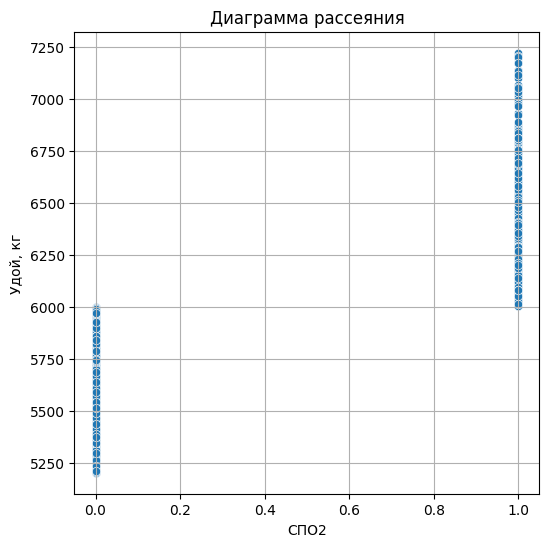

In [99]:
# добавим новый признак и построим диаграмму рассеяния
ferma_main_3['sp_ratio_'] = (ferma_main_3['sp_ratio'] >= 0.92).astype('int8')
plt.figure(figsize=(6, 6))
sns.scatterplot(data=ferma_main_3, x='sp_ratio_', y='yield')
plt.grid(True)
plt.title('Диаграмма рассеяния')
plt.xlabel('СПО2')
plt.ylabel('Удой, кг')
plt.show;

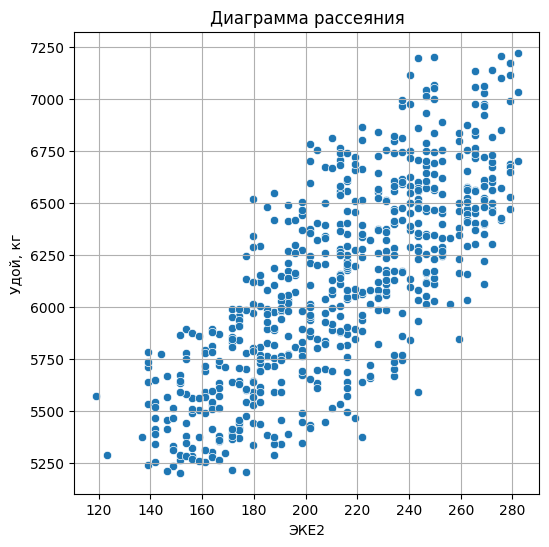

In [100]:
ferma_main_3['ef_unit_'] = ferma_main_3['ef_unit'] ** 2

plt.figure(figsize=(6, 6))
sns.scatterplot(data=ferma_main_3, x='ef_unit_', y='yield')
plt.grid(True)
plt.title('Диаграмма рассеяния')
plt.xlabel('ЭКЕ2')
plt.ylabel('Удой, кг')
plt.show;

#### <font color="braun">Отбор признаков</font>

Отберем признаки: удалим ненужные, сохраним целевой и входные признаки в переменных.

In [101]:
# удалим ненужные столбцы
ferma_main_3 = ferma_main_3.drop(['id', 'ef_unit', 'sp_ratio', 'fat_content', 'protein', 'milk_flavor', 'milk_flavor_', 'age_'], axis=1)
# сохранение входных признаков
X = ferma_main_3.drop('yield', axis=1)
# сохранение целевого признака
y = ferma_main_3['yield']
print(ferma_main_3.shape)
ferma_main_3.head(3)

(628, 9)


yield  crude_protein            breed pasture_type dad_breed          age  \
0   5863           1743     ВисБикАйдиал    равнинное    Айдиал  более_2_лет   
1   5529           2138     ВисБикАйдиал    равнинное   Соверин  менее_2_лет   
2   5810           1854  РефлешнСоверинг    холмистое   Соверин  более_2_лет   

   dad_name  sp_ratio_  ef_unit_  
0    Буйный          0    201.64  
1  Соловчик          0    163.84  
2     Барин          0    196.00

#### <font color="braun">Разбиение данных</font>

Разобьем данные на тренировочные и тестовые.

In [102]:
# создание константы
RANDOM_STATE = 42

# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

#### <font color="braun">Кодирование</font>

Выполним подготовку категориальных признаков используя метод кодирования `OneHotEncoding`.

In [103]:
print(ferma_main_3.shape)
ferma_main_3.head(3)

(628, 9)


yield  crude_protein            breed pasture_type dad_breed          age  \
0   5863           1743     ВисБикАйдиал    равнинное    Айдиал  более_2_лет   
1   5529           2138     ВисБикАйдиал    равнинное   Соверин  менее_2_лет   
2   5810           1854  РефлешнСоверинг    холмистое   Соверин  более_2_лет   

   dad_name  sp_ratio_  ef_unit_  
0    Буйный          0    201.64  
1  Соловчик          0    163.84  
2     Барин          0    196.00

In [104]:
# выбор метода кодирования, его инициализация
encoder = OneHotEncoder(drop='first', sparse_output=False)
# список всех категориальных признаков из тренировочной выборки
cat_col_names = ['breed', 'pasture_type', 'dad_breed', 'age', 'dad_name', 'sp_ratio_']
# обучение и преобразование категориальных признаков из тренировочной выборки
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
# преобразование категориальных признаков из тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names])
# сохранение в переменной новых столбцов
encoder_col_names = encoder.get_feature_names_out()
# создание датафреймов из закодированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
# проверим кодированные данные
print(X_train_ohe.shape)
X_train_ohe.head(3)

(471, 8)


breed_РефлешнСоверинг  pasture_type_холмистое  dad_breed_Соверин  \
0                    1.0                     1.0                1.0   
1                    1.0                     1.0                1.0   
2                    0.0                     0.0                0.0   

   age_менее_2_лет  dad_name_Буйный  dad_name_Геркулес  dad_name_Соловчик  \
0              0.0              0.0                0.0                1.0   
1              1.0              0.0                0.0                0.0   
2              0.0              1.0                0.0                0.0   

   sp_ratio__1  
0          1.0  
1          0.0  
2          0.0

#### <font color="braun">Масштабирование</font>

Выполним масштабирование количественных признаков, используя `стандартизацию` (когда стандартное отклонение признаков равно единице, а среднее значение равно нулю).

(471, 2)


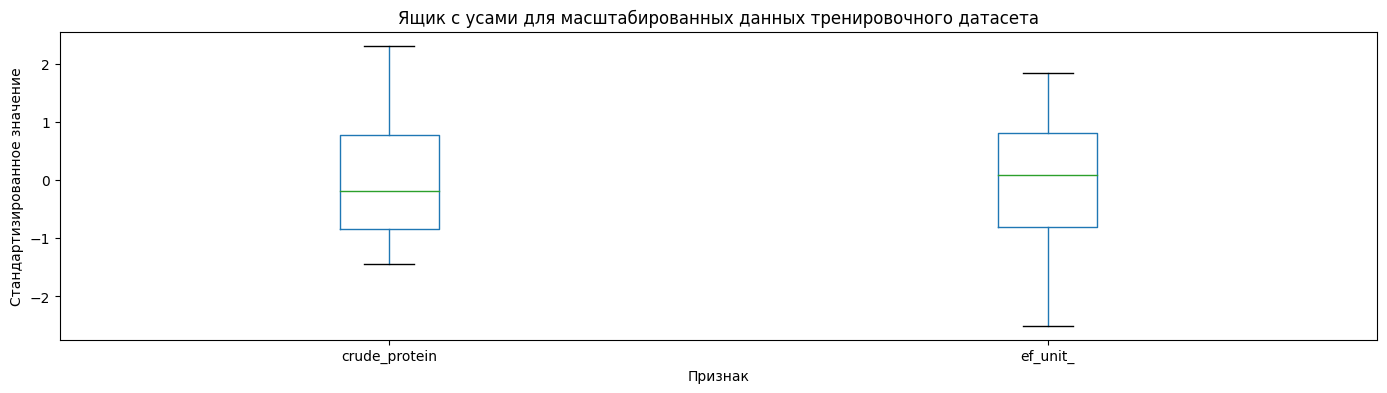

In [105]:
# определяем метод масштабирования
scaler = StandardScaler()
# список всех колиественных признаков из тренировочной выборки
quant_col_names = ['crude_protein', 'ef_unit_']
# обучение и масштабирование количественных признаков тренировочной выборки
X_train_scaler = scaler.fit_transform(X_train[quant_col_names])
# масштабирование количественных признаков тестовой выборки
X_test_scaler = scaler.transform(X_test[quant_col_names])
# создание датафреймов из масштабированных данных
X_train_scaler = pd.DataFrame(X_train_scaler, columns=quant_col_names)
X_test_scaler = pd.DataFrame(X_test_scaler, columns=quant_col_names)
#  проверим масштабированные данные
print(X_train_scaler.shape)
X_train_scaler[quant_col_names].plot(kind='box', figsize=(17, 4))
plt.title('Ящик с усами для масштабированных данных тренировочного датасета')
plt.xlabel('Признак')
plt.ylabel('Стандартизированное значение')
plt.show;

#### <font color="braun">Обучение модели</font>

Соберем все преобразованные данные в датафреймы.

In [106]:
# создание датафреймов из масштабированных и кодированных данных
X_train = pd.concat([X_train_scaler, X_train_ohe], axis=1)
X_test = pd.concat([X_test_scaler, X_test_ohe], axis=1)

print(X_train.shape)
X_train.head(3)

(471, 10)


crude_protein  ef_unit_  breed_РефлешнСоверинг  pasture_type_холмистое  \
0       1.079523  1.577968                    1.0                     1.0   
1      -0.196920 -1.511438                    1.0                     1.0   
2      -1.386085  0.082269                    0.0                     0.0   

   dad_breed_Соверин  age_менее_2_лет  dad_name_Буйный  dad_name_Геркулес  \
0                1.0              0.0              0.0                0.0   
1                1.0              1.0              0.0                0.0   
2                0.0              0.0              1.0                0.0   

   dad_name_Соловчик  sp_ratio__1  
0                1.0          1.0  
1                0.0          0.0  
2                0.0          0.0

In [107]:
# инициализация и обучение модели
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
# предсказанное значение для X_test
predictions_3 = model_lr.predict(X_test)
print(f'Настоящий удой 1 объекта: {y_test.reset_index(drop=True)[1]:.2f}')
print(f'Предсказанный удой 1 объекта: {predictions_3[1]:.2f}')
print(f'Ошибка для 1 объекта: {y_test.reset_index(drop=True)[1] - predictions_3[1]:.2f}')

Настоящий удой 1 объекта: 6512.00
Предсказанный удой 1 объекта: 6488.06
Ошибка для 1 объекта: 23.94


Ошибка для первого объекта, по сравнению со второй моделью, уменьшилась еще почти в два раза.

#### <font color="braun">Оценка качества модели</font>

Оценим качество модели на тестовой выборке.

In [108]:
# расчет значения r2
r2_3 = r2_score(y_test, predictions_3)
# расчет других метрик
mse_3 = mean_squared_error(y_test, predictions_3)
mae_3 = mean_absolute_error(y_test, predictions_3)
rmse_3 = root_mean_squared_error(y_test, predictions_3) 
print(f'Коэффициент детерминации R2: {r2_3:.4f}')

Коэффициент детерминации R2: 0.8248


Значение коэффициента близко к единице, модель дает верные предсказания в `82.48 %` случаев.

Построим диаграмму распределения остатков.

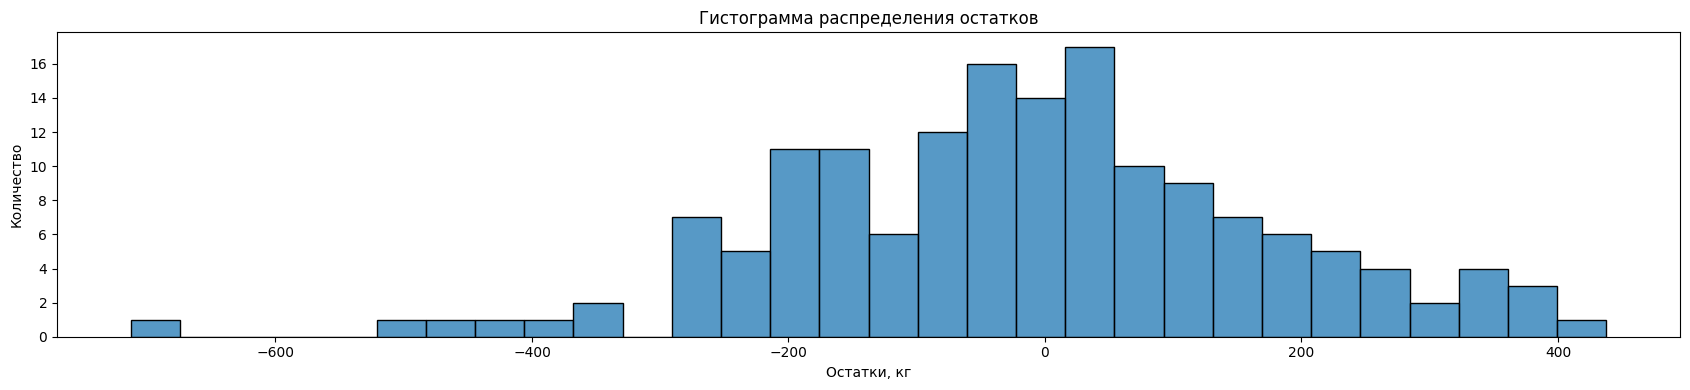

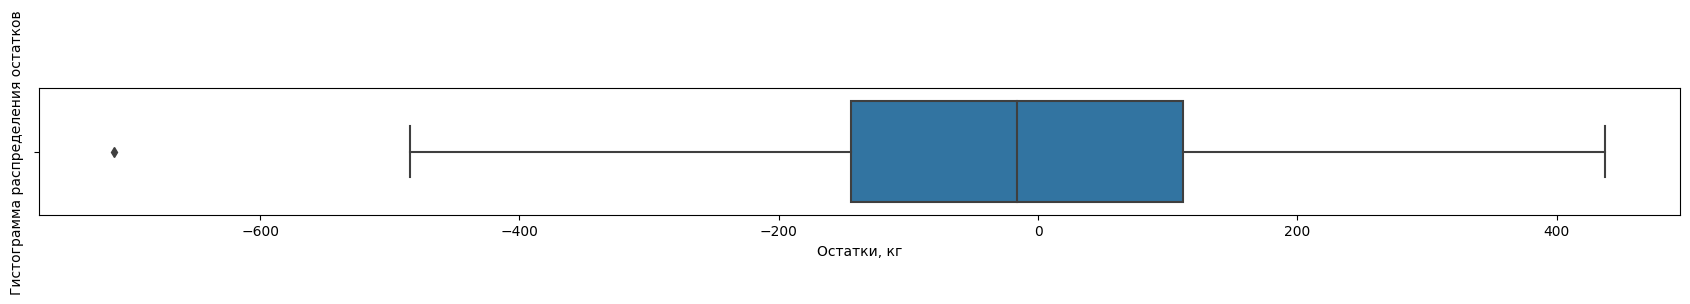

Минимальное значение: -712.794
Левый ус ящика: -528.995
Первый квантиль Q1: -144.382
Медианное значение: -15.202
Третий квантиль Q3: 112.027
Правый ус ящика: 496.640
Максимальное значение: 437.598


In [109]:
# рассчитаем остатки
residuals_3 = y_test - predictions_3
#создадим датафрейм из остатков
residuals_df_3 = pd.DataFrame(residuals_3)
# вызовем созданную ранее функцию
quantity_func(residuals_df_3,
              'yield',
              title='Гистограмма распределения остатков',
              xlabel='Остатки, кг',
              ylabel='Количество')

Распределение близко к нормальному с небольшим смещением влево. Есть выбросы с обоих сторон.

Построим диаграмму рассеяния.

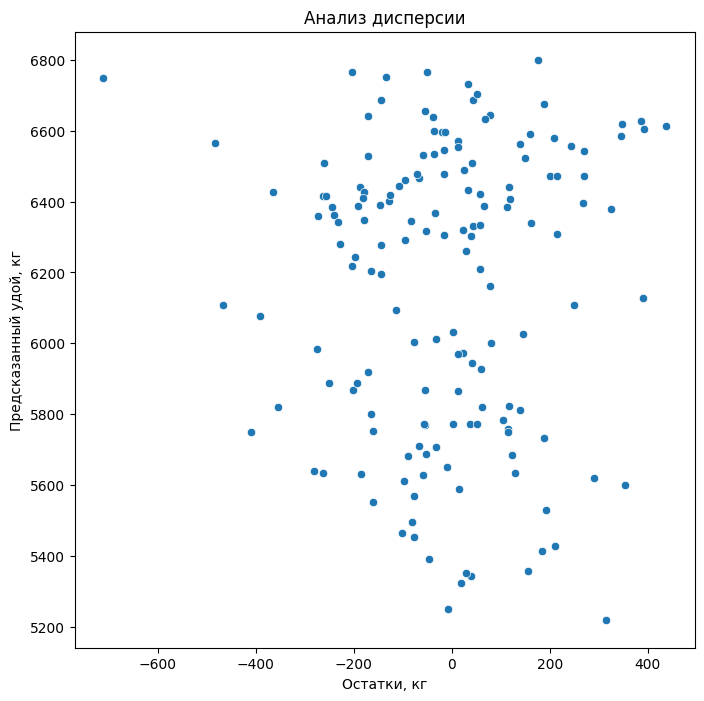

In [110]:
# построим диаграмму рассеяния
plt.figure(figsize=(8, 8))
sns.scatterplot(x=residuals_3, y=predictions_3)
plt.title('Анализ дисперсии')
plt.xlabel('Остатки, кг')
plt.ylabel('Предсказанный удой, кг')
plt.show;

#### <font color="darkred">Вывод по подразделу</font>

Аналогично второй модели, добавили два новых признака:
- создали категорийный бинарный признак из СПО;
- создали признак из квадрата ЭКЕ.

Добавили дополнительный признак `порода отца быка`.

Отобрали необходимые признаки. Разбили данные, провели кодирование и масштабирование. Обучили модель, сделали предсказание и вычислили ошибку - `23.94`, она еще ниже, чем у второй модели. Оценили качество модели по коэффициенту детерминации - `0.8248`, он еще увеличился. Построили гистограмму распределения остатков и провели анализ дисперсии. Точность модели, по сравнению со второй, увеличилась.

---

### <font color="darkgreen">Сравнение моделей `LinearRegression`</font>

Сопоставим R2 полученных моделей.

In [111]:
# выведем все коэффиценты r2
print(f'Коэффициент R2 модели 1: {r2_1:.4f}')
print(f'Коэффициент R2 модели 2: {r2_2:.4f}')
print(f'Коэффициент R2 модели 3: {r2_3:.4f}')

Коэффициент R2 модели 1: 0.7844
Коэффициент R2 модели 2: 0.8181
Коэффициент R2 модели 3: 0.8248


Наибольший коэффициент у модели 3. Она дает правильные предсказания в `83 %` случаев.

Сопоставим остатки полученных моделей.

In [112]:
# соединим остатки трех моделей в один датафрейм
residuals_df = pd.concat([residuals_1, residuals_2, residuals_3], axis=1)
# заменим названия столбцов
residuals_df.columns = ['residuals_1', 'residuals_2', 'residuals_3']
# выведем три строки
residuals_df.head(3)

residuals_1  residuals_2  residuals_3
581   -51.538081    35.721858   -33.248427
591    78.897591    45.344339    23.944358
550   -67.599755  -126.937220  -160.535828

In [113]:
# создадим датафрем из каждого списка предсказанных значений
predictions_df_1 = pd.DataFrame(predictions_1)
predictions_df_2 = pd.DataFrame(predictions_2)
predictions_df_3 = pd.DataFrame(predictions_3)
# соединим три полученных датафрема в один
predictions_df = pd.concat([predictions_df_1, predictions_df_2, predictions_df_3], axis=1)
# заменим названия столбцов
predictions_df.columns = ['predictions_1', 'predictions_2', 'predictions_3']
# выведем три строки
predictions_df.head(3)

predictions_1  predictions_2  predictions_3
0    6031.538081    5944.278142    6013.248427
1    6433.102409    6466.655661    6488.055642
2    5459.599755    5518.937220    5552.535828

Построим диаграммы распределения остатков с помощью `hexbin` диаграммы.

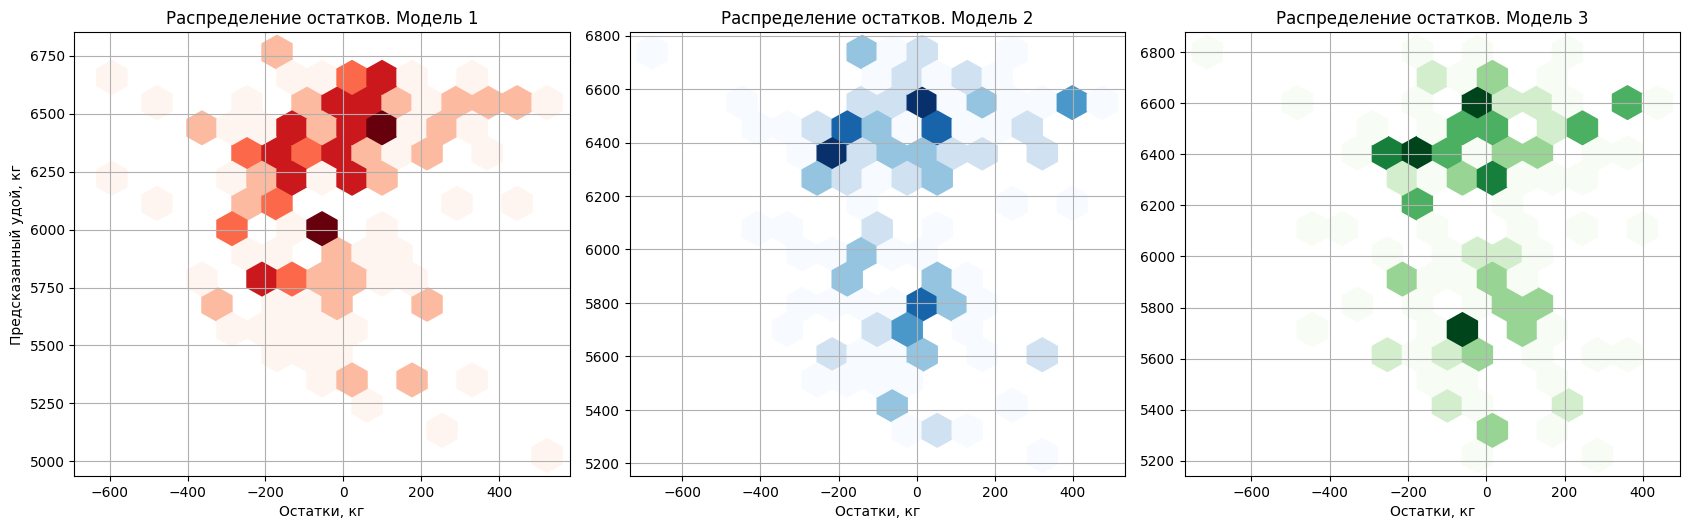

In [114]:
# построим hex-диаграммы для трех моделей по полученным датафреймам
plt.figure(figsize=(17, 15))
# диаграмма модели 1
plt.subplot(3, 3, 1)
plt.hexbin(residuals_df['residuals_1'], predictions_df['predictions_1'], cmap='Reds', gridsize=15, mincnt=1)
plt.grid(True)
plt.title('Распределение остатков. Модель 1')
plt.xlabel('Остатки, кг')
plt.ylabel('Предсказанный удой, кг')
# диаграмма модели 2
plt.subplot(3, 3, 2)
plt.hexbin(residuals_df['residuals_2'], predictions_df['predictions_2'], cmap='Blues', gridsize=15, mincnt=1)
plt.grid(True)
plt.title('Распределение остатков. Модель 2')
plt.xlabel('Остатки, кг')
# диаграмма модели 3
plt.subplot(3, 3, 3)
plt.hexbin(residuals_df['residuals_3'], predictions_df['predictions_3'], cmap='Greens', gridsize=15, mincnt=1)
plt.grid(True)
plt.title('Распределение остатков. Модель 3')
plt.xlabel('Остатки, кг')
plt.tight_layout()
plt.show();

По диаграммам видно:
- у модели 1, остатки смещены влево, распределены в широком диапазоне от `-600` до `+500` (по видимым скоплениям);
- у модели 2, остатки немного смещены влево, ширина распределения меньше от `-300` до `+400` (по видимым скоплениям);
- у модели 3, остатки сконцентрированы ближе к центру, ширина распределения от `-300` до `+400` (по видимым скоплениям).

### <font color="darkgreen">Оценка качества моделей `LinearRegression`</font>

In [115]:
# выведем метрику mse
print(f'Средний квадрат ошибки модели 1: {mse_1:.0f} кг2')
print(f'Средний квадрат ошибки модели 2: {mse_2:.0f} кг2')
print(f'Средний квадрат ошибки модели 3: {mse_3:.0f} кг2')

Средний квадрат ошибки модели 1: 43887 кг2
Средний квадрат ошибки модели 2: 37031 кг2
Средний квадрат ошибки модели 3: 35674 кг2


In [116]:
# выведем метрику mae
print(f'Средняя абсолютная ошибка модели 1: {mae_1:.0f} кг')
print(f'Средняя абсолютная ошибка модели 2: {mae_2:.0f} кг')
print(f'Средняя абсолютная ошибка модели 3: {mae_3:.0f} кг')

Средняя абсолютная ошибка модели 1: 164 кг
Средняя абсолютная ошибка модели 2: 149 кг
Средняя абсолютная ошибка модели 3: 146 кг


In [117]:
# выведем метрику rmse
print(f'Среднеквадратичная ошибка модели 1: {rmse_1:.0f} кг')
print(f'Среднеквадратичная ошибка модели 2: {rmse_2:.0f} кг')
print(f'Среднеквадратичная ошибка модели 3: {rmse_3:.0f} кг')

Среднеквадратичная ошибка модели 1: 209 кг
Среднеквадратичная ошибка модели 2: 192 кг
Среднеквадратичная ошибка модели 3: 189 кг


`MSE`, `MAE` и `RMSE` модели 3 меньше двух предыдущих моделей. Модель 3 имеет наименьшую ошибку при предсказании.

Определимся с лучшей моделью из трех.

In [118]:
# выведем числовые характеристики датафрейма с остатками
residuals_df.describe().T

count       mean         std         min         25%        50%  \
residuals_1  157.0 -25.373286  208.615463 -632.814111 -164.145968 -34.294516   
residuals_2  157.0 -24.372798  191.495294 -677.411878 -147.957591 -27.871259   
residuals_3  157.0 -15.201522  188.865034 -712.793903 -144.381634 -15.967703   

                    75%         max  
residuals_1  108.696566  523.551641  
residuals_2   60.191976  475.458320  
residuals_3  112.027110  437.597704

Более точной представляется модель 3, у нее по сравнению с 1 и 2 моделями:
- больше коэффициент `R2`;
- диапазон распределения остатков меньше и выровнен ближе к 0;
- меньше метрики `MSE`, `MAE` и `RMSE`;
- среднее значение остатков меньше;
- стандартное отклонение остатков меньше;
- медианное значение меньше.

Определим доверительный интервал, рассчитав квантили 2.5% и 97.5% остатков.

In [119]:
# расчет квантилей
q_02_5 = residuals_df_3['yield'].quantile(0.025)
q_97_5 = residuals_df_3['yield'].quantile(0.975)
# вывод результатов
print(f'Квантиль 2.5 %: {q_02_5:.0f}')
print(f'Квантиль 97.5 %: {q_97_5:.0f}')
print(f'Доверительный интервал 95 %: [{q_02_5:.0f}, {q_97_5:.0f}]')

Квантиль 2.5 %: -393
Квантиль 97.5 %: 356
Доверительный интервал 95 %: [-393, 356]


### <font color="darkgreen">Прогноз удоя</font>

Перед прогнозированием добавим в датасет `cow_buy` недостающие признаки.

In [120]:
# выведем датасет ЭкоФермы
cow_buy.head(1)

breed pasture_type dad_breed  dad_name  fat_content  protein  \
0  ВисБикАйдиал    холмистое    Айдиал  Геркулес         3.58    3.076   

           age  age_  
0  более_2_лет     1

In [121]:
# выведем датасет фермера
ferma_main.head(1)

id  yield  ef_unit  crude_protein  sp_ratio         breed pasture_type  \
0   1   5863     14.2           1743      0.89  ВисБикАйдиал    равнинное   

  dad_breed  fat_content  protein milk_flavor          age  milk_flavor_  age_  
0    Айдиал         3.58    3.076      вкусно  более_2_лет             1     1

In [122]:
# добавим три признака, увеличенные на 5 %
cow_buy['ef_unit'] = (ferma_main['ef_unit'].mean() * 1.05).round(2)
cow_buy['crude_protein'] = (ferma_main['crude_protein'].mean() * 1.05).astype(int)
cow_buy['sp_ratio'] = (ferma_main['sp_ratio'].mean() * 1.05).round(3)
# выведем обновленный датасет
cow_buy.head(1)

breed pasture_type dad_breed  dad_name  fat_content  protein  \
0  ВисБикАйдиал    холмистое    Айдиал  Геркулес         3.58    3.076   

           age  age_  ef_unit  crude_protein  sp_ratio  
0  более_2_лет     1    15.28           2019     0.959

#### <font color="braun">Анализ диаграмм рассеяния</font>

In [123]:
# сделаем копию
cow_buy_lir = cow_buy.copy()

In [124]:
# создадим дополнительные признаки
cow_buy_lir['sp_ratio_'] = (cow_buy_lir['sp_ratio'] >= 0.92).astype('int8')
cow_buy_lir['ef_unit_'] = cow_buy_lir['ef_unit'] ** 2
print(cow_buy_lir.shape)
cow_buy_lir.head(3)

(16, 13)


breed pasture_type dad_breed  dad_name  fat_content  protein  \
0     ВисБикАйдиал    холмистое    Айдиал  Геркулес         3.58    3.076   
1     ВисБикАйдиал    равнинное   Соверин    Буйный         3.54    3.081   
2  РефлешнСоверинг    равнинное   Соверин     Барин         3.59    3.074   

           age  age_  ef_unit  crude_protein  sp_ratio  sp_ratio_  ef_unit_  
0  более_2_лет     1    15.28           2019     0.959          1  233.4784  
1  менее_2_лет     0    15.28           2019     0.959          1  233.4784  
2  более_2_лет     1    15.28           2019     0.959          1  233.4784

#### <font color="braun">Отбор признаков</font>

Отберем признаки: удалим ненужные.

In [125]:
# удалим ненужные столбцы
cow_buy_lir = cow_buy_lir.drop(['protein', 'age_', 'sp_ratio', 'ef_unit'], axis=1)

In [126]:
# выведем датафрейм
print(cow_buy_lir.shape)
cow_buy_lir.head(3)

(16, 9)


breed pasture_type dad_breed  dad_name  fat_content          age  \
0     ВисБикАйдиал    холмистое    Айдиал  Геркулес         3.58  более_2_лет   
1     ВисБикАйдиал    равнинное   Соверин    Буйный         3.54  менее_2_лет   
2  РефлешнСоверинг    равнинное   Соверин     Барин         3.59  более_2_лет   

   crude_protein  sp_ratio_  ef_unit_  
0           2019          1  233.4784  
1           2019          1  233.4784  
2           2019          1  233.4784

#### <font color="braun">Кодирование</font>

Выполним кодирование категориальных признаков используя метод `OneHotEncoding`.

In [127]:
# преобразование категориальных признаков
X_train_ohe_lir = encoder.transform(cow_buy_lir[cat_col_names])
# сохранение в переменной новых столбцов
encoder_col_names_lir = encoder.get_feature_names_out()
# создание датафреймов из закодированных данных
X_train_ohe_lir = pd.DataFrame(X_train_ohe_lir, columns=encoder_col_names_lir)
# проверим кодированные данные
print(X_train_ohe_lir.shape)
X_train_ohe_lir.head(3)

(16, 8)


breed_РефлешнСоверинг  pasture_type_холмистое  dad_breed_Соверин  \
0                    0.0                     1.0                0.0   
1                    0.0                     0.0                1.0   
2                    1.0                     0.0                1.0   

   age_менее_2_лет  dad_name_Буйный  dad_name_Геркулес  dad_name_Соловчик  \
0              0.0              0.0                1.0                0.0   
1              1.0              1.0                0.0                0.0   
2              0.0              0.0                0.0                0.0   

   sp_ratio__1  
0          1.0  
1          1.0  
2          1.0

#### <font color="braun">Масштабирование</font>

Выполним масштабирование количественных признаков, используя `стандартизацию`.

(16, 2)


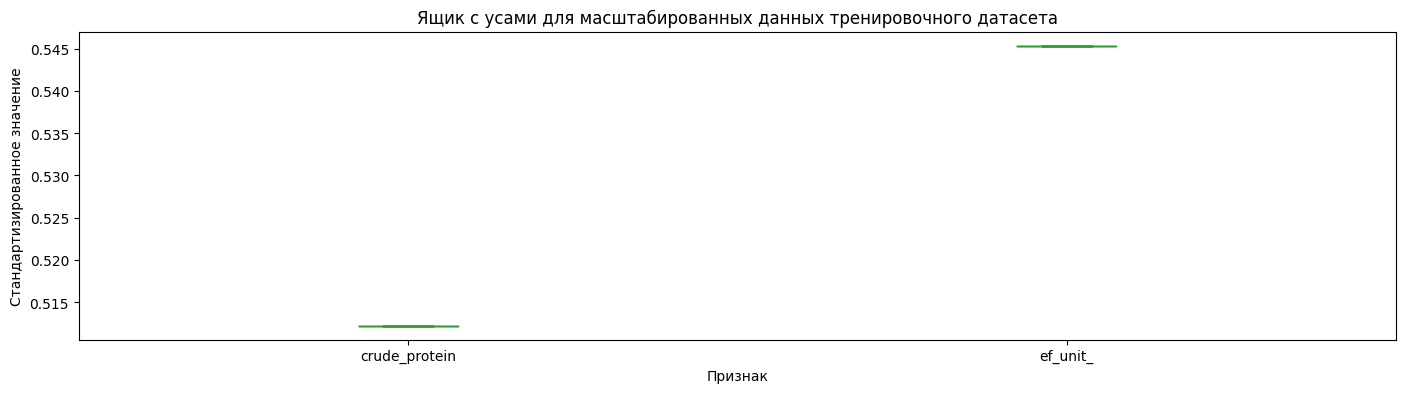

In [128]:
# масштабирование количественных признаков
X_train_scaler_lir = scaler.transform(cow_buy_lir[quant_col_names])
# создание датафреймов из масштабированных данных
X_train_scaler_lir = pd.DataFrame(X_train_scaler_lir, columns=quant_col_names)
# проверим масштабированные данные
print(X_train_scaler_lir.shape)
X_train_scaler_lir[quant_col_names].plot(kind='box', figsize=(17, 4))
plt.title('Ящик с усами для масштабированных данных тренировочного датасета')
plt.xlabel('Признак')
plt.ylabel('Стандартизированное значение')
plt.show;

#### <font color="braun">Получим прогноз удоя</font>

Соберем все преобразованные данные в датафреймы.

In [129]:
# создание датафрейма из масштабировнных и кодированных данных
X_train_lir = pd.concat([X_train_scaler_lir, X_train_ohe_lir], axis=1)
print(X_train_lir.shape)
X_train_lir.head(3)

(16, 10)


crude_protein  ef_unit_  breed_РефлешнСоверинг  pasture_type_холмистое  \
0       0.512215  0.545371                    0.0                     1.0   
1       0.512215  0.545371                    0.0                     0.0   
2       0.512215  0.545371                    1.0                     0.0   

   dad_breed_Соверин  age_менее_2_лет  dad_name_Буйный  dad_name_Геркулес  \
0                0.0              0.0              0.0                1.0   
1                1.0              1.0              1.0                0.0   
2                1.0              0.0              0.0                0.0   

   dad_name_Соловчик  sp_ratio__1  
0                0.0          1.0  
1                0.0          1.0  
2                0.0          1.0

In [130]:
# создадим новый столбец с предсказанным удоем
cow_buy['yield_'] = model_lr.predict(X_train_lir)
print(cow_buy.shape)
cow_buy

(16, 12)


breed pasture_type dad_breed  dad_name  fat_content  protein  \
0      ВисБикАйдиал    холмистое    Айдиал  Геркулес         3.58    3.076   
1      ВисБикАйдиал    равнинное   Соверин    Буйный         3.54    3.081   
2   РефлешнСоверинг    равнинное   Соверин     Барин         3.59    3.074   
3   РефлешнСоверинг    холмистое    Айдиал    Буйный         3.40    3.061   
4   РефлешнСоверинг    равнинное    Айдиал    Буйный         3.64    3.074   
5   РефлешнСоверинг    равнинное   Соверин  Геркулес         3.63    3.053   
6      ВисБикАйдиал    равнинное   Соверин    Буйный         3.57    3.079   
7   РефлешнСоверинг    холмистое    Айдиал    Буйный         3.40    3.079   
8      ВисБикАйдиал    холмистое   Соверин  Соловчик         3.73    3.055   
9   РефлешнСоверинг    равнинное   Соверин  Геркулес         3.73    3.073   
10     ВисБикАйдиал    холмистое    Айдиал  Геркулес         3.68    3.046   
11     ВисБикАйдиал    холмистое   Соверин     Барин         3.42    3.075   
12  РефлешнСоверинг    холмистое    Айдиал    Буйный         3.40    3.065   
13     ВисБикАйдиал    холмистое   Соверин  Соловчик         3.73    3.079   
14  РефлешнСоверинг    равнинное   Соверин  Геркулес         3.77    3.053   
15     ВисБикАйдиал    равнинное   Соверин    Буйный         3.34    3.069   

            age  age_  ef_unit  crude_protein  sp_ratio       yield_  
0   более_2_лет     1    15.28           2019     0.959  6610.157481  
1   менее_2_лет     0    15.28           2019     0.959  6378.949213  
2   более_2_лет     1    15.28           2019     0.959  6284.237960  
3   более_2_лет     1    15.28           2019     0.959  6593.327561  
4   более_2_лет     1    15.28           2019     0.959  6542.384251  
5   менее_2_лет     0    15.28           2019     0.959  6425.618402  
6   более_2_лет     1    15.28           2019     0.959  6571.497922  
7   менее_2_лет     0    15.28           2019     0.959  6400.778852  
8   более_2_лет     1    15.28           2019     0.959  6344.946044  
9   более_2_лет     1    15.28           2019     0.959  6618.167111  
10  более_2_лет     1    15.28           2019     0.959  6610.157481  
11  менее_2_лет     0    15.28           2019     0.959  6127.712927  
12  более_2_лет     1    15.28           2019     0.959  6593.327561  
13  более_2_лет     1    15.28           2019     0.959  6344.946044  
14  менее_2_лет     0    15.28           2019     0.959  6425.618402  
15  более_2_лет     1    15.28           2019     0.959  6571.497922

Мы получили датафремй со солбцом `yield_` в который обученная модель внесла свои предсказания удоя по каждой корове. Все коровы дают удой больше 6000 кг молока в год.

### <font color="darkred">Вывод по разделу</font>

В данном разделе было проведено следующее.

Подготовили данные и провели на них обучение трех моделей.
- Первая модель:
    - ошибка составила - `78.90` кг;
    - коэффициент детерминации - `0.7844`;
    - средний квадрат ошибки модели 1: 43887 кг2;
    - средняя абсолютная ошибка модели 1: 164 кг;
    - среднеквадратичная ошибка модели 1: 209 кг.

- Вторая модель:
    - ошибка - `45.34` кг;
    - коэффициент детерминации - `0.8181`;
    - средний квадрат ошибки модели 2: 37031 кг2;
    - средняя абсолютная ошибка модели 2: 149 кг;
    - среднеквадратичная ошибка модели 2: 192 кг.
    
- Третья модель:
    - ошибка - `23.94` кг;
    - коэффициент детерминации - `0.8248`;
    - средний квадрат ошибки модели 3: 35674 кг2;
    - средняя абсолютная ошибка модели 3: 146 кг;
    - среднеквадратичная ошибка модели 3: 189 кг.

Вычислили доверительный интервал 95 %: [-393, 356].

Добавили в датафрейм ЭкоФермы `cow_buy` увеличенные на `5 %` три дополнительные признака и два признака, аналогичных модели 2 и 3. После применения обученной модели, спрогнозировали удой коров ЭкоФермы.

---
## <font color="darkblue">Обучение модели логистической регрессии</font>

### <font color="darkgreen">Модель `LogisticRegression`</font>

Проведем обучение модели логистической регрессии используя в качестве целевого признака `Вкус молока`.

#### <font color="braun">Подготовка данных</font>

In [131]:
# добавим новый признак dad_name
ferma_main_4 = pd.merge(ferma_main, ferma_dad, on='id')
ferma_main_4.head(1)

id  yield  ef_unit  crude_protein  sp_ratio         breed pasture_type  \
0   1   5863     14.2           1743      0.89  ВисБикАйдиал    равнинное   

  dad_breed  fat_content  protein milk_flavor          age  milk_flavor_  \
0    Айдиал         3.58    3.076      вкусно  более_2_лет             1   

   age_ dad_name  
0     1   Буйный

In [132]:
# преобразуем признак sp_ratio в категориальный
ferma_main_4['sp_ratio_'] = (ferma_main_4['sp_ratio'] >= 0.92).astype('int8')
# преобразуем признак ef_unit возведя его в квадрат
ferma_main_4['ef_unit_'] = ferma_main_4['ef_unit'] ** 2
print(ferma_main_4.shape)
ferma_main_4.head(1)

(628, 17)


id  yield  ef_unit  crude_protein  sp_ratio         breed pasture_type  \
0   1   5863     14.2           1743      0.89  ВисБикАйдиал    равнинное   

  dad_breed  fat_content  protein milk_flavor          age  milk_flavor_  \
0    Айдиал         3.58    3.076      вкусно  более_2_лет             1   

   age_ dad_name  sp_ratio_  ef_unit_  
0     1   Буйный          0    201.64

Заменим название столбца `yield` на `yield_`, т.к. в дальнейшем, мы будем строить прогноз по датасету `cow_buy` у которого этот столбец спрогнозирован ранее и назван `yield_`.

In [133]:
ferma_main_4 = ferma_main_4.rename(columns={'yield': 'yield_'})
ferma_main_4.head(1)

id  yield_  ef_unit  crude_protein  sp_ratio         breed pasture_type  \
0   1    5863     14.2           1743      0.89  ВисБикАйдиал    равнинное   

  dad_breed  fat_content  protein milk_flavor          age  milk_flavor_  \
0    Айдиал         3.58    3.076      вкусно  более_2_лет             1   

   age_ dad_name  sp_ratio_  ef_unit_  
0     1   Буйный          0    201.64

#### <font color="braun">Отбор признаков</font>

In [134]:
# удалим ненужные столбцы
ferma_main_4 = ferma_main_4.drop(['id', 'ef_unit', 'sp_ratio', 'milk_flavor', 'age_'], axis=1)
# сохраним входные признаки
X = ferma_main_4.drop('milk_flavor_', axis=1)
# сохраним целевой признак
y = ferma_main_4['milk_flavor_']
print(ferma_main_4.shape)
ferma_main_4.head(1)

(628, 12)


yield_  crude_protein         breed pasture_type dad_breed  fat_content  \
0    5863           1743  ВисБикАйдиал    равнинное    Айдиал         3.58   

   protein          age  milk_flavor_ dad_name  sp_ratio_  ef_unit_  
0    3.076  более_2_лет             1   Буйный          0    201.64

#### <font color="braun">Разбиение данных</font>

In [135]:
# создание константы
RANDOM_STATE = 42

# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

#### <font color="braun">Кодирование</font>

Выполним подготовку категориальных признаков используя метод кодирования `OneHotEncoding`.

In [136]:
# выбор метода кодирования, его инициализация
encoder = OneHotEncoder(drop='first', sparse_output=False)
# список всех категориальных признаков из тренировочной выборки
cat_col_names = ['breed', 'pasture_type', 'dad_breed', 'age', 'dad_name', 'sp_ratio_']
# обучение и преобразование категориальных признаков из тренировочной выборки
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
# преобразование категориальных признаков из тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names])
# сохранение в переменной новых столбцов
encoder_col_names = encoder.get_feature_names_out()
# создание датафреймов из закодированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
# проверим кодированные данные
print(X_train_ohe.shape)
X_train_ohe.head(1)

(471, 8)


breed_РефлешнСоверинг  pasture_type_холмистое  dad_breed_Соверин  \
0                    1.0                     1.0                1.0   

   age_менее_2_лет  dad_name_Буйный  dad_name_Геркулес  dad_name_Соловчик  \
0              0.0              0.0                0.0                1.0   

   sp_ratio__1  
0          1.0

#### <font color="braun">Масштабирование</font>

Выполним масштабирование количественных признаков.

(471, 5)


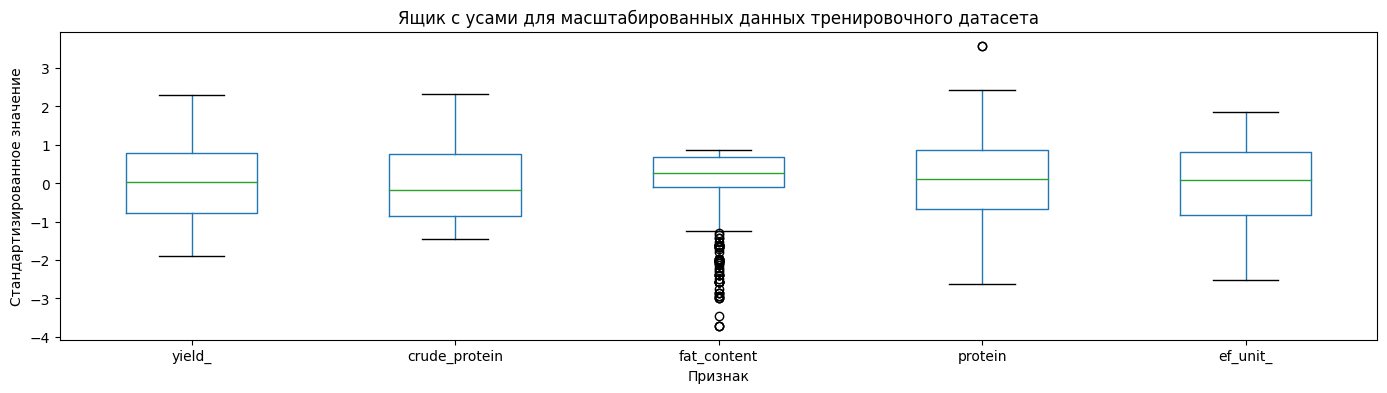

In [137]:
# определяем метод масштабирования
scaler = StandardScaler()
# список всех колиественных признаков из тренировочной выборки
quant_col_names = ['yield_', 'crude_protein', 'fat_content', 'protein', 'ef_unit_']
# обучение и масштабирование количественных признаков тренировочной выборки
X_train_scaler = scaler.fit_transform(X_train[quant_col_names])
# масштабирование количественных признаков тестовой выборки
X_test_scaler = scaler.transform(X_test[quant_col_names])
# создание датафреймов из масштабированных данных
X_train_scaler = pd.DataFrame(X_train_scaler, columns=quant_col_names)
X_test_scaler = pd.DataFrame(X_test_scaler, columns=quant_col_names)
#  проверим масштабированные данные
print(X_train_scaler.shape)
X_train_scaler[quant_col_names].plot(kind='box', figsize=(17, 4))
plt.title('Ящик с усами для масштабированных данных тренировочного датасета')
plt.xlabel('Признак')
plt.ylabel('Стандартизированное значение')
plt.show;

#### <font color="braun">Обучение модели</font>

Соберем все преобразованные данные в датафреймы.

In [138]:
# создание датафреймов из масштабированных и кодированных данных
X_train = pd.concat([X_train_scaler, X_train_ohe], axis=1)
X_test = pd.concat([X_test_scaler, X_test_ohe], axis=1)

print(X_train.shape)
X_train.head(1)

(471, 13)


yield_  crude_protein  fat_content   protein  ef_unit_  \
0  0.780768       1.079523     0.562532 -0.679069  1.577968   

   breed_РефлешнСоверинг  pasture_type_холмистое  dad_breed_Соверин  \
0                    1.0                     1.0                1.0   

   age_менее_2_лет  dad_name_Буйный  dad_name_Геркулес  dad_name_Соловчик  \
0              0.0              0.0                0.0                1.0   

   sp_ratio__1  
0          1.0

In [139]:
# создаём объект для работы с моделью
clf = LogisticRegression()
# обучаем модель на данных
clf = clf.fit(X_train, y_train)
# получаем прогнозные метки классов
y_pred = clf.predict(X_test)

#### <font color="braun">Оценка качества модели</font>

Рассчитаем метрики `accuracy`, `recall` и `precision`.

In [140]:
# расчет метрик
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
# выведем результаты
print('acc: ', round(acc, 3))
print('recall: ', round(recall, 3))
print('precision: ', round(precision, 3))

acc:  0.624
recall:  0.864
precision:  0.618


Общая точность модели 0.618, модель ошибается в 38.2 % случаев.




#### <font color="braun">Построение матрицы ошибок</font>

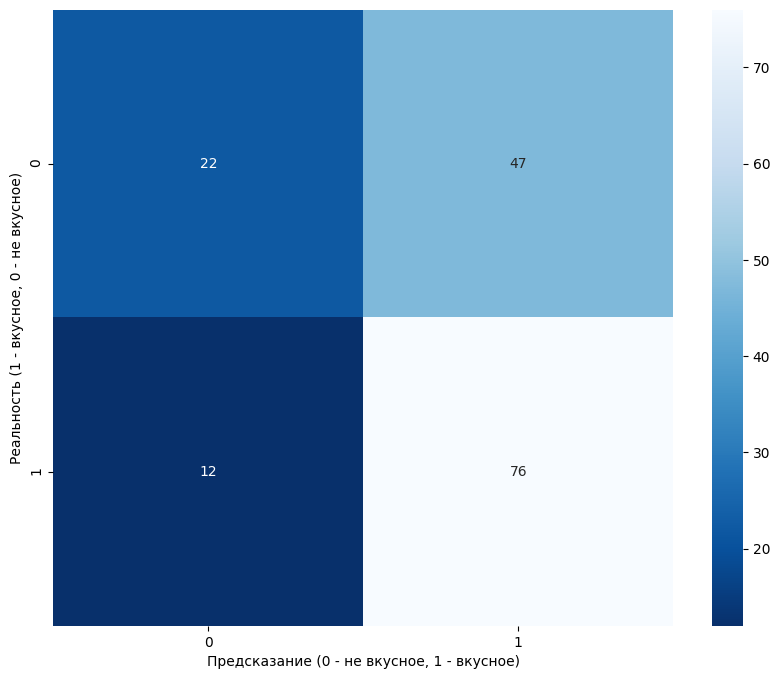

In [141]:
# построим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Реальность (1 - вкусное, 0 - не вкусное)')
plt.xlabel('Предсказание (0 - не вкусное, 1 - вкусное)');

Исходя из полученной матрицы ошибок (слева направо, сверху вниз):
- 22 - модель правильно предсказала невкусное молоко невкусным;
- 47 - модель неправильно предсказала невкусное молок вкусным;
- 12 - модель неправильно предсказала вкусное молоко невкусным;
- 76 - модель правильно предсказала вкусное молоко.

### <font color="darkgreen">Анализ модели `LogisticRegression`</font>

#### <font color="braun">Критичная ошибка</font>

Выведем еще раз метрики `recall` и `precision`.

In [142]:
print('recall: ', round(recall, 3))
print('precision: ', round(precision, 3))

recall:  0.864
precision:  0.618


Ошибка первого рода, это ложно-положительная ошибка, когда молоко предсказанное вкусным, оказалось не вкусным. Это несет в себе риски потери клиентов, которые могут перестать покупать знакомую марку, а новые клиенты просто не появятся.

Ошибка второго рода, это ложно-отрицательная ошибка, когда молоко предсказанное не вкусным, оказалось вкусным. Это несет в себе упущенную выгоду и потеря возможности привлечения новых клиентов.

Критичнее всего в данном случае ошибка первого рода, т.к. на ее устранение потребуются дополнительные финансовые затраты, тогда как во втором случае дополнительных затрат не будет, будет потеря вероятного привлечения клиентов.

Исходя из этого, нам важнее метрика `precision`, т.к. она показывает долю коров со вкусным молоком из тех что мы отобрали. В данном случае 66% коров будет со вкусным молоком и это довольно низкое значение метрики.

#### <font color="braun">Подбор порога</font>

In [143]:
# выведем объекты по убыванию вероятности что молоко вкусное
y_proba = clf.predict_proba(X_test)[:, 1]
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba']).sort_values(by='y_proba', ascending=False)
data.head()

y_valid   y_proba
85         1  0.859881
51         1  0.851820
66         1  0.842035
110        1  0.839009
13         1  0.825588

Для более точной настройки порога, разделим заданный промежуток на несколько более мелких.

In [144]:
# добавим пороги, разделив промежуток на 5 частей
thresholds = [round(i, 3) for i in np.linspace(0.5, 1, num=5, endpoint=False)]
# добавим столбцы
for i in thresholds:
    data['y_pred_' + str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

data.head(3)

y_valid   y_proba  y_pred_0.5  y_pred_0.6  y_pred_0.7  y_pred_0.8  \
85        1  0.859881           1           1           1           1   
51        1  0.851820           1           1           1           1   
66        1  0.842035           1           1           1           1   

    y_pred_0.9  
85           0  
51           0  
66           0

В районе 0.7-0.8 проходит оптимальная граница. Рассмотрим этот участок ближе.

In [145]:
# посчитаем метрику на участке
precision_7 = precision_score(data['y_valid'], data['y_pred_0.7'])
precision_8 = precision_score(data['y_valid'], data['y_pred_0.8'])
print('precision 0.7: ', round(precision_7, 4))
print('precision 0.8: ', round(precision_8, 4))

precision 0.7:  0.8478
precision 0.8:  0.9091


Разделим на еще более мелкие промежутки.

In [146]:
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba']).sort_values(by='y_proba', ascending=False)
# добавим пороги, разделив промежуток на 9 чатей
thresholds = [round(i, 3) for i in np.linspace(0.76, 0.85, num=9, endpoint=False)]
# добавим столбцы
for i in thresholds:
    data['y_pred_' + str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

data.head(3)

y_valid   y_proba  y_pred_0.76  y_pred_0.77  y_pred_0.78  y_pred_0.79  \
85        1  0.859881            1            1            1            1   
51        1  0.851820            1            1            1            1   
66        1  0.842035            1            1            1            1   

    y_pred_0.8  y_pred_0.81  y_pred_0.82  y_pred_0.83  y_pred_0.84  
85           1            1            1            1            1  
51           1            1            1            1            1  
66           1            1            1            1            1

In [147]:
# посчитаем метрику на участке
precision_77 = precision_score(data['y_valid'], data['y_pred_0.77'])
precision_78 = precision_score(data['y_valid'], data['y_pred_0.78'])
precision_79 = precision_score(data['y_valid'], data['y_pred_0.79'])
precision_81 = precision_score(data['y_valid'], data['y_pred_0.81'])
precision_82 = precision_score(data['y_valid'], data['y_pred_0.82'])
print('precision 0.77: ', round(precision_77, 4))
print('precision 0.78: ', round(precision_78, 4))
print('precision 0.79: ', round(precision_79, 4))
print('precision 0.81: ', round(precision_81, 4))
print('precision 0.82: ', round(precision_82, 4))

precision 0.77:  0.8636
precision 0.78:  0.8824
precision 0.79:  0.8667
precision 0.81:  1.0
precision 0.82:  1.0


Разделим на еще более мелкие промежутки.

In [148]:
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba']).sort_values(by='y_proba', ascending=False)
# добавим пороги, разделив промежуток на 10 чатей
thresholds = [round(i, 3) for i in np.linspace(0.801, 0.809, num=9, endpoint=False)]
# добавим столбцы
for i in thresholds:
    data['y_pred_' + str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

data.head(3)

y_valid   y_proba  y_pred_0.801  y_pred_0.802  y_pred_0.803  y_pred_0.804  \
85        1  0.859881             1             1             1             1   
51        1  0.851820             1             1             1             1   
66        1  0.842035             1             1             1             1   

    y_pred_0.805  y_pred_0.806  y_pred_0.807  y_pred_0.808  
85             1             1             1             1  
51             1             1             1             1  
66             1             1             1             1

In [149]:
# посчитаем метрику на участке
precision_801 = precision_score(data['y_valid'], data['y_pred_0.801'])
precision_803 = precision_score(data['y_valid'], data['y_pred_0.803'])
precision_805 = precision_score(data['y_valid'], data['y_pred_0.805'])
print('precision 0.801: ', round(precision_801, 4))
print('precision 0.803: ', round(precision_803, 4))
print('precision 0.805: ', round(precision_805, 4))

precision 0.801:  0.9
precision 0.803:  0.8889
precision 0.805:  1.0


Нашли оптимальный порог 0.805, в этом случае `precision` равен максимальному значению.

Рассчитаем еще раз метрики.

In [150]:
y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.805)
# расчет метрик
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
# выведем результаты
print('acc: ', round(acc, 3))
print('recall: ', round(recall, 3))
print('precision: ', round(precision, 3))

acc:  0.49
recall:  0.091
precision:  1.0


Метрики, относительно первоначальных изменились:
- `acc` - немного снизился;
- `recall` - снизился значительно;
- `precision` - максимально увеличился (то чего мы и добивались).

Посмотрим на матрицу ошибок.

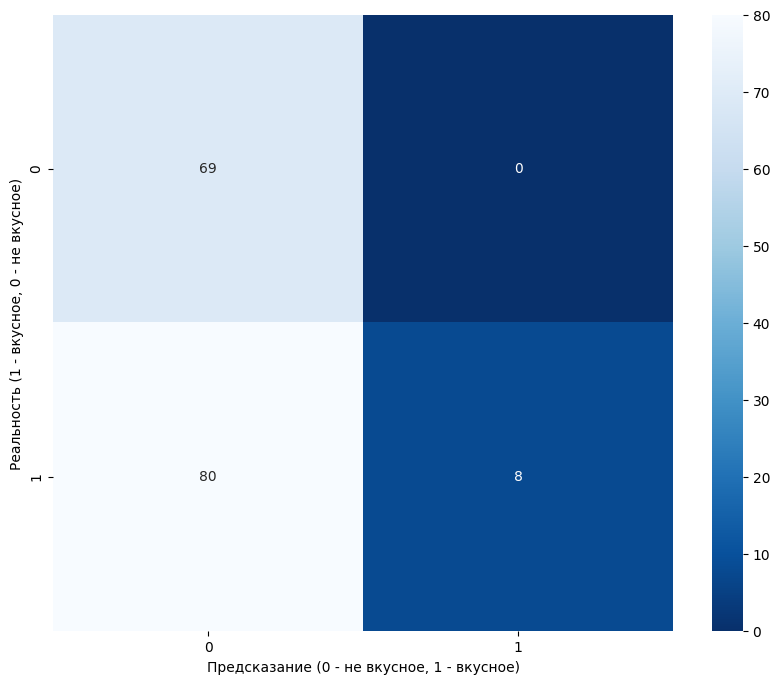

In [151]:
# построим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Реальность (1 - вкусное, 0 - не вкусное)')
plt.xlabel('Предсказание (0 - не вкусное, 1 - вкусное)');

Мы свели критичную ошибку к нулю.

#### <font color="darkred">Вывод по подразделу</font>

Провели обучение модели логистической регрессии используя в качестве целевого признака `Вкус молока`. Оценили качество полученной модели. Общая точность модели составила `0.618`, модель ошибается в `38.2 %` случаев. Посчитали метрики:
- acc:  0.624;
- recall:  0.864;
- precision:  0.618.

По построенной матрице ошибок, оценили ошибки первого и второго рода. Критичнее всего в нашем случае ошибка первого рода, т.к. на ее устранение потребуются дополнительные финансовые затраты, тогда как при ошибке второго рода дополнительных затрат не будет, будет потеря вероятного привлечения клиентов. Исходя из этого, определили важной метрику `precision`, т.к. она показывает долю коров со вкусным молоком из тех что мы отобрали. Провели поиск оптимального порога `0.805`, в этом случае `precision` равен максимальному значению. Вычислили метрики еще раз:
- acc:  0.49;
- recall:  0.091;
- precision:  1.0.

Таким образом, мы свели критичную ошибку к нулю.

---

### <font color="darkgreen">Прогноз вкуса молока</font>

Используя обученную модель, сделаем прогноз вкуса молока, используя датафрейм ЭкоФермы.

Создадим копию датафрейма.

In [152]:
# копируем датафрейм
cow_buy_lor = cow_buy.copy()

#### <font color="braun">Подготовка данных</font>

In [153]:
# преобразуем признак sp_ratio в категориальный
cow_buy_lor['sp_ratio_'] = (cow_buy_lor['sp_ratio'] >= 0.92).astype('int8')
# преобразуем признак ef_unit возведя его в квадрат
cow_buy_lor['ef_unit_'] = cow_buy_lor['ef_unit'] ** 2
print(cow_buy_lor.shape)
cow_buy_lor.head(1)

(16, 14)


breed pasture_type dad_breed  dad_name  fat_content  protein  \
0  ВисБикАйдиал    холмистое    Айдиал  Геркулес         3.58    3.076   

           age  age_  ef_unit  crude_protein  sp_ratio       yield_  \
0  более_2_лет     1    15.28           2019     0.959  6610.157481   

   sp_ratio_  ef_unit_  
0          1  233.4784

#### <font color="braun">Отбор признаков</font>

In [154]:
# удалим ненужные столбцы
cow_buy_lor = cow_buy_lor.drop(['ef_unit', 'sp_ratio', 'age_'], axis=1)
print(cow_buy_lor.shape)
cow_buy_lor.head(1)

(16, 11)


breed pasture_type dad_breed  dad_name  fat_content  protein  \
0  ВисБикАйдиал    холмистое    Айдиал  Геркулес         3.58    3.076   

           age  crude_protein       yield_  sp_ratio_  ef_unit_  
0  более_2_лет           2019  6610.157481          1  233.4784

#### <font color="braun">Кодирование</font>

Выполним подготовку категориальных признаков используя метод кодирования `OneHotEncoding`.

In [155]:
# признаки, участвовавшие в обучении
cat_col_names

['breed', 'pasture_type', 'dad_breed', 'age', 'dad_name', 'sp_ratio_']

In [156]:
# преобразование категориальных признаков
X_train_ohe_lor = encoder.transform(cow_buy_lor[cat_col_names])
# сохранение в переменной новых столбцов
encoder_col_names_lor = encoder.get_feature_names_out()
# создание датафреймов из закодированных данных
X_train_ohe_lor = pd.DataFrame(X_train_ohe_lor, columns=encoder_col_names_lor)
# проверим кодированные данные
print(X_train_ohe_lor.shape)
X_train_ohe_lor.head(3)

(16, 8)


breed_РефлешнСоверинг  pasture_type_холмистое  dad_breed_Соверин  \
0                    0.0                     1.0                0.0   
1                    0.0                     0.0                1.0   
2                    1.0                     0.0                1.0   

   age_менее_2_лет  dad_name_Буйный  dad_name_Геркулес  dad_name_Соловчик  \
0              0.0              0.0                1.0                0.0   
1              1.0              1.0                0.0                0.0   
2              0.0              0.0                0.0                0.0   

   sp_ratio__1  
0          1.0  
1          1.0  
2          1.0

#### <font color="braun">Масштабирование</font>

Выполним масштабирование количественных признаков.

In [157]:
# признаки, участвовавшие в обучении
quant_col_names

['yield_', 'crude_protein', 'fat_content', 'protein', 'ef_unit_']

(16, 5)


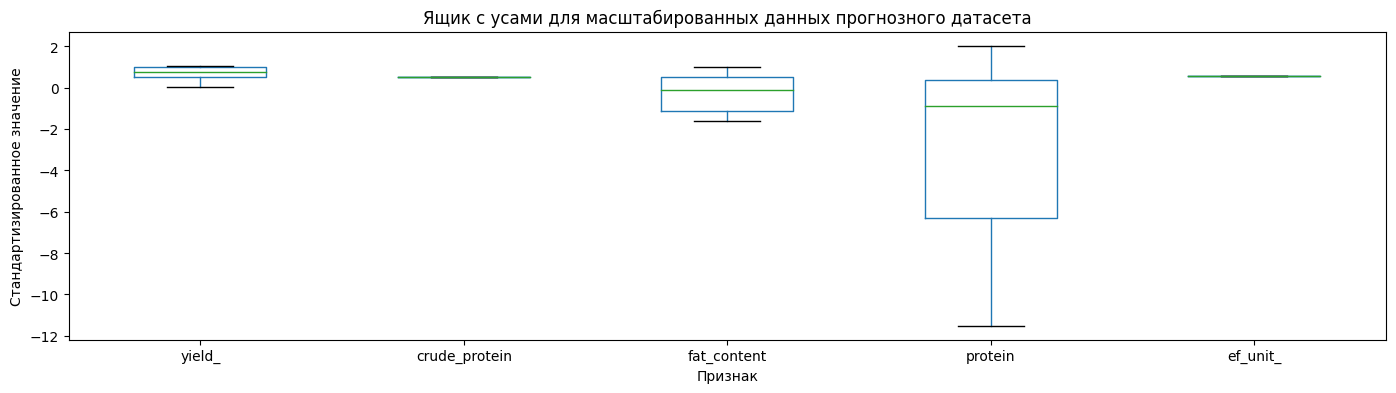

In [158]:
# масштабирование количественных признаков
X_train_scaler_lor = scaler.transform(cow_buy_lor[quant_col_names])
# создание датафреймов из масштабированных данных
X_train_scaler_lor = pd.DataFrame(X_train_scaler_lor, columns=quant_col_names)
#  проверим масштабированные данные
print(X_train_scaler_lor.shape)
X_train_scaler_lor[quant_col_names].plot(kind='box', figsize=(17, 4))
plt.title('Ящик с усами для масштабированных данных прогнозного датасета')
plt.xlabel('Признак')
plt.ylabel('Стандартизированное значение')
plt.show;

#### <font color="braun">Получим прогноз вкуса молока</font>

Соберем все преобразованные данные в датафреймы.

In [159]:
# создание датафрейма из масштабировнных и кодированных данных
X_train_lor = pd.concat([X_train_scaler_lor, X_train_ohe_lor], axis=1)
print(X_train_lor.shape)
X_train_lor.head(3)

(16, 13)


yield_  crude_protein  fat_content   protein  ef_unit_  \
0  1.012886       0.512215    -0.158918  0.094429  0.545371   
1  0.534384       0.512215    -0.399401  2.028176  0.545371   
2  0.338373       0.512215    -0.098797 -0.679069  0.545371   

   breed_РефлешнСоверинг  pasture_type_холмистое  dad_breed_Соверин  \
0                    0.0                     1.0                0.0   
1                    0.0                     0.0                1.0   
2                    1.0                     0.0                1.0   

   age_менее_2_лет  dad_name_Буйный  dad_name_Геркулес  dad_name_Соловчик  \
0              0.0              0.0                1.0                0.0   
1              1.0              1.0                0.0                0.0   
2              0.0              0.0                0.0                0.0   

   sp_ratio__1  
0          1.0  
1          1.0  
2          1.0

Данные подготовлены, сделаем предсказание используя обученную модель.

In [160]:
# создадим новый столбцец с предсказанным вкусом
cow_buy_lor['milk_flavor_'] = clf.predict(X_train_lor)
print(cow_buy_lor.shape)
cow_buy_lor.head(3)

(16, 12)


breed pasture_type dad_breed  dad_name  fat_content  protein  \
0     ВисБикАйдиал    холмистое    Айдиал  Геркулес         3.58    3.076   
1     ВисБикАйдиал    равнинное   Соверин    Буйный         3.54    3.081   
2  РефлешнСоверинг    равнинное   Соверин     Барин         3.59    3.074   

           age  crude_protein       yield_  sp_ratio_  ef_unit_  milk_flavor_  
0  более_2_лет           2019  6610.157481          1  233.4784             1  
1  менее_2_лет           2019  6378.949213          1  233.4784             1  
2  более_2_лет           2019  6284.237960          1  233.4784             1

Выведем полученный датафрейм, с вкусным молоком отсортированным по убыванию удоя.

In [161]:
# выведем список коров рекомендуемых к покупке с вкусным молоком и
# удоем больше 6000 кг в год
cow_buy_final = cow_buy_lor.loc[(cow_buy_lor['yield_'] >= 6000) & \
                                (cow_buy_lor['milk_flavor_'] == 1)].sort_values('yield_', ascending=False)
cow_buy_final

breed pasture_type dad_breed  dad_name  fat_content  protein  \
9   РефлешнСоверинг    равнинное   Соверин  Геркулес         3.73    3.073   
0      ВисБикАйдиал    холмистое    Айдиал  Геркулес         3.58    3.076   
6      ВисБикАйдиал    равнинное   Соверин    Буйный         3.57    3.079   
4   РефлешнСоверинг    равнинное    Айдиал    Буйный         3.64    3.074   
7   РефлешнСоверинг    холмистое    Айдиал    Буйный         3.40    3.079   
1      ВисБикАйдиал    равнинное   Соверин    Буйный         3.54    3.081   
13     ВисБикАйдиал    холмистое   Соверин  Соловчик         3.73    3.079   
2   РефлешнСоверинг    равнинное   Соверин     Барин         3.59    3.074   
11     ВисБикАйдиал    холмистое   Соверин     Барин         3.42    3.075   

            age  crude_protein       yield_  sp_ratio_  ef_unit_  milk_flavor_  
9   более_2_лет           2019  6618.167111          1  233.4784             1  
0   более_2_лет           2019  6610.157481          1  233.4784             1  
6   более_2_лет           2019  6571.497922          1  233.4784             1  
4   более_2_лет           2019  6542.384251          1  233.4784             1  
7   менее_2_лет           2019  6400.778852          1  233.4784             1  
1   менее_2_лет           2019  6378.949213          1  233.4784             1  
13  более_2_лет           2019  6344.946044          1  233.4784             1  
2   более_2_лет           2019  6284.237960          1  233.4784             1  
11  менее_2_лет           2019  6127.712927          1  233.4784             1

Учитывая доверительный интервал рассчитанный ранее, выведем еще один список.

In [162]:
# выведем список коров рекомендуемых к покупке с вкусным молоком и
# удоем больше 6000 кг в год с учетом нижнего доверительного интервала
cow_buy_final_2 = cow_buy_lor.loc[(cow_buy_lor['yield_'] + q_02_5 >= 6000) & \
                                (cow_buy_lor['milk_flavor_'] == 1)].sort_values('yield_', ascending=False)
cow_buy_final_2

breed pasture_type dad_breed  dad_name  fat_content  protein  \
9  РефлешнСоверинг    равнинное   Соверин  Геркулес         3.73    3.073   
0     ВисБикАйдиал    холмистое    Айдиал  Геркулес         3.58    3.076   
6     ВисБикАйдиал    равнинное   Соверин    Буйный         3.57    3.079   
4  РефлешнСоверинг    равнинное    Айдиал    Буйный         3.64    3.074   
7  РефлешнСоверинг    холмистое    Айдиал    Буйный         3.40    3.079   

           age  crude_protein       yield_  sp_ratio_  ef_unit_  milk_flavor_  
9  более_2_лет           2019  6618.167111          1  233.4784             1  
0  более_2_лет           2019  6610.157481          1  233.4784             1  
6  более_2_лет           2019  6571.497922          1  233.4784             1  
4  более_2_лет           2019  6542.384251          1  233.4784             1  
7  менее_2_лет           2019  6400.778852          1  233.4784             1

### <font color="darkred">Вывод по разделу</font>

Выполнили подготовку категориальных признаков, масштабирование количественных признаков датафрейма ЭкоФермы. Используя обученную в предыдущем разделе модель логистической регрессии, сделали прогноз вкуса молока.

Получили датафрейм, с вкусным молоком с сортировкой по убыванию удоя. Так же дополнительно вывели этот датафрейм с учетом рассчитанного ранее доверительного интервала.

---
## <font color="darkred">Итоговые выводы</font>

### <font color="darkgreen">Прогнозы удоя и вкуса молока</font>

Итоговый датафрейм с данными коров, для которых спрогнозирован удой более 6000 кг в год и вкусным молоком:

In [163]:
cow_buy_final

breed pasture_type dad_breed  dad_name  fat_content  protein  \
9   РефлешнСоверинг    равнинное   Соверин  Геркулес         3.73    3.073   
0      ВисБикАйдиал    холмистое    Айдиал  Геркулес         3.58    3.076   
6      ВисБикАйдиал    равнинное   Соверин    Буйный         3.57    3.079   
4   РефлешнСоверинг    равнинное    Айдиал    Буйный         3.64    3.074   
7   РефлешнСоверинг    холмистое    Айдиал    Буйный         3.40    3.079   
1      ВисБикАйдиал    равнинное   Соверин    Буйный         3.54    3.081   
13     ВисБикАйдиал    холмистое   Соверин  Соловчик         3.73    3.079   
2   РефлешнСоверинг    равнинное   Соверин     Барин         3.59    3.074   
11     ВисБикАйдиал    холмистое   Соверин     Барин         3.42    3.075   

            age  crude_protein       yield_  sp_ratio_  ef_unit_  milk_flavor_  
9   более_2_лет           2019  6618.167111          1  233.4784             1  
0   более_2_лет           2019  6610.157481          1  233.4784             1  
6   более_2_лет           2019  6571.497922          1  233.4784             1  
4   более_2_лет           2019  6542.384251          1  233.4784             1  
7   менее_2_лет           2019  6400.778852          1  233.4784             1  
1   менее_2_лет           2019  6378.949213          1  233.4784             1  
13  более_2_лет           2019  6344.946044          1  233.4784             1  
2   более_2_лет           2019  6284.237960          1  233.4784             1  
11  менее_2_лет           2019  6127.712927          1  233.4784             1

Исходя из полученных прогнозов, фермер может купить 9 указанных коров с минимальным риском. Коровы не попавшие в этот список могут или приносить меньше 6000 кг молока в год или иметь не вкусное молоко или иметь оба этих отрицательных фактора.

Чтобы снизить риски, фермеру рекомендуется:
- предпочтительнее брать коров порода папы быка которых Айдиал;
- предпочтительнее брать коров возрастом старше 2 лет.

### <font color="darkgreen">Выводы о моделях</font>

В данном проекте использовали несколько способов улучшения качества регрессионной модели:
- добавляли дополнительные признаки, путем объединения двух датафреймов;
- переводили нелинейный признак в категориальный бинарный;
- возводили количественный признак в квадрат, чтобы уменьшить нелинейную зависимость;
- подготавливали датафрейм перед обучением;
- подбирали оптимальный порог для логистической регресии.

Результаты модели можно улучшить если имеются дополнительные данные, например:
- более точный возраст коров;
- вес коров;
- соотношение их сна/бодрствования.

При анализе рисков или экономических расчетов, важны следующие метрики:

- Матрица ошибок. Она позволяет оценить риски последствий неверных прогнозов, а в случае наличия экономических, финансовых данных, можно посчитать и объем таких рисков.
- Recall. Показывает, например, всех ли дефолтных клиентов банка удалось предугадать.
- Precission. Показывает, например, всегда ли модель верно предсказывает дефолт клиента банка.
